In [1]:
import os
import random
from datetime import datetime
import ast

import gc
import yaml
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.tensorboard import SummaryWriter

from preprocessing.final_preprocessing import serve_data, serve_data_sine

from models.transformer_encoder import TransEncoder

from ddpm.ddpm import GaussianDiffusion1D

from evaluation.pca_tsne import visual_evaluation
from evaluation.jsd import plot_jsd
from evaluation.rmse import rmse

gc.collect()

random.seed(42)
np.random.seed(42)

In [2]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Parameters

In [ ]:
config_path = "./config_transcoder.yml"
with open(config_path, 'r') as f:
    config = yaml.full_load(f)

date = datetime.today().strftime('%Y-%m-%d-%H-%M')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

seq_len = config["seq_len"]
epochs = config["epochs"]
timesteps = config["timesteps"]
batch_size_config = config["batch_size"]
latent_dim = config["latent_dim"]
num_layers = config["num_layers"]
n_heads = config["n_heads"]
beta_schedule = config["beta_schedule"]
objective = config["objective"]
model_name = config["model_name"]
cond_model = config["cond_model"]
lr = float(config["lr"])
betas = tuple_of_floats = ast.literal_eval(config["betas"])
save_rate = int(config["save_rate"])

assert model_name in ["BaseLine", "TransEncoder"], "Chosen  model was not valid, the options are BaseLine or TransEncoder"
assert cond_model in {"mlp", "te", "fft", "stft"}, "Chosen conditioning model was not valid, the options are mlp, te, fft and stft"

log_file_name = "trans_ori_data_kmeans5_10kepochs"
tb_writer = f"./logging/tensorboard/{log_file_name}"

# Data

In [4]:
# train_loader, test_loader, features , test_data = serve_data_sine(batch_size_config, seq_len, var=5)
# cond_features = 10

In [ ]:
train_loader, test_loader, train_cols, test_cols, test_data, features, cond_features = serve_data(types=["re"],seq_len=seq_len, batch_size=batch_size_config, k=5, overwrite=True)

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


(13129, 10, 12)


# Model

In [6]:
model = model = TransEncoder(features = features, latent_dim = latent_dim,num_heads = n_heads, num_layers = num_layers, cond_features=cond_features, cond_model=cond_model, device=device, seq_len=seq_len)
    
ddpm = GaussianDiffusion1D(model, seq_length = seq_len, timesteps = timesteps, objective = objective, loss_type = 'l2', beta_schedule = beta_schedule)
ddpm = ddpm.to(device)

optim = torch.optim.Adam(ddpm.parameters(), lr = lr, betas = betas)
writer = SummaryWriter(tb_writer)

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


## Train

In [ ]:
run_path = f"./logging/weights/{log_file_name}"
os.makedirs(run_path)

rmse_list = []
lowest_loss = 100000
step=0

for running_epoch in tqdm(range(epochs)):
    model.train()
    running_loss = 0.0
    for i, (data, cond_data) in enumerate(train_loader):
        data = data.to(device)
        
        cond_data = cond_data.float()
        cond_data = cond_data.to(device)
                
        batch_size = data.shape[0]
        
        optim.zero_grad()
        
        loss = ddpm(data, None)
        loss.backward()
        
        optim.step()
        
        running_loss += loss.item()

        
        if loss.item() < lowest_loss:
            lowest_loss = loss.item()
            best_model_params = model.state_dict()
        
        writer.add_scalar("Batch Training Loss", loss, global_step=step)
        step += 1
    
    avg_epoch_loss = running_loss / len(train_loader)
    writer.add_scalar("Epoch Training Loss", avg_epoch_loss, running_epoch)
    
    if running_epoch % 5 ==0:
        model.eval()        
        with torch.no_grad():
            sample = ddpm.sample(batch_size_config)
        
        p = sample.cpu()
        q = torch.from_numpy(test_data[:batch_size_config])
            
        rmse_res = rmse(p,q).item()
        rmse_list.append(rmse_res)
        
        writer.add_scalar('Epoch Training RMSE', rmse_res, running_epoch)
        
        print(f'Epoch: {running_epoch+1}, Epoch Loss: {avg_epoch_loss:.4f}, RMSE: {rmse_res:.4f}')
    
    else:
        print(f'Epoch: {running_epoch+1}, Epoch Loss: {avg_epoch_loss:.4f}')
            
            
    if running_epoch % save_rate == 0:
        torch.save({
            'epoch': running_epoch+1,
            'diffusion_state_dict': ddpm.state_dict(),
            'diffusion_optim_state_dict': optim.state_dict()
            }, os.path.join(f'{run_path}', f'ep_{running_epoch}_mse_{avg_epoch_loss:.3f}_weights.pth'))

torch.save(best_model_params, os.path.join(f'{run_path}', 'best_model_weights.pth'))

  0%|          | 1/2000 [00:06<3:42:52,  6.69s/it]

Epoch: 1, Epoch Loss: 0.6633, RMSE: 0.6131


  0%|          | 2/2000 [00:07<1:51:24,  3.35s/it]

Epoch: 2, Epoch Loss: 0.3893


  0%|          | 3/2000 [00:08<1:15:42,  2.27s/it]

Epoch: 3, Epoch Loss: 0.3515


  0%|          | 4/2000 [00:09<58:59,  1.77s/it]  

Epoch: 4, Epoch Loss: 0.3307


  0%|          | 5/2000 [00:10<49:55,  1.50s/it]

Epoch: 5, Epoch Loss: 0.3138


  0%|          | 6/2000 [00:17<1:44:19,  3.14s/it]

Epoch: 6, Epoch Loss: 0.3062, RMSE: 0.6006


  0%|          | 7/2000 [00:18<1:21:02,  2.44s/it]

Epoch: 7, Epoch Loss: 0.2909


  0%|          | 8/2000 [00:19<1:05:50,  1.98s/it]

Epoch: 8, Epoch Loss: 0.2829


  0%|          | 9/2000 [00:20<55:36,  1.68s/it]  

Epoch: 9, Epoch Loss: 0.2740


  0%|          | 10/2000 [00:21<48:37,  1.47s/it]

Epoch: 10, Epoch Loss: 0.2651


  1%|          | 11/2000 [00:27<1:37:01,  2.93s/it]

Epoch: 11, Epoch Loss: 0.2621, RMSE: 0.5921


  1%|          | 12/2000 [00:28<1:17:26,  2.34s/it]

Epoch: 12, Epoch Loss: 0.2591


  1%|          | 13/2000 [00:29<1:03:50,  1.93s/it]

Epoch: 13, Epoch Loss: 0.2541


  1%|          | 14/2000 [00:30<54:25,  1.64s/it]  

Epoch: 14, Epoch Loss: 0.2533


  1%|          | 15/2000 [00:31<47:50,  1.45s/it]

Epoch: 15, Epoch Loss: 0.2488


  1%|          | 16/2000 [00:37<1:35:08,  2.88s/it]

Epoch: 16, Epoch Loss: 0.2468, RMSE: 0.5855


  1%|          | 17/2000 [00:38<1:16:21,  2.31s/it]

Epoch: 17, Epoch Loss: 0.2463


  1%|          | 18/2000 [00:39<1:03:13,  1.91s/it]

Epoch: 18, Epoch Loss: 0.2420


  1%|          | 19/2000 [00:40<54:02,  1.64s/it]  

Epoch: 19, Epoch Loss: 0.2388


  1%|          | 20/2000 [00:41<47:35,  1.44s/it]

Epoch: 20, Epoch Loss: 0.2406


  1%|          | 21/2000 [00:47<1:35:06,  2.88s/it]

Epoch: 21, Epoch Loss: 0.2411, RMSE: 0.5947


  1%|          | 22/2000 [00:48<1:16:20,  2.32s/it]

Epoch: 22, Epoch Loss: 0.2397


  1%|          | 23/2000 [00:49<1:03:10,  1.92s/it]

Epoch: 23, Epoch Loss: 0.2369


  1%|          | 24/2000 [00:50<53:57,  1.64s/it]  

Epoch: 24, Epoch Loss: 0.2338


  1%|▏         | 25/2000 [00:51<47:31,  1.44s/it]

Epoch: 25, Epoch Loss: 0.2351


  1%|▏         | 26/2000 [00:57<1:34:45,  2.88s/it]

Epoch: 26, Epoch Loss: 0.2325, RMSE: 0.6011


  1%|▏         | 27/2000 [00:58<1:16:06,  2.31s/it]

Epoch: 27, Epoch Loss: 0.2334


  1%|▏         | 28/2000 [00:59<1:03:04,  1.92s/it]

Epoch: 28, Epoch Loss: 0.2310


  1%|▏         | 29/2000 [01:00<53:55,  1.64s/it]  

Epoch: 29, Epoch Loss: 0.2312


  2%|▏         | 30/2000 [01:01<47:30,  1.45s/it]

Epoch: 30, Epoch Loss: 0.2291


  2%|▏         | 31/2000 [01:08<1:34:50,  2.89s/it]

Epoch: 31, Epoch Loss: 0.2277, RMSE: 0.5934


  2%|▏         | 32/2000 [01:09<1:16:18,  2.33s/it]

Epoch: 32, Epoch Loss: 0.2309


  2%|▏         | 33/2000 [01:10<1:03:16,  1.93s/it]

Epoch: 33, Epoch Loss: 0.2269


  2%|▏         | 34/2000 [01:11<54:01,  1.65s/it]  

Epoch: 34, Epoch Loss: 0.2293


  2%|▏         | 35/2000 [01:12<47:35,  1.45s/it]

Epoch: 35, Epoch Loss: 0.2273


  2%|▏         | 36/2000 [01:18<1:34:48,  2.90s/it]

Epoch: 36, Epoch Loss: 0.2245, RMSE: 0.5808


  2%|▏         | 37/2000 [01:19<1:16:06,  2.33s/it]

Epoch: 37, Epoch Loss: 0.2261


  2%|▏         | 38/2000 [01:20<1:02:58,  1.93s/it]

Epoch: 38, Epoch Loss: 0.2265


  2%|▏         | 39/2000 [01:21<53:50,  1.65s/it]  

Epoch: 39, Epoch Loss: 0.2258


  2%|▏         | 40/2000 [01:22<47:24,  1.45s/it]

Epoch: 40, Epoch Loss: 0.2265


  2%|▏         | 41/2000 [01:28<1:34:38,  2.90s/it]

Epoch: 41, Epoch Loss: 0.2230, RMSE: 0.5975


  2%|▏         | 42/2000 [01:29<1:16:03,  2.33s/it]

Epoch: 42, Epoch Loss: 0.2251


  2%|▏         | 43/2000 [01:30<1:03:03,  1.93s/it]

Epoch: 43, Epoch Loss: 0.2216


  2%|▏         | 44/2000 [01:31<53:56,  1.65s/it]  

Epoch: 44, Epoch Loss: 0.2241


  2%|▏         | 45/2000 [01:32<47:31,  1.46s/it]

Epoch: 45, Epoch Loss: 0.2266


  2%|▏         | 46/2000 [01:38<1:34:28,  2.90s/it]

Epoch: 46, Epoch Loss: 0.2242, RMSE: 0.5937


  2%|▏         | 47/2000 [01:39<1:15:49,  2.33s/it]

Epoch: 47, Epoch Loss: 0.2222


  2%|▏         | 48/2000 [01:40<1:02:47,  1.93s/it]

Epoch: 48, Epoch Loss: 0.2207


  2%|▏         | 49/2000 [01:41<53:38,  1.65s/it]  

Epoch: 49, Epoch Loss: 0.2208


  2%|▎         | 50/2000 [01:42<47:19,  1.46s/it]

Epoch: 50, Epoch Loss: 0.2226


  3%|▎         | 51/2000 [01:49<1:35:00,  2.92s/it]

Epoch: 51, Epoch Loss: 0.2221, RMSE: 0.6011


  3%|▎         | 52/2000 [01:50<1:16:14,  2.35s/it]

Epoch: 52, Epoch Loss: 0.2199


  3%|▎         | 53/2000 [01:51<1:03:06,  1.94s/it]

Epoch: 53, Epoch Loss: 0.2227


  3%|▎         | 54/2000 [01:52<53:53,  1.66s/it]  

Epoch: 54, Epoch Loss: 0.2185


  3%|▎         | 55/2000 [01:53<49:00,  1.51s/it]

Epoch: 55, Epoch Loss: 0.2204


  3%|▎         | 56/2000 [01:59<1:35:23,  2.94s/it]

Epoch: 56, Epoch Loss: 0.2187, RMSE: 0.5936


  3%|▎         | 57/2000 [02:00<1:16:27,  2.36s/it]

Epoch: 57, Epoch Loss: 0.2223


  3%|▎         | 58/2000 [02:01<1:03:15,  1.95s/it]

Epoch: 58, Epoch Loss: 0.2190


  3%|▎         | 59/2000 [02:02<53:59,  1.67s/it]  

Epoch: 59, Epoch Loss: 0.2164


  3%|▎         | 60/2000 [02:03<47:27,  1.47s/it]

Epoch: 60, Epoch Loss: 0.2161


  3%|▎         | 61/2000 [02:09<1:34:15,  2.92s/it]

Epoch: 61, Epoch Loss: 0.2181, RMSE: 0.5941


  3%|▎         | 62/2000 [02:10<1:15:36,  2.34s/it]

Epoch: 62, Epoch Loss: 0.2183


  3%|▎         | 63/2000 [02:11<1:02:34,  1.94s/it]

Epoch: 63, Epoch Loss: 0.2193


  3%|▎         | 64/2000 [02:12<53:24,  1.66s/it]  

Epoch: 64, Epoch Loss: 0.2182


  3%|▎         | 65/2000 [02:13<46:58,  1.46s/it]

Epoch: 65, Epoch Loss: 0.2146


  3%|▎         | 66/2000 [02:20<1:33:42,  2.91s/it]

Epoch: 66, Epoch Loss: 0.2174, RMSE: 0.5854


  3%|▎         | 67/2000 [02:21<1:15:15,  2.34s/it]

Epoch: 67, Epoch Loss: 0.2147


  3%|▎         | 68/2000 [02:22<1:02:20,  1.94s/it]

Epoch: 68, Epoch Loss: 0.2180


  3%|▎         | 69/2000 [02:23<53:17,  1.66s/it]  

Epoch: 69, Epoch Loss: 0.2187


  4%|▎         | 70/2000 [02:24<46:56,  1.46s/it]

Epoch: 70, Epoch Loss: 0.2176


  4%|▎         | 71/2000 [02:30<1:33:39,  2.91s/it]

Epoch: 71, Epoch Loss: 0.2154, RMSE: 0.5871


  4%|▎         | 72/2000 [02:31<1:15:13,  2.34s/it]

Epoch: 72, Epoch Loss: 0.2150


  4%|▎         | 73/2000 [02:32<1:02:20,  1.94s/it]

Epoch: 73, Epoch Loss: 0.2126


  4%|▎         | 74/2000 [02:33<53:17,  1.66s/it]  

Epoch: 74, Epoch Loss: 0.2160


  4%|▍         | 75/2000 [02:34<46:59,  1.46s/it]

Epoch: 75, Epoch Loss: 0.2149


  4%|▍         | 76/2000 [02:40<1:33:35,  2.92s/it]

Epoch: 76, Epoch Loss: 0.2161, RMSE: 0.5943


  4%|▍         | 77/2000 [02:41<1:15:05,  2.34s/it]

Epoch: 77, Epoch Loss: 0.2143


  4%|▍         | 78/2000 [02:42<1:02:10,  1.94s/it]

Epoch: 78, Epoch Loss: 0.2177


  4%|▍         | 79/2000 [02:43<53:05,  1.66s/it]  

Epoch: 79, Epoch Loss: 0.2175


  4%|▍         | 80/2000 [02:44<46:44,  1.46s/it]

Epoch: 80, Epoch Loss: 0.2134


  4%|▍         | 81/2000 [02:51<1:33:12,  2.91s/it]

Epoch: 81, Epoch Loss: 0.2156, RMSE: 0.5905


  4%|▍         | 82/2000 [02:52<1:14:55,  2.34s/it]

Epoch: 82, Epoch Loss: 0.2116


  4%|▍         | 83/2000 [02:53<1:02:01,  1.94s/it]

Epoch: 83, Epoch Loss: 0.2109


  4%|▍         | 84/2000 [02:54<52:59,  1.66s/it]  

Epoch: 84, Epoch Loss: 0.2137


  4%|▍         | 85/2000 [02:55<46:39,  1.46s/it]

Epoch: 85, Epoch Loss: 0.2129


  4%|▍         | 86/2000 [03:01<1:32:58,  2.91s/it]

Epoch: 86, Epoch Loss: 0.2127, RMSE: 0.5957


  4%|▍         | 87/2000 [03:02<1:14:37,  2.34s/it]

Epoch: 87, Epoch Loss: 0.2135


  4%|▍         | 88/2000 [03:03<1:01:47,  1.94s/it]

Epoch: 88, Epoch Loss: 0.2146


  4%|▍         | 89/2000 [03:04<52:55,  1.66s/it]  

Epoch: 89, Epoch Loss: 0.2123


  4%|▍         | 90/2000 [03:05<46:38,  1.46s/it]

Epoch: 90, Epoch Loss: 0.2154


  5%|▍         | 91/2000 [03:11<1:32:52,  2.92s/it]

Epoch: 91, Epoch Loss: 0.2150, RMSE: 0.5966


  5%|▍         | 92/2000 [03:12<1:14:40,  2.35s/it]

Epoch: 92, Epoch Loss: 0.2094


  5%|▍         | 93/2000 [03:13<1:01:47,  1.94s/it]

Epoch: 93, Epoch Loss: 0.2147


  5%|▍         | 94/2000 [03:14<52:48,  1.66s/it]  

Epoch: 94, Epoch Loss: 0.2121


  5%|▍         | 95/2000 [03:15<46:32,  1.47s/it]

Epoch: 95, Epoch Loss: 0.2160


  5%|▍         | 96/2000 [03:22<1:32:45,  2.92s/it]

Epoch: 96, Epoch Loss: 0.2102, RMSE: 0.5942


  5%|▍         | 97/2000 [03:23<1:14:30,  2.35s/it]

Epoch: 97, Epoch Loss: 0.2143


  5%|▍         | 98/2000 [03:24<1:01:39,  1.95s/it]

Epoch: 98, Epoch Loss: 0.2121


  5%|▍         | 99/2000 [03:25<52:39,  1.66s/it]  

Epoch: 99, Epoch Loss: 0.2125


  5%|▌         | 100/2000 [03:26<46:22,  1.46s/it]

Epoch: 100, Epoch Loss: 0.2120


  5%|▌         | 101/2000 [03:32<1:33:22,  2.95s/it]

Epoch: 101, Epoch Loss: 0.2104, RMSE: 0.5975


  5%|▌         | 102/2000 [03:33<1:15:30,  2.39s/it]

Epoch: 102, Epoch Loss: 0.2134


  5%|▌         | 103/2000 [03:34<1:02:30,  1.98s/it]

Epoch: 103, Epoch Loss: 0.2111


  5%|▌         | 104/2000 [03:35<53:24,  1.69s/it]  

Epoch: 104, Epoch Loss: 0.2112


  5%|▌         | 105/2000 [03:36<47:05,  1.49s/it]

Epoch: 105, Epoch Loss: 0.2116


  5%|▌         | 106/2000 [03:43<1:33:54,  2.98s/it]

Epoch: 106, Epoch Loss: 0.2104, RMSE: 0.5866


  5%|▌         | 107/2000 [03:44<1:15:55,  2.41s/it]

Epoch: 107, Epoch Loss: 0.2107


  5%|▌         | 108/2000 [03:45<1:03:20,  2.01s/it]

Epoch: 108, Epoch Loss: 0.2119


  5%|▌         | 109/2000 [03:46<54:02,  1.71s/it]  

Epoch: 109, Epoch Loss: 0.2120


  6%|▌         | 110/2000 [03:47<47:26,  1.51s/it]

Epoch: 110, Epoch Loss: 0.2097


  6%|▌         | 111/2000 [03:53<1:33:09,  2.96s/it]

Epoch: 111, Epoch Loss: 0.2075, RMSE: 0.5966


  6%|▌         | 112/2000 [03:54<1:14:51,  2.38s/it]

Epoch: 112, Epoch Loss: 0.2114


  6%|▌         | 113/2000 [03:55<1:01:55,  1.97s/it]

Epoch: 113, Epoch Loss: 0.2127


  6%|▌         | 114/2000 [03:56<53:12,  1.69s/it]  

Epoch: 114, Epoch Loss: 0.2098


  6%|▌         | 115/2000 [03:57<47:06,  1.50s/it]

Epoch: 115, Epoch Loss: 0.2139


  6%|▌         | 116/2000 [04:04<1:35:35,  3.04s/it]

Epoch: 116, Epoch Loss: 0.2083, RMSE: 0.6026


  6%|▌         | 117/2000 [04:05<1:17:07,  2.46s/it]

Epoch: 117, Epoch Loss: 0.2084


  6%|▌         | 118/2000 [04:06<1:04:16,  2.05s/it]

Epoch: 118, Epoch Loss: 0.2122


  6%|▌         | 119/2000 [04:07<56:11,  1.79s/it]  

Epoch: 119, Epoch Loss: 0.2118


  6%|▌         | 120/2000 [04:09<49:18,  1.57s/it]

Epoch: 120, Epoch Loss: 0.2075


  6%|▌         | 121/2000 [04:15<1:35:03,  3.04s/it]

Epoch: 121, Epoch Loss: 0.2103, RMSE: 0.5906


  6%|▌         | 122/2000 [04:16<1:16:24,  2.44s/it]

Epoch: 122, Epoch Loss: 0.2080


  6%|▌         | 123/2000 [04:17<1:03:01,  2.01s/it]

Epoch: 123, Epoch Loss: 0.2111


  6%|▌         | 124/2000 [04:18<53:36,  1.71s/it]  

Epoch: 124, Epoch Loss: 0.2081


  6%|▋         | 125/2000 [04:19<47:34,  1.52s/it]

Epoch: 125, Epoch Loss: 0.2100


  6%|▋         | 126/2000 [04:26<1:34:49,  3.04s/it]

Epoch: 126, Epoch Loss: 0.2089, RMSE: 0.5917


  6%|▋         | 127/2000 [04:27<1:15:51,  2.43s/it]

Epoch: 127, Epoch Loss: 0.2088


  6%|▋         | 128/2000 [04:28<1:02:35,  2.01s/it]

Epoch: 128, Epoch Loss: 0.2071


  6%|▋         | 129/2000 [04:29<53:16,  1.71s/it]  

Epoch: 129, Epoch Loss: 0.2095


  6%|▋         | 130/2000 [04:30<46:47,  1.50s/it]

Epoch: 130, Epoch Loss: 0.2081


  7%|▋         | 131/2000 [04:36<1:32:08,  2.96s/it]

Epoch: 131, Epoch Loss: 0.2087, RMSE: 0.5990


  7%|▋         | 132/2000 [04:37<1:13:56,  2.37s/it]

Epoch: 132, Epoch Loss: 0.2093


  7%|▋         | 133/2000 [04:38<1:01:12,  1.97s/it]

Epoch: 133, Epoch Loss: 0.2095


  7%|▋         | 134/2000 [04:39<52:18,  1.68s/it]  

Epoch: 134, Epoch Loss: 0.2085


  7%|▋         | 135/2000 [04:40<46:06,  1.48s/it]

Epoch: 135, Epoch Loss: 0.2067


  7%|▋         | 136/2000 [04:47<1:31:32,  2.95s/it]

Epoch: 136, Epoch Loss: 0.2080, RMSE: 0.5971


  7%|▋         | 137/2000 [04:48<1:13:30,  2.37s/it]

Epoch: 137, Epoch Loss: 0.2062


  7%|▋         | 138/2000 [04:49<1:00:50,  1.96s/it]

Epoch: 138, Epoch Loss: 0.2068


  7%|▋         | 139/2000 [04:50<51:56,  1.67s/it]  

Epoch: 139, Epoch Loss: 0.2082


  7%|▋         | 140/2000 [04:51<45:41,  1.47s/it]

Epoch: 140, Epoch Loss: 0.2076


  7%|▋         | 141/2000 [04:57<1:30:53,  2.93s/it]

Epoch: 141, Epoch Loss: 0.2080, RMSE: 0.5892


  7%|▋         | 142/2000 [04:58<1:13:03,  2.36s/it]

Epoch: 142, Epoch Loss: 0.2104


  7%|▋         | 143/2000 [04:59<1:00:32,  1.96s/it]

Epoch: 143, Epoch Loss: 0.2080


  7%|▋         | 144/2000 [05:00<51:49,  1.68s/it]  

Epoch: 144, Epoch Loss: 0.2068


  7%|▋         | 145/2000 [05:01<45:41,  1.48s/it]

Epoch: 145, Epoch Loss: 0.2118


  7%|▋         | 146/2000 [05:07<1:30:48,  2.94s/it]

Epoch: 146, Epoch Loss: 0.2076, RMSE: 0.5840


  7%|▋         | 147/2000 [05:08<1:12:55,  2.36s/it]

Epoch: 147, Epoch Loss: 0.2072


  7%|▋         | 148/2000 [05:09<1:00:20,  1.96s/it]

Epoch: 148, Epoch Loss: 0.2081


  7%|▋         | 149/2000 [05:10<51:34,  1.67s/it]  

Epoch: 149, Epoch Loss: 0.2075


  8%|▊         | 150/2000 [05:11<45:29,  1.48s/it]

Epoch: 150, Epoch Loss: 0.2070


  8%|▊         | 151/2000 [05:18<1:31:07,  2.96s/it]

Epoch: 151, Epoch Loss: 0.2097, RMSE: 0.5981


  8%|▊         | 152/2000 [05:19<1:13:11,  2.38s/it]

Epoch: 152, Epoch Loss: 0.2081


  8%|▊         | 153/2000 [05:20<1:00:40,  1.97s/it]

Epoch: 153, Epoch Loss: 0.2078


  8%|▊         | 154/2000 [05:21<51:47,  1.68s/it]  

Epoch: 154, Epoch Loss: 0.2067


  8%|▊         | 155/2000 [05:22<45:36,  1.48s/it]

Epoch: 155, Epoch Loss: 0.2042


  8%|▊         | 156/2000 [05:28<1:30:30,  2.94s/it]

Epoch: 156, Epoch Loss: 0.2067, RMSE: 0.5941


  8%|▊         | 157/2000 [05:29<1:12:44,  2.37s/it]

Epoch: 157, Epoch Loss: 0.2044


  8%|▊         | 158/2000 [05:30<1:00:16,  1.96s/it]

Epoch: 158, Epoch Loss: 0.2071


  8%|▊         | 159/2000 [05:31<51:27,  1.68s/it]  

Epoch: 159, Epoch Loss: 0.2096


  8%|▊         | 160/2000 [05:32<45:19,  1.48s/it]

Epoch: 160, Epoch Loss: 0.2089


  8%|▊         | 161/2000 [05:39<1:30:05,  2.94s/it]

Epoch: 161, Epoch Loss: 0.2075, RMSE: 0.5969


  8%|▊         | 162/2000 [05:40<1:12:24,  2.36s/it]

Epoch: 162, Epoch Loss: 0.2061


  8%|▊         | 163/2000 [05:41<59:56,  1.96s/it]  

Epoch: 163, Epoch Loss: 0.2072


  8%|▊         | 164/2000 [05:42<51:09,  1.67s/it]

Epoch: 164, Epoch Loss: 0.2066


  8%|▊         | 165/2000 [05:43<45:00,  1.47s/it]

Epoch: 165, Epoch Loss: 0.2079


  8%|▊         | 166/2000 [05:49<1:29:43,  2.94s/it]

Epoch: 166, Epoch Loss: 0.2065, RMSE: 0.5922


  8%|▊         | 167/2000 [05:50<1:12:05,  2.36s/it]

Epoch: 167, Epoch Loss: 0.2052


  8%|▊         | 168/2000 [05:51<59:47,  1.96s/it]  

Epoch: 168, Epoch Loss: 0.2010


  8%|▊         | 169/2000 [05:52<51:05,  1.67s/it]

Epoch: 169, Epoch Loss: 0.2058


  8%|▊         | 170/2000 [05:53<44:57,  1.47s/it]

Epoch: 170, Epoch Loss: 0.2078


  9%|▊         | 171/2000 [05:59<1:29:30,  2.94s/it]

Epoch: 171, Epoch Loss: 0.2077, RMSE: 0.5959


  9%|▊         | 172/2000 [06:00<1:11:55,  2.36s/it]

Epoch: 172, Epoch Loss: 0.2063


  9%|▊         | 173/2000 [06:01<59:35,  1.96s/it]  

Epoch: 173, Epoch Loss: 0.2082


  9%|▊         | 174/2000 [06:02<50:58,  1.68s/it]

Epoch: 174, Epoch Loss: 0.2094


  9%|▉         | 175/2000 [06:04<44:53,  1.48s/it]

Epoch: 175, Epoch Loss: 0.2072


  9%|▉         | 176/2000 [06:10<1:29:23,  2.94s/it]

Epoch: 176, Epoch Loss: 0.2059, RMSE: 0.5789


  9%|▉         | 177/2000 [06:11<1:11:45,  2.36s/it]

Epoch: 177, Epoch Loss: 0.2062


  9%|▉         | 178/2000 [06:12<59:25,  1.96s/it]  

Epoch: 178, Epoch Loss: 0.2065


  9%|▉         | 179/2000 [06:13<50:48,  1.67s/it]

Epoch: 179, Epoch Loss: 0.2080


  9%|▉         | 180/2000 [06:14<44:41,  1.47s/it]

Epoch: 180, Epoch Loss: 0.2068


  9%|▉         | 181/2000 [06:20<1:29:03,  2.94s/it]

Epoch: 181, Epoch Loss: 0.2064, RMSE: 0.5899


  9%|▉         | 182/2000 [06:21<1:13:08,  2.41s/it]

Epoch: 182, Epoch Loss: 0.2045


  9%|▉         | 183/2000 [06:22<1:00:23,  1.99s/it]

Epoch: 183, Epoch Loss: 0.2060


  9%|▉         | 184/2000 [06:23<51:25,  1.70s/it]  

Epoch: 184, Epoch Loss: 0.2062


  9%|▉         | 185/2000 [06:24<45:10,  1.49s/it]

Epoch: 185, Epoch Loss: 0.2061


  9%|▉         | 186/2000 [06:31<1:29:08,  2.95s/it]

Epoch: 186, Epoch Loss: 0.2047, RMSE: 0.5923


  9%|▉         | 187/2000 [06:32<1:11:31,  2.37s/it]

Epoch: 187, Epoch Loss: 0.2068


  9%|▉         | 188/2000 [06:33<59:15,  1.96s/it]  

Epoch: 188, Epoch Loss: 0.2040


  9%|▉         | 189/2000 [06:34<50:38,  1.68s/it]

Epoch: 189, Epoch Loss: 0.2043


 10%|▉         | 190/2000 [06:35<44:35,  1.48s/it]

Epoch: 190, Epoch Loss: 0.2046


 10%|▉         | 191/2000 [06:41<1:28:44,  2.94s/it]

Epoch: 191, Epoch Loss: 0.2053, RMSE: 0.5894


 10%|▉         | 192/2000 [06:42<1:11:14,  2.36s/it]

Epoch: 192, Epoch Loss: 0.2021


 10%|▉         | 193/2000 [06:43<58:55,  1.96s/it]  

Epoch: 193, Epoch Loss: 0.2050


 10%|▉         | 194/2000 [06:44<50:19,  1.67s/it]

Epoch: 194, Epoch Loss: 0.2076


 10%|▉         | 195/2000 [06:45<44:17,  1.47s/it]

Epoch: 195, Epoch Loss: 0.2057


 10%|▉         | 196/2000 [06:52<1:28:18,  2.94s/it]

Epoch: 196, Epoch Loss: 0.2028, RMSE: 0.5753


 10%|▉         | 197/2000 [06:53<1:10:54,  2.36s/it]

Epoch: 197, Epoch Loss: 0.2046


 10%|▉         | 198/2000 [06:54<58:44,  1.96s/it]  

Epoch: 198, Epoch Loss: 0.2049


 10%|▉         | 199/2000 [06:55<50:12,  1.67s/it]

Epoch: 199, Epoch Loss: 0.2058


 10%|█         | 200/2000 [06:56<44:13,  1.47s/it]

Epoch: 200, Epoch Loss: 0.2014


 10%|█         | 201/2000 [07:02<1:28:40,  2.96s/it]

Epoch: 201, Epoch Loss: 0.2047, RMSE: 0.5897


 10%|█         | 202/2000 [07:03<1:11:12,  2.38s/it]

Epoch: 202, Epoch Loss: 0.2053


 10%|█         | 203/2000 [07:04<58:58,  1.97s/it]  

Epoch: 203, Epoch Loss: 0.2040


 10%|█         | 204/2000 [07:05<50:23,  1.68s/it]

Epoch: 204, Epoch Loss: 0.2026


 10%|█         | 205/2000 [07:06<44:24,  1.48s/it]

Epoch: 205, Epoch Loss: 0.2056


 10%|█         | 206/2000 [07:13<1:27:58,  2.94s/it]

Epoch: 206, Epoch Loss: 0.2043, RMSE: 0.6028


 10%|█         | 207/2000 [07:14<1:10:42,  2.37s/it]

Epoch: 207, Epoch Loss: 0.2043


 10%|█         | 208/2000 [07:15<58:38,  1.96s/it]  

Epoch: 208, Epoch Loss: 0.2017


 10%|█         | 209/2000 [07:16<50:04,  1.68s/it]

Epoch: 209, Epoch Loss: 0.2061


 10%|█         | 210/2000 [07:17<44:06,  1.48s/it]

Epoch: 210, Epoch Loss: 0.2074


 11%|█         | 211/2000 [07:23<1:27:41,  2.94s/it]

Epoch: 211, Epoch Loss: 0.2043, RMSE: 0.5967


 11%|█         | 212/2000 [07:24<1:10:23,  2.36s/it]

Epoch: 212, Epoch Loss: 0.2040


 11%|█         | 213/2000 [07:25<58:18,  1.96s/it]  

Epoch: 213, Epoch Loss: 0.2070


 11%|█         | 214/2000 [07:26<49:52,  1.68s/it]

Epoch: 214, Epoch Loss: 0.2039


 11%|█         | 215/2000 [07:27<43:55,  1.48s/it]

Epoch: 215, Epoch Loss: 0.2046


 11%|█         | 216/2000 [07:33<1:27:29,  2.94s/it]

Epoch: 216, Epoch Loss: 0.2069, RMSE: 0.6004


 11%|█         | 217/2000 [07:34<1:10:18,  2.37s/it]

Epoch: 217, Epoch Loss: 0.2039


 11%|█         | 218/2000 [07:35<58:44,  1.98s/it]  

Epoch: 218, Epoch Loss: 0.2049


 11%|█         | 219/2000 [07:36<50:07,  1.69s/it]

Epoch: 219, Epoch Loss: 0.2034


 11%|█         | 220/2000 [07:37<44:08,  1.49s/it]

Epoch: 220, Epoch Loss: 0.2022


 11%|█         | 221/2000 [07:44<1:27:21,  2.95s/it]

Epoch: 221, Epoch Loss: 0.2039, RMSE: 0.6043


 11%|█         | 222/2000 [07:45<1:10:06,  2.37s/it]

Epoch: 222, Epoch Loss: 0.2058


 11%|█         | 223/2000 [07:46<58:06,  1.96s/it]  

Epoch: 223, Epoch Loss: 0.2014


 11%|█         | 224/2000 [07:47<49:40,  1.68s/it]

Epoch: 224, Epoch Loss: 0.2029


 11%|█▏        | 225/2000 [07:48<43:45,  1.48s/it]

Epoch: 225, Epoch Loss: 0.2011


 11%|█▏        | 226/2000 [07:54<1:26:55,  2.94s/it]

Epoch: 226, Epoch Loss: 0.2053, RMSE: 0.5923


 11%|█▏        | 227/2000 [07:55<1:09:48,  2.36s/it]

Epoch: 227, Epoch Loss: 0.2030


 11%|█▏        | 228/2000 [07:56<57:48,  1.96s/it]  

Epoch: 228, Epoch Loss: 0.2053


 11%|█▏        | 229/2000 [07:57<49:24,  1.67s/it]

Epoch: 229, Epoch Loss: 0.2045


 12%|█▏        | 230/2000 [07:58<43:34,  1.48s/it]

Epoch: 230, Epoch Loss: 0.2052


 12%|█▏        | 231/2000 [08:05<1:26:38,  2.94s/it]

Epoch: 231, Epoch Loss: 0.2045, RMSE: 0.5931


 12%|█▏        | 232/2000 [08:06<1:09:34,  2.36s/it]

Epoch: 232, Epoch Loss: 0.2021


 12%|█▏        | 233/2000 [08:07<57:34,  1.95s/it]  

Epoch: 233, Epoch Loss: 0.2038


 12%|█▏        | 234/2000 [08:08<49:11,  1.67s/it]

Epoch: 234, Epoch Loss: 0.2054


 12%|█▏        | 235/2000 [08:09<43:22,  1.47s/it]

Epoch: 235, Epoch Loss: 0.2051


 12%|█▏        | 236/2000 [08:15<1:26:24,  2.94s/it]

Epoch: 236, Epoch Loss: 0.2047, RMSE: 0.5959


 12%|█▏        | 237/2000 [08:16<1:09:29,  2.37s/it]

Epoch: 237, Epoch Loss: 0.2073


 12%|█▏        | 238/2000 [08:17<57:40,  1.96s/it]  

Epoch: 238, Epoch Loss: 0.2049


 12%|█▏        | 239/2000 [08:18<49:17,  1.68s/it]

Epoch: 239, Epoch Loss: 0.2023


 12%|█▏        | 240/2000 [08:19<43:25,  1.48s/it]

Epoch: 240, Epoch Loss: 0.2041


 12%|█▏        | 241/2000 [08:25<1:26:15,  2.94s/it]

Epoch: 241, Epoch Loss: 0.2018, RMSE: 0.6028


 12%|█▏        | 242/2000 [08:27<1:09:19,  2.37s/it]

Epoch: 242, Epoch Loss: 0.2033


 12%|█▏        | 243/2000 [08:28<57:27,  1.96s/it]  

Epoch: 243, Epoch Loss: 0.2040


 12%|█▏        | 244/2000 [08:29<50:29,  1.73s/it]

Epoch: 244, Epoch Loss: 0.2066


 12%|█▏        | 245/2000 [08:30<44:17,  1.51s/it]

Epoch: 245, Epoch Loss: 0.2031


 12%|█▏        | 246/2000 [08:36<1:26:42,  2.97s/it]

Epoch: 246, Epoch Loss: 0.2040, RMSE: 0.5964


 12%|█▏        | 247/2000 [08:37<1:09:32,  2.38s/it]

Epoch: 247, Epoch Loss: 0.2081


 12%|█▏        | 248/2000 [08:38<57:32,  1.97s/it]  

Epoch: 248, Epoch Loss: 0.2029


 12%|█▏        | 249/2000 [08:39<49:10,  1.68s/it]

Epoch: 249, Epoch Loss: 0.2025


 12%|█▎        | 250/2000 [08:40<43:14,  1.48s/it]

Epoch: 250, Epoch Loss: 0.2045


 13%|█▎        | 251/2000 [08:47<1:29:54,  3.08s/it]

Epoch: 251, Epoch Loss: 0.2036, RMSE: 0.5968


 13%|█▎        | 252/2000 [08:48<1:11:45,  2.46s/it]

Epoch: 252, Epoch Loss: 0.2051


 13%|█▎        | 253/2000 [08:49<58:58,  2.03s/it]  

Epoch: 253, Epoch Loss: 0.2033


 13%|█▎        | 254/2000 [08:50<50:01,  1.72s/it]

Epoch: 254, Epoch Loss: 0.2027


 13%|█▎        | 255/2000 [08:51<43:44,  1.50s/it]

Epoch: 255, Epoch Loss: 0.2051


 13%|█▎        | 256/2000 [08:57<1:25:41,  2.95s/it]

Epoch: 256, Epoch Loss: 0.2041, RMSE: 0.5755


 13%|█▎        | 257/2000 [08:58<1:08:44,  2.37s/it]

Epoch: 257, Epoch Loss: 0.2015


 13%|█▎        | 258/2000 [08:59<56:53,  1.96s/it]  

Epoch: 258, Epoch Loss: 0.2041


 13%|█▎        | 259/2000 [09:00<48:32,  1.67s/it]

Epoch: 259, Epoch Loss: 0.2031


 13%|█▎        | 260/2000 [09:01<42:44,  1.47s/it]

Epoch: 260, Epoch Loss: 0.2030


 13%|█▎        | 261/2000 [09:08<1:24:54,  2.93s/it]

Epoch: 261, Epoch Loss: 0.2047, RMSE: 0.5931


 13%|█▎        | 262/2000 [09:09<1:08:07,  2.35s/it]

Epoch: 262, Epoch Loss: 0.2044


 13%|█▎        | 263/2000 [09:10<56:28,  1.95s/it]  

Epoch: 263, Epoch Loss: 0.2041


 13%|█▎        | 264/2000 [09:11<48:13,  1.67s/it]

Epoch: 264, Epoch Loss: 0.2016


 13%|█▎        | 265/2000 [09:12<42:28,  1.47s/it]

Epoch: 265, Epoch Loss: 0.2057


 13%|█▎        | 266/2000 [09:18<1:24:36,  2.93s/it]

Epoch: 266, Epoch Loss: 0.2023, RMSE: 0.5867


 13%|█▎        | 267/2000 [09:19<1:07:53,  2.35s/it]

Epoch: 267, Epoch Loss: 0.2043


 13%|█▎        | 268/2000 [09:20<56:11,  1.95s/it]  

Epoch: 268, Epoch Loss: 0.2032


 13%|█▎        | 269/2000 [09:21<47:59,  1.66s/it]

Epoch: 269, Epoch Loss: 0.2038


 14%|█▎        | 270/2000 [09:22<42:13,  1.46s/it]

Epoch: 270, Epoch Loss: 0.2019


 14%|█▎        | 271/2000 [09:28<1:24:11,  2.92s/it]

Epoch: 271, Epoch Loss: 0.2029, RMSE: 0.5851


 14%|█▎        | 272/2000 [09:29<1:07:35,  2.35s/it]

Epoch: 272, Epoch Loss: 0.2009


 14%|█▎        | 273/2000 [09:30<55:54,  1.94s/it]  

Epoch: 273, Epoch Loss: 0.2035


 14%|█▎        | 274/2000 [09:31<47:46,  1.66s/it]

Epoch: 274, Epoch Loss: 0.2007


 14%|█▍        | 275/2000 [09:32<42:05,  1.46s/it]

Epoch: 275, Epoch Loss: 0.2035


 14%|█▍        | 276/2000 [09:39<1:23:55,  2.92s/it]

Epoch: 276, Epoch Loss: 0.2027, RMSE: 0.6034


 14%|█▍        | 277/2000 [09:40<1:07:24,  2.35s/it]

Epoch: 277, Epoch Loss: 0.2015


 14%|█▍        | 278/2000 [09:41<55:47,  1.94s/it]  

Epoch: 278, Epoch Loss: 0.2036


 14%|█▍        | 279/2000 [09:42<47:41,  1.66s/it]

Epoch: 279, Epoch Loss: 0.2029


 14%|█▍        | 280/2000 [09:43<42:01,  1.47s/it]

Epoch: 280, Epoch Loss: 0.2005


 14%|█▍        | 281/2000 [09:49<1:23:47,  2.92s/it]

Epoch: 281, Epoch Loss: 0.2010, RMSE: 0.5916


 14%|█▍        | 282/2000 [09:50<1:07:30,  2.36s/it]

Epoch: 282, Epoch Loss: 0.2017


 14%|█▍        | 283/2000 [09:51<56:53,  1.99s/it]  

Epoch: 283, Epoch Loss: 0.2043


 14%|█▍        | 284/2000 [09:52<48:44,  1.70s/it]

Epoch: 284, Epoch Loss: 0.2033


 14%|█▍        | 285/2000 [09:53<43:03,  1.51s/it]

Epoch: 285, Epoch Loss: 0.2013


 14%|█▍        | 286/2000 [10:00<1:25:01,  2.98s/it]

Epoch: 286, Epoch Loss: 0.2013, RMSE: 0.5937


 14%|█▍        | 287/2000 [10:01<1:08:07,  2.39s/it]

Epoch: 287, Epoch Loss: 0.2033


 14%|█▍        | 288/2000 [10:02<56:19,  1.97s/it]  

Epoch: 288, Epoch Loss: 0.2030


 14%|█▍        | 289/2000 [10:03<48:01,  1.68s/it]

Epoch: 289, Epoch Loss: 0.2044


 14%|█▍        | 290/2000 [10:04<42:10,  1.48s/it]

Epoch: 290, Epoch Loss: 0.2017


 15%|█▍        | 291/2000 [10:10<1:24:55,  2.98s/it]

Epoch: 291, Epoch Loss: 0.2010, RMSE: 0.5880


 15%|█▍        | 292/2000 [10:11<1:08:02,  2.39s/it]

Epoch: 292, Epoch Loss: 0.2020


 15%|█▍        | 293/2000 [10:12<56:10,  1.97s/it]  

Epoch: 293, Epoch Loss: 0.2037


 15%|█▍        | 294/2000 [10:13<47:49,  1.68s/it]

Epoch: 294, Epoch Loss: 0.2038


 15%|█▍        | 295/2000 [10:14<42:02,  1.48s/it]

Epoch: 295, Epoch Loss: 0.2013


 15%|█▍        | 296/2000 [10:21<1:23:18,  2.93s/it]

Epoch: 296, Epoch Loss: 0.2008, RMSE: 0.5944


 15%|█▍        | 297/2000 [10:22<1:06:51,  2.36s/it]

Epoch: 297, Epoch Loss: 0.1997


 15%|█▍        | 298/2000 [10:23<55:20,  1.95s/it]  

Epoch: 298, Epoch Loss: 0.2019


 15%|█▍        | 299/2000 [10:24<47:16,  1.67s/it]

Epoch: 299, Epoch Loss: 0.2046


 15%|█▌        | 300/2000 [10:25<41:36,  1.47s/it]

Epoch: 300, Epoch Loss: 0.2021


 15%|█▌        | 301/2000 [10:31<1:23:54,  2.96s/it]

Epoch: 301, Epoch Loss: 0.2038, RMSE: 0.5882


 15%|█▌        | 302/2000 [10:32<1:07:16,  2.38s/it]

Epoch: 302, Epoch Loss: 0.2032


 15%|█▌        | 303/2000 [10:33<55:33,  1.96s/it]  

Epoch: 303, Epoch Loss: 0.2005


 15%|█▌        | 304/2000 [10:34<47:21,  1.68s/it]

Epoch: 304, Epoch Loss: 0.2032


 15%|█▌        | 305/2000 [10:35<41:38,  1.47s/it]

Epoch: 305, Epoch Loss: 0.2028


 15%|█▌        | 306/2000 [10:41<1:22:43,  2.93s/it]

Epoch: 306, Epoch Loss: 0.2016, RMSE: 0.5938


 15%|█▌        | 307/2000 [10:43<1:07:45,  2.40s/it]

Epoch: 307, Epoch Loss: 0.2028


 15%|█▌        | 308/2000 [10:44<55:54,  1.98s/it]  

Epoch: 308, Epoch Loss: 0.2015


 15%|█▌        | 309/2000 [10:45<47:35,  1.69s/it]

Epoch: 309, Epoch Loss: 0.2017


 16%|█▌        | 310/2000 [10:46<41:45,  1.48s/it]

Epoch: 310, Epoch Loss: 0.2015


 16%|█▌        | 311/2000 [10:52<1:22:37,  2.94s/it]

Epoch: 311, Epoch Loss: 0.2007, RMSE: 0.5947


 16%|█▌        | 312/2000 [10:53<1:06:18,  2.36s/it]

Epoch: 312, Epoch Loss: 0.2031


 16%|█▌        | 313/2000 [10:54<54:51,  1.95s/it]  

Epoch: 313, Epoch Loss: 0.2021


 16%|█▌        | 314/2000 [10:55<46:53,  1.67s/it]

Epoch: 314, Epoch Loss: 0.2022


 16%|█▌        | 315/2000 [10:56<41:16,  1.47s/it]

Epoch: 315, Epoch Loss: 0.2023


 16%|█▌        | 316/2000 [11:02<1:22:50,  2.95s/it]

Epoch: 316, Epoch Loss: 0.2030, RMSE: 0.5914


 16%|█▌        | 317/2000 [11:03<1:06:23,  2.37s/it]

Epoch: 317, Epoch Loss: 0.2016


 16%|█▌        | 318/2000 [11:04<54:51,  1.96s/it]  

Epoch: 318, Epoch Loss: 0.2016


 16%|█▌        | 319/2000 [11:05<46:47,  1.67s/it]

Epoch: 319, Epoch Loss: 0.1996


 16%|█▌        | 320/2000 [11:06<41:08,  1.47s/it]

Epoch: 320, Epoch Loss: 0.2001


 16%|█▌        | 321/2000 [11:13<1:21:58,  2.93s/it]

Epoch: 321, Epoch Loss: 0.1996, RMSE: 0.5921


 16%|█▌        | 322/2000 [11:14<1:05:49,  2.35s/it]

Epoch: 322, Epoch Loss: 0.2004


 16%|█▌        | 323/2000 [11:15<54:29,  1.95s/it]  

Epoch: 323, Epoch Loss: 0.2028


 16%|█▌        | 324/2000 [11:16<46:32,  1.67s/it]

Epoch: 324, Epoch Loss: 0.1998


 16%|█▋        | 325/2000 [11:17<40:54,  1.47s/it]

Epoch: 325, Epoch Loss: 0.2042


 16%|█▋        | 326/2000 [11:23<1:21:32,  2.92s/it]

Epoch: 326, Epoch Loss: 0.2014, RMSE: 0.5997


 16%|█▋        | 327/2000 [11:24<1:05:29,  2.35s/it]

Epoch: 327, Epoch Loss: 0.2021


 16%|█▋        | 328/2000 [11:25<54:12,  1.95s/it]  

Epoch: 328, Epoch Loss: 0.2013


 16%|█▋        | 329/2000 [11:26<46:23,  1.67s/it]

Epoch: 329, Epoch Loss: 0.2020


 16%|█▋        | 330/2000 [11:27<40:50,  1.47s/it]

Epoch: 330, Epoch Loss: 0.2007


 17%|█▋        | 331/2000 [11:33<1:21:24,  2.93s/it]

Epoch: 331, Epoch Loss: 0.2019, RMSE: 0.5830


 17%|█▋        | 332/2000 [11:34<1:05:14,  2.35s/it]

Epoch: 332, Epoch Loss: 0.2001


 17%|█▋        | 333/2000 [11:35<54:00,  1.94s/it]  

Epoch: 333, Epoch Loss: 0.2037


 17%|█▋        | 334/2000 [11:36<46:05,  1.66s/it]

Epoch: 334, Epoch Loss: 0.2009


 17%|█▋        | 335/2000 [11:37<40:32,  1.46s/it]

Epoch: 335, Epoch Loss: 0.2012


 17%|█▋        | 336/2000 [11:44<1:21:15,  2.93s/it]

Epoch: 336, Epoch Loss: 0.2024, RMSE: 0.6073


 17%|█▋        | 337/2000 [11:45<1:05:12,  2.35s/it]

Epoch: 337, Epoch Loss: 0.2030


 17%|█▋        | 338/2000 [11:46<54:00,  1.95s/it]  

Epoch: 338, Epoch Loss: 0.2017


 17%|█▋        | 339/2000 [11:47<46:07,  1.67s/it]

Epoch: 339, Epoch Loss: 0.2027


 17%|█▋        | 340/2000 [11:48<40:33,  1.47s/it]

Epoch: 340, Epoch Loss: 0.2021


 17%|█▋        | 341/2000 [11:54<1:20:53,  2.93s/it]

Epoch: 341, Epoch Loss: 0.2016, RMSE: 0.5931


 17%|█▋        | 342/2000 [11:55<1:04:54,  2.35s/it]

Epoch: 342, Epoch Loss: 0.2003


 17%|█▋        | 343/2000 [11:56<53:40,  1.94s/it]  

Epoch: 343, Epoch Loss: 0.2011


 17%|█▋        | 344/2000 [11:57<45:54,  1.66s/it]

Epoch: 344, Epoch Loss: 0.2031


 17%|█▋        | 345/2000 [11:58<40:25,  1.47s/it]

Epoch: 345, Epoch Loss: 0.2004


 17%|█▋        | 346/2000 [12:04<1:20:34,  2.92s/it]

Epoch: 346, Epoch Loss: 0.2028, RMSE: 0.6054


 17%|█▋        | 347/2000 [12:05<1:04:37,  2.35s/it]

Epoch: 347, Epoch Loss: 0.2022


 17%|█▋        | 348/2000 [12:06<53:26,  1.94s/it]  

Epoch: 348, Epoch Loss: 0.1987


 17%|█▋        | 349/2000 [12:07<45:37,  1.66s/it]

Epoch: 349, Epoch Loss: 0.2003


 18%|█▊        | 350/2000 [12:08<40:07,  1.46s/it]

Epoch: 350, Epoch Loss: 0.2012


 18%|█▊        | 351/2000 [12:15<1:20:47,  2.94s/it]

Epoch: 351, Epoch Loss: 0.1978, RMSE: 0.5900


 18%|█▊        | 352/2000 [12:16<1:04:52,  2.36s/it]

Epoch: 352, Epoch Loss: 0.2030


 18%|█▊        | 353/2000 [12:17<53:41,  1.96s/it]  

Epoch: 353, Epoch Loss: 0.2012


 18%|█▊        | 354/2000 [12:18<45:52,  1.67s/it]

Epoch: 354, Epoch Loss: 0.1989


 18%|█▊        | 355/2000 [12:19<40:22,  1.47s/it]

Epoch: 355, Epoch Loss: 0.2018


 18%|█▊        | 356/2000 [12:25<1:20:20,  2.93s/it]

Epoch: 356, Epoch Loss: 0.1969, RMSE: 0.5872


 18%|█▊        | 357/2000 [12:26<1:04:24,  2.35s/it]

Epoch: 357, Epoch Loss: 0.2010


 18%|█▊        | 358/2000 [12:27<53:15,  1.95s/it]  

Epoch: 358, Epoch Loss: 0.2018


 18%|█▊        | 359/2000 [12:28<45:26,  1.66s/it]

Epoch: 359, Epoch Loss: 0.2016


 18%|█▊        | 360/2000 [12:29<40:01,  1.46s/it]

Epoch: 360, Epoch Loss: 0.2016


 18%|█▊        | 361/2000 [12:36<1:20:00,  2.93s/it]

Epoch: 361, Epoch Loss: 0.2009, RMSE: 0.5896


 18%|█▊        | 362/2000 [12:37<1:04:15,  2.35s/it]

Epoch: 362, Epoch Loss: 0.1990


 18%|█▊        | 363/2000 [12:38<53:07,  1.95s/it]  

Epoch: 363, Epoch Loss: 0.2006


 18%|█▊        | 364/2000 [12:39<45:19,  1.66s/it]

Epoch: 364, Epoch Loss: 0.1989


 18%|█▊        | 365/2000 [12:40<39:51,  1.46s/it]

Epoch: 365, Epoch Loss: 0.2009


 18%|█▊        | 366/2000 [12:46<1:19:31,  2.92s/it]

Epoch: 366, Epoch Loss: 0.2002, RMSE: 0.5873


 18%|█▊        | 367/2000 [12:47<1:03:51,  2.35s/it]

Epoch: 367, Epoch Loss: 0.1983


 18%|█▊        | 368/2000 [12:48<52:49,  1.94s/it]  

Epoch: 368, Epoch Loss: 0.1994


 18%|█▊        | 369/2000 [12:49<45:08,  1.66s/it]

Epoch: 369, Epoch Loss: 0.1985


 18%|█▊        | 370/2000 [12:50<39:42,  1.46s/it]

Epoch: 370, Epoch Loss: 0.1999


 19%|█▊        | 371/2000 [12:56<1:20:41,  2.97s/it]

Epoch: 371, Epoch Loss: 0.2006, RMSE: 0.6011


 19%|█▊        | 372/2000 [12:57<1:04:36,  2.38s/it]

Epoch: 372, Epoch Loss: 0.2024


 19%|█▊        | 373/2000 [12:58<53:17,  1.97s/it]  

Epoch: 373, Epoch Loss: 0.1984


 19%|█▊        | 374/2000 [12:59<45:21,  1.67s/it]

Epoch: 374, Epoch Loss: 0.2021


 19%|█▉        | 375/2000 [13:00<39:47,  1.47s/it]

Epoch: 375, Epoch Loss: 0.2007


 19%|█▉        | 376/2000 [13:07<1:19:15,  2.93s/it]

Epoch: 376, Epoch Loss: 0.2017, RMSE: 0.5857


 19%|█▉        | 377/2000 [13:08<1:03:44,  2.36s/it]

Epoch: 377, Epoch Loss: 0.1997


 19%|█▉        | 378/2000 [13:09<53:11,  1.97s/it]  

Epoch: 378, Epoch Loss: 0.2011


 19%|█▉        | 379/2000 [13:10<45:25,  1.68s/it]

Epoch: 379, Epoch Loss: 0.2017


 19%|█▉        | 380/2000 [13:11<40:00,  1.48s/it]

Epoch: 380, Epoch Loss: 0.1997


 19%|█▉        | 381/2000 [13:17<1:19:33,  2.95s/it]

Epoch: 381, Epoch Loss: 0.1997, RMSE: 0.5911


 19%|█▉        | 382/2000 [13:18<1:03:45,  2.36s/it]

Epoch: 382, Epoch Loss: 0.2011


 19%|█▉        | 383/2000 [13:19<53:03,  1.97s/it]  

Epoch: 383, Epoch Loss: 0.2023


 19%|█▉        | 384/2000 [13:20<45:30,  1.69s/it]

Epoch: 384, Epoch Loss: 0.2005


 19%|█▉        | 385/2000 [13:21<40:14,  1.50s/it]

Epoch: 385, Epoch Loss: 0.2001


 19%|█▉        | 386/2000 [13:28<1:20:38,  3.00s/it]

Epoch: 386, Epoch Loss: 0.2017, RMSE: 0.5895


 19%|█▉        | 387/2000 [13:29<1:04:36,  2.40s/it]

Epoch: 387, Epoch Loss: 0.1995


 19%|█▉        | 388/2000 [13:30<54:05,  2.01s/it]  

Epoch: 388, Epoch Loss: 0.2019


 19%|█▉        | 389/2000 [13:31<45:59,  1.71s/it]

Epoch: 389, Epoch Loss: 0.1996


 20%|█▉        | 390/2000 [13:32<40:21,  1.50s/it]

Epoch: 390, Epoch Loss: 0.1979


 20%|█▉        | 391/2000 [13:38<1:19:44,  2.97s/it]

Epoch: 391, Epoch Loss: 0.2032, RMSE: 0.5850


 20%|█▉        | 392/2000 [13:39<1:03:58,  2.39s/it]

Epoch: 392, Epoch Loss: 0.1991


 20%|█▉        | 393/2000 [13:40<52:57,  1.98s/it]  

Epoch: 393, Epoch Loss: 0.1974


 20%|█▉        | 394/2000 [13:41<45:13,  1.69s/it]

Epoch: 394, Epoch Loss: 0.2013


 20%|█▉        | 395/2000 [13:42<39:47,  1.49s/it]

Epoch: 395, Epoch Loss: 0.1979


 20%|█▉        | 396/2000 [13:49<1:19:10,  2.96s/it]

Epoch: 396, Epoch Loss: 0.2013, RMSE: 0.5973


 20%|█▉        | 397/2000 [13:50<1:03:36,  2.38s/it]

Epoch: 397, Epoch Loss: 0.2007


 20%|█▉        | 398/2000 [13:51<52:41,  1.97s/it]  

Epoch: 398, Epoch Loss: 0.2004


 20%|█▉        | 399/2000 [13:52<45:05,  1.69s/it]

Epoch: 399, Epoch Loss: 0.2034


 20%|██        | 400/2000 [13:53<39:43,  1.49s/it]

Epoch: 400, Epoch Loss: 0.1989


 20%|██        | 401/2000 [13:59<1:19:27,  2.98s/it]

Epoch: 401, Epoch Loss: 0.2022, RMSE: 0.5908


 20%|██        | 402/2000 [14:00<1:03:45,  2.39s/it]

Epoch: 402, Epoch Loss: 0.2023


 20%|██        | 403/2000 [14:01<52:43,  1.98s/it]  

Epoch: 403, Epoch Loss: 0.2006


 20%|██        | 404/2000 [14:02<45:03,  1.69s/it]

Epoch: 404, Epoch Loss: 0.1981


 20%|██        | 405/2000 [14:03<39:37,  1.49s/it]

Epoch: 405, Epoch Loss: 0.1988


 20%|██        | 406/2000 [14:10<1:18:45,  2.96s/it]

Epoch: 406, Epoch Loss: 0.1988, RMSE: 0.5970


 20%|██        | 407/2000 [14:11<1:03:15,  2.38s/it]

Epoch: 407, Epoch Loss: 0.2010


 20%|██        | 408/2000 [14:12<52:20,  1.97s/it]  

Epoch: 408, Epoch Loss: 0.1999


 20%|██        | 409/2000 [14:13<44:42,  1.69s/it]

Epoch: 409, Epoch Loss: 0.1998


 20%|██        | 410/2000 [14:14<39:20,  1.48s/it]

Epoch: 410, Epoch Loss: 0.2010


 21%|██        | 411/2000 [14:20<1:18:25,  2.96s/it]

Epoch: 411, Epoch Loss: 0.2009, RMSE: 0.5851


 21%|██        | 412/2000 [14:21<1:03:17,  2.39s/it]

Epoch: 412, Epoch Loss: 0.2014


 21%|██        | 413/2000 [14:22<52:35,  1.99s/it]  

Epoch: 413, Epoch Loss: 0.1998


 21%|██        | 414/2000 [14:23<44:53,  1.70s/it]

Epoch: 414, Epoch Loss: 0.1993


 21%|██        | 415/2000 [14:24<39:29,  1.49s/it]

Epoch: 415, Epoch Loss: 0.1991


 21%|██        | 416/2000 [14:31<1:18:58,  2.99s/it]

Epoch: 416, Epoch Loss: 0.1980, RMSE: 0.5861


 21%|██        | 417/2000 [14:32<1:03:14,  2.40s/it]

Epoch: 417, Epoch Loss: 0.1965


 21%|██        | 418/2000 [14:33<52:12,  1.98s/it]  

Epoch: 418, Epoch Loss: 0.2003


 21%|██        | 419/2000 [14:34<44:32,  1.69s/it]

Epoch: 419, Epoch Loss: 0.1996


 21%|██        | 420/2000 [14:35<39:09,  1.49s/it]

Epoch: 420, Epoch Loss: 0.2009


 21%|██        | 421/2000 [14:41<1:17:57,  2.96s/it]

Epoch: 421, Epoch Loss: 0.1987, RMSE: 0.5981


 21%|██        | 422/2000 [14:42<1:02:36,  2.38s/it]

Epoch: 422, Epoch Loss: 0.2017


 21%|██        | 423/2000 [14:43<51:51,  1.97s/it]  

Epoch: 423, Epoch Loss: 0.1993


 21%|██        | 424/2000 [14:44<44:21,  1.69s/it]

Epoch: 424, Epoch Loss: 0.2000


 21%|██▏       | 425/2000 [14:46<39:32,  1.51s/it]

Epoch: 425, Epoch Loss: 0.2001


 21%|██▏       | 426/2000 [14:52<1:19:06,  3.02s/it]

Epoch: 426, Epoch Loss: 0.1979, RMSE: 0.5939


 21%|██▏       | 427/2000 [14:53<1:03:21,  2.42s/it]

Epoch: 427, Epoch Loss: 0.1981


 21%|██▏       | 428/2000 [14:54<52:25,  2.00s/it]  

Epoch: 428, Epoch Loss: 0.1996


 21%|██▏       | 429/2000 [14:55<44:41,  1.71s/it]

Epoch: 429, Epoch Loss: 0.1983


 22%|██▏       | 430/2000 [14:56<39:15,  1.50s/it]

Epoch: 430, Epoch Loss: 0.1992


 22%|██▏       | 431/2000 [15:03<1:17:47,  2.97s/it]

Epoch: 431, Epoch Loss: 0.1990, RMSE: 0.5872


 22%|██▏       | 432/2000 [15:04<1:02:23,  2.39s/it]

Epoch: 432, Epoch Loss: 0.1976


 22%|██▏       | 433/2000 [15:05<52:48,  2.02s/it]  

Epoch: 433, Epoch Loss: 0.1996


 22%|██▏       | 434/2000 [15:06<44:56,  1.72s/it]

Epoch: 434, Epoch Loss: 0.1971


 22%|██▏       | 435/2000 [15:07<39:24,  1.51s/it]

Epoch: 435, Epoch Loss: 0.2008


 22%|██▏       | 436/2000 [15:13<1:17:40,  2.98s/it]

Epoch: 436, Epoch Loss: 0.2001, RMSE: 0.5927


 22%|██▏       | 437/2000 [15:14<1:02:20,  2.39s/it]

Epoch: 437, Epoch Loss: 0.1988


 22%|██▏       | 438/2000 [15:15<51:33,  1.98s/it]  

Epoch: 438, Epoch Loss: 0.1983


 22%|██▏       | 439/2000 [15:16<44:04,  1.69s/it]

Epoch: 439, Epoch Loss: 0.1973


 22%|██▏       | 440/2000 [15:17<38:48,  1.49s/it]

Epoch: 440, Epoch Loss: 0.2000


 22%|██▏       | 441/2000 [15:24<1:17:07,  2.97s/it]

Epoch: 441, Epoch Loss: 0.1974, RMSE: 0.5873


 22%|██▏       | 442/2000 [15:25<1:01:53,  2.38s/it]

Epoch: 442, Epoch Loss: 0.1987


 22%|██▏       | 443/2000 [15:26<51:12,  1.97s/it]  

Epoch: 443, Epoch Loss: 0.1983


 22%|██▏       | 444/2000 [15:27<43:44,  1.69s/it]

Epoch: 444, Epoch Loss: 0.1987


 22%|██▏       | 445/2000 [15:28<38:31,  1.49s/it]

Epoch: 445, Epoch Loss: 0.1974


 22%|██▏       | 446/2000 [15:34<1:17:36,  3.00s/it]

Epoch: 446, Epoch Loss: 0.1979, RMSE: 0.5986


 22%|██▏       | 447/2000 [15:35<1:02:39,  2.42s/it]

Epoch: 447, Epoch Loss: 0.1964


 22%|██▏       | 448/2000 [15:36<52:02,  2.01s/it]  

Epoch: 448, Epoch Loss: 0.1995


 22%|██▏       | 449/2000 [15:37<44:26,  1.72s/it]

Epoch: 449, Epoch Loss: 0.2027


 22%|██▎       | 450/2000 [15:39<39:09,  1.52s/it]

Epoch: 450, Epoch Loss: 0.1988


 23%|██▎       | 451/2000 [15:45<1:18:22,  3.04s/it]

Epoch: 451, Epoch Loss: 0.1988, RMSE: 0.5838


 23%|██▎       | 452/2000 [15:46<1:02:51,  2.44s/it]

Epoch: 452, Epoch Loss: 0.1966


 23%|██▎       | 453/2000 [15:47<51:57,  2.02s/it]  

Epoch: 453, Epoch Loss: 0.2004


 23%|██▎       | 454/2000 [15:48<44:26,  1.72s/it]

Epoch: 454, Epoch Loss: 0.2000


 23%|██▎       | 455/2000 [15:49<39:20,  1.53s/it]

Epoch: 455, Epoch Loss: 0.1973


 23%|██▎       | 456/2000 [15:56<1:18:31,  3.05s/it]

Epoch: 456, Epoch Loss: 0.2009, RMSE: 0.5879


 23%|██▎       | 457/2000 [15:57<1:02:56,  2.45s/it]

Epoch: 457, Epoch Loss: 0.1988


 23%|██▎       | 458/2000 [15:58<51:54,  2.02s/it]  

Epoch: 458, Epoch Loss: 0.1984


 23%|██▎       | 459/2000 [15:59<44:14,  1.72s/it]

Epoch: 459, Epoch Loss: 0.1978


 23%|██▎       | 460/2000 [16:00<38:51,  1.51s/it]

Epoch: 460, Epoch Loss: 0.1991


 23%|██▎       | 461/2000 [16:07<1:17:19,  3.01s/it]

Epoch: 461, Epoch Loss: 0.1996, RMSE: 0.5881


 23%|██▎       | 462/2000 [16:08<1:02:36,  2.44s/it]

Epoch: 462, Epoch Loss: 0.1995


 23%|██▎       | 463/2000 [16:09<52:13,  2.04s/it]  

Epoch: 463, Epoch Loss: 0.1976


 23%|██▎       | 464/2000 [16:10<44:49,  1.75s/it]

Epoch: 464, Epoch Loss: 0.2001


 23%|██▎       | 465/2000 [16:11<39:12,  1.53s/it]

Epoch: 465, Epoch Loss: 0.1969


 23%|██▎       | 466/2000 [16:17<1:17:16,  3.02s/it]

Epoch: 466, Epoch Loss: 0.2010, RMSE: 0.5873


 23%|██▎       | 467/2000 [16:18<1:01:56,  2.42s/it]

Epoch: 467, Epoch Loss: 0.1995


 23%|██▎       | 468/2000 [16:19<51:11,  2.01s/it]  

Epoch: 468, Epoch Loss: 0.1979


 23%|██▎       | 469/2000 [16:20<43:36,  1.71s/it]

Epoch: 469, Epoch Loss: 0.1956


 24%|██▎       | 470/2000 [16:21<38:24,  1.51s/it]

Epoch: 470, Epoch Loss: 0.1984


 24%|██▎       | 471/2000 [16:28<1:16:32,  3.00s/it]

Epoch: 471, Epoch Loss: 0.1976, RMSE: 0.5913


 24%|██▎       | 472/2000 [16:29<1:01:16,  2.41s/it]

Epoch: 472, Epoch Loss: 0.1991


 24%|██▎       | 473/2000 [16:30<50:59,  2.00s/it]  

Epoch: 473, Epoch Loss: 0.1976


 24%|██▎       | 474/2000 [16:31<43:41,  1.72s/it]

Epoch: 474, Epoch Loss: 0.1967


 24%|██▍       | 475/2000 [16:32<38:24,  1.51s/it]

Epoch: 475, Epoch Loss: 0.1983


 24%|██▍       | 476/2000 [16:39<1:16:12,  3.00s/it]

Epoch: 476, Epoch Loss: 0.1991, RMSE: 0.5880


 24%|██▍       | 477/2000 [16:40<1:01:15,  2.41s/it]

Epoch: 477, Epoch Loss: 0.1986


 24%|██▍       | 478/2000 [16:41<50:39,  2.00s/it]  

Epoch: 478, Epoch Loss: 0.1984


 24%|██▍       | 479/2000 [16:42<43:14,  1.71s/it]

Epoch: 479, Epoch Loss: 0.1988


 24%|██▍       | 480/2000 [16:43<37:55,  1.50s/it]

Epoch: 480, Epoch Loss: 0.1978


 24%|██▍       | 481/2000 [16:49<1:15:15,  2.97s/it]

Epoch: 481, Epoch Loss: 0.1976, RMSE: 0.5964


 24%|██▍       | 482/2000 [16:50<1:00:22,  2.39s/it]

Epoch: 482, Epoch Loss: 0.1989


 24%|██▍       | 483/2000 [16:51<49:57,  1.98s/it]  

Epoch: 483, Epoch Loss: 0.1984


 24%|██▍       | 484/2000 [16:52<42:40,  1.69s/it]

Epoch: 484, Epoch Loss: 0.1994


 24%|██▍       | 485/2000 [16:53<37:36,  1.49s/it]

Epoch: 485, Epoch Loss: 0.2002


 24%|██▍       | 486/2000 [17:00<1:15:47,  3.00s/it]

Epoch: 486, Epoch Loss: 0.1998, RMSE: 0.5960


 24%|██▍       | 487/2000 [17:01<1:00:48,  2.41s/it]

Epoch: 487, Epoch Loss: 0.1999


 24%|██▍       | 488/2000 [17:02<50:25,  2.00s/it]  

Epoch: 488, Epoch Loss: 0.1972


 24%|██▍       | 489/2000 [17:03<43:00,  1.71s/it]

Epoch: 489, Epoch Loss: 0.1991


 24%|██▍       | 490/2000 [17:04<37:54,  1.51s/it]

Epoch: 490, Epoch Loss: 0.2007


 25%|██▍       | 491/2000 [17:10<1:16:09,  3.03s/it]

Epoch: 491, Epoch Loss: 0.1998, RMSE: 0.5953


 25%|██▍       | 492/2000 [17:11<1:01:06,  2.43s/it]

Epoch: 492, Epoch Loss: 0.1964


 25%|██▍       | 493/2000 [17:12<50:25,  2.01s/it]  

Epoch: 493, Epoch Loss: 0.1973


 25%|██▍       | 494/2000 [17:14<42:57,  1.71s/it]

Epoch: 494, Epoch Loss: 0.1966


 25%|██▍       | 495/2000 [17:15<37:41,  1.50s/it]

Epoch: 495, Epoch Loss: 0.1984


 25%|██▍       | 496/2000 [17:21<1:14:57,  2.99s/it]

Epoch: 496, Epoch Loss: 0.1995, RMSE: 0.5831


 25%|██▍       | 497/2000 [17:22<1:01:32,  2.46s/it]

Epoch: 497, Epoch Loss: 0.1978


 25%|██▍       | 498/2000 [17:23<51:12,  2.05s/it]  

Epoch: 498, Epoch Loss: 0.1990


 25%|██▍       | 499/2000 [17:24<44:04,  1.76s/it]

Epoch: 499, Epoch Loss: 0.1999


 25%|██▌       | 500/2000 [17:25<38:30,  1.54s/it]

Epoch: 500, Epoch Loss: 0.1991


 25%|██▌       | 501/2000 [17:32<1:15:27,  3.02s/it]

Epoch: 501, Epoch Loss: 0.1974, RMSE: 0.5921


 25%|██▌       | 502/2000 [17:33<1:00:27,  2.42s/it]

Epoch: 502, Epoch Loss: 0.1985


 25%|██▌       | 503/2000 [17:34<49:51,  2.00s/it]  

Epoch: 503, Epoch Loss: 0.1960


 25%|██▌       | 504/2000 [17:35<42:29,  1.70s/it]

Epoch: 504, Epoch Loss: 0.1950


 25%|██▌       | 505/2000 [17:36<37:20,  1.50s/it]

Epoch: 505, Epoch Loss: 0.2003


 25%|██▌       | 506/2000 [17:42<1:14:02,  2.97s/it]

Epoch: 506, Epoch Loss: 0.1979, RMSE: 0.6027


 25%|██▌       | 507/2000 [17:43<59:22,  2.39s/it]  

Epoch: 507, Epoch Loss: 0.1970


 25%|██▌       | 508/2000 [17:44<49:08,  1.98s/it]

Epoch: 508, Epoch Loss: 0.1961


 25%|██▌       | 509/2000 [17:45<42:09,  1.70s/it]

Epoch: 509, Epoch Loss: 0.1977


 26%|██▌       | 510/2000 [17:46<37:12,  1.50s/it]

Epoch: 510, Epoch Loss: 0.1961


 26%|██▌       | 511/2000 [17:53<1:14:23,  3.00s/it]

Epoch: 511, Epoch Loss: 0.1992, RMSE: 0.5971


 26%|██▌       | 512/2000 [17:54<59:39,  2.41s/it]  

Epoch: 512, Epoch Loss: 0.1994


 26%|██▌       | 513/2000 [17:55<49:30,  2.00s/it]

Epoch: 513, Epoch Loss: 0.1987


 26%|██▌       | 514/2000 [17:56<42:17,  1.71s/it]

Epoch: 514, Epoch Loss: 0.1976


 26%|██▌       | 515/2000 [17:57<37:09,  1.50s/it]

Epoch: 515, Epoch Loss: 0.1988


 26%|██▌       | 516/2000 [18:04<1:13:46,  2.98s/it]

Epoch: 516, Epoch Loss: 0.1961, RMSE: 0.6000


 26%|██▌       | 517/2000 [18:05<59:09,  2.39s/it]  

Epoch: 517, Epoch Loss: 0.1995


 26%|██▌       | 518/2000 [18:06<48:52,  1.98s/it]

Epoch: 518, Epoch Loss: 0.1998


 26%|██▌       | 519/2000 [18:07<41:54,  1.70s/it]

Epoch: 519, Epoch Loss: 0.1982


 26%|██▌       | 520/2000 [18:08<36:52,  1.49s/it]

Epoch: 520, Epoch Loss: 0.1998


 26%|██▌       | 521/2000 [18:14<1:13:12,  2.97s/it]

Epoch: 521, Epoch Loss: 0.1957, RMSE: 0.5891


 26%|██▌       | 522/2000 [18:15<58:46,  2.39s/it]  

Epoch: 522, Epoch Loss: 0.1995


 26%|██▌       | 523/2000 [18:16<48:46,  1.98s/it]

Epoch: 523, Epoch Loss: 0.1989


 26%|██▌       | 524/2000 [18:17<41:45,  1.70s/it]

Epoch: 524, Epoch Loss: 0.1979


 26%|██▋       | 525/2000 [18:18<36:51,  1.50s/it]

Epoch: 525, Epoch Loss: 0.1964


 26%|██▋       | 526/2000 [18:25<1:13:56,  3.01s/it]

Epoch: 526, Epoch Loss: 0.2004, RMSE: 0.5957


 26%|██▋       | 527/2000 [18:26<59:21,  2.42s/it]  

Epoch: 527, Epoch Loss: 0.1994


 26%|██▋       | 528/2000 [18:27<49:02,  2.00s/it]

Epoch: 528, Epoch Loss: 0.1962


 26%|██▋       | 529/2000 [18:28<41:49,  1.71s/it]

Epoch: 529, Epoch Loss: 0.1960


 26%|██▋       | 530/2000 [18:29<36:44,  1.50s/it]

Epoch: 530, Epoch Loss: 0.1996


 27%|██▋       | 531/2000 [18:35<1:12:36,  2.97s/it]

Epoch: 531, Epoch Loss: 0.1963, RMSE: 0.5938


 27%|██▋       | 532/2000 [18:36<58:15,  2.38s/it]  

Epoch: 532, Epoch Loss: 0.1981


 27%|██▋       | 533/2000 [18:37<48:22,  1.98s/it]

Epoch: 533, Epoch Loss: 0.1992


 27%|██▋       | 534/2000 [18:38<41:40,  1.71s/it]

Epoch: 534, Epoch Loss: 0.1968


 27%|██▋       | 535/2000 [18:39<36:43,  1.50s/it]

Epoch: 535, Epoch Loss: 0.1960


 27%|██▋       | 536/2000 [18:46<1:13:27,  3.01s/it]

Epoch: 536, Epoch Loss: 0.1975, RMSE: 0.5979


 27%|██▋       | 537/2000 [18:47<59:00,  2.42s/it]  

Epoch: 537, Epoch Loss: 0.1967


 27%|██▋       | 538/2000 [18:48<49:06,  2.02s/it]

Epoch: 538, Epoch Loss: 0.1970


 27%|██▋       | 539/2000 [18:49<41:53,  1.72s/it]

Epoch: 539, Epoch Loss: 0.1957


 27%|██▋       | 540/2000 [18:50<36:52,  1.52s/it]

Epoch: 540, Epoch Loss: 0.1983


 27%|██▋       | 541/2000 [18:57<1:13:38,  3.03s/it]

Epoch: 541, Epoch Loss: 0.1980, RMSE: 0.5766


 27%|██▋       | 542/2000 [18:58<58:55,  2.42s/it]  

Epoch: 542, Epoch Loss: 0.1977


 27%|██▋       | 543/2000 [18:59<48:43,  2.01s/it]

Epoch: 543, Epoch Loss: 0.1990


 27%|██▋       | 544/2000 [19:00<41:31,  1.71s/it]

Epoch: 544, Epoch Loss: 0.1949


 27%|██▋       | 545/2000 [19:01<36:28,  1.50s/it]

Epoch: 545, Epoch Loss: 0.1988


 27%|██▋       | 546/2000 [19:07<1:12:09,  2.98s/it]

Epoch: 546, Epoch Loss: 0.1973, RMSE: 0.5876


 27%|██▋       | 547/2000 [19:08<57:50,  2.39s/it]  

Epoch: 547, Epoch Loss: 0.1996


 27%|██▋       | 548/2000 [19:09<48:00,  1.98s/it]

Epoch: 548, Epoch Loss: 0.1969


 27%|██▋       | 549/2000 [19:10<41:03,  1.70s/it]

Epoch: 549, Epoch Loss: 0.1963


 28%|██▊       | 550/2000 [19:11<36:06,  1.49s/it]

Epoch: 550, Epoch Loss: 0.1991


 28%|██▊       | 551/2000 [19:18<1:12:34,  3.01s/it]

Epoch: 551, Epoch Loss: 0.1980, RMSE: 0.5970


 28%|██▊       | 552/2000 [19:19<58:25,  2.42s/it]  

Epoch: 552, Epoch Loss: 0.1959


 28%|██▊       | 553/2000 [19:20<48:24,  2.01s/it]

Epoch: 553, Epoch Loss: 0.1943


 28%|██▊       | 554/2000 [19:21<41:16,  1.71s/it]

Epoch: 554, Epoch Loss: 0.1983


 28%|██▊       | 555/2000 [19:22<36:28,  1.51s/it]

Epoch: 555, Epoch Loss: 0.1974


 28%|██▊       | 556/2000 [19:28<1:12:18,  3.00s/it]

Epoch: 556, Epoch Loss: 0.1977, RMSE: 0.6014


 28%|██▊       | 557/2000 [19:29<57:59,  2.41s/it]  

Epoch: 557, Epoch Loss: 0.1998


 28%|██▊       | 558/2000 [19:30<47:50,  1.99s/it]

Epoch: 558, Epoch Loss: 0.1957


 28%|██▊       | 559/2000 [19:31<40:47,  1.70s/it]

Epoch: 559, Epoch Loss: 0.1983


 28%|██▊       | 560/2000 [19:33<37:04,  1.55s/it]

Epoch: 560, Epoch Loss: 0.1960


 28%|██▊       | 561/2000 [19:39<1:11:58,  3.00s/it]

Epoch: 561, Epoch Loss: 0.1955, RMSE: 0.5904


 28%|██▊       | 562/2000 [19:40<57:38,  2.40s/it]  

Epoch: 562, Epoch Loss: 0.1960


 28%|██▊       | 563/2000 [19:41<47:33,  1.99s/it]

Epoch: 563, Epoch Loss: 0.1974


 28%|██▊       | 564/2000 [19:42<40:31,  1.69s/it]

Epoch: 564, Epoch Loss: 0.1990


 28%|██▊       | 565/2000 [19:43<35:38,  1.49s/it]

Epoch: 565, Epoch Loss: 0.1968


 28%|██▊       | 566/2000 [19:49<1:10:39,  2.96s/it]

Epoch: 566, Epoch Loss: 0.1985, RMSE: 0.5931


 28%|██▊       | 567/2000 [19:51<56:42,  2.37s/it]  

Epoch: 567, Epoch Loss: 0.1962


 28%|██▊       | 568/2000 [19:52<46:59,  1.97s/it]

Epoch: 568, Epoch Loss: 0.1970


 28%|██▊       | 569/2000 [19:53<40:11,  1.68s/it]

Epoch: 569, Epoch Loss: 0.1952


 28%|██▊       | 570/2000 [19:54<35:23,  1.49s/it]

Epoch: 570, Epoch Loss: 0.1970


 29%|██▊       | 571/2000 [20:00<1:10:25,  2.96s/it]

Epoch: 571, Epoch Loss: 0.1966, RMSE: 0.6011


 29%|██▊       | 572/2000 [20:01<56:29,  2.37s/it]  

Epoch: 572, Epoch Loss: 0.1951


 29%|██▊       | 573/2000 [20:02<46:42,  1.96s/it]

Epoch: 573, Epoch Loss: 0.1935


 29%|██▊       | 574/2000 [20:03<39:54,  1.68s/it]

Epoch: 574, Epoch Loss: 0.1956


 29%|██▉       | 575/2000 [20:04<35:10,  1.48s/it]

Epoch: 575, Epoch Loss: 0.1976


 29%|██▉       | 576/2000 [20:10<1:10:06,  2.95s/it]

Epoch: 576, Epoch Loss: 0.1953, RMSE: 0.5848


 29%|██▉       | 577/2000 [20:11<56:14,  2.37s/it]  

Epoch: 577, Epoch Loss: 0.1958


 29%|██▉       | 578/2000 [20:12<46:29,  1.96s/it]

Epoch: 578, Epoch Loss: 0.1968


 29%|██▉       | 579/2000 [20:13<39:44,  1.68s/it]

Epoch: 579, Epoch Loss: 0.1969


 29%|██▉       | 580/2000 [20:14<35:01,  1.48s/it]

Epoch: 580, Epoch Loss: 0.1959


 29%|██▉       | 581/2000 [20:21<1:09:51,  2.95s/it]

Epoch: 581, Epoch Loss: 0.1939, RMSE: 0.5906


 29%|██▉       | 582/2000 [20:22<56:01,  2.37s/it]  

Epoch: 582, Epoch Loss: 0.1974


 29%|██▉       | 583/2000 [20:23<46:23,  1.96s/it]

Epoch: 583, Epoch Loss: 0.1960


 29%|██▉       | 584/2000 [20:24<39:34,  1.68s/it]

Epoch: 584, Epoch Loss: 0.1989


 29%|██▉       | 585/2000 [20:25<34:47,  1.48s/it]

Epoch: 585, Epoch Loss: 0.1970


 29%|██▉       | 586/2000 [20:31<1:09:26,  2.95s/it]

Epoch: 586, Epoch Loss: 0.1954, RMSE: 0.5881


 29%|██▉       | 587/2000 [20:32<55:44,  2.37s/it]  

Epoch: 587, Epoch Loss: 0.1973


 29%|██▉       | 588/2000 [20:33<46:09,  1.96s/it]

Epoch: 588, Epoch Loss: 0.1948


 29%|██▉       | 589/2000 [20:34<39:28,  1.68s/it]

Epoch: 589, Epoch Loss: 0.1970


 30%|██▉       | 590/2000 [20:35<34:48,  1.48s/it]

Epoch: 590, Epoch Loss: 0.1966


 30%|██▉       | 591/2000 [20:42<1:09:24,  2.96s/it]

Epoch: 591, Epoch Loss: 0.1965, RMSE: 0.5894


 30%|██▉       | 592/2000 [20:43<55:47,  2.38s/it]  

Epoch: 592, Epoch Loss: 0.1965


 30%|██▉       | 593/2000 [20:44<46:10,  1.97s/it]

Epoch: 593, Epoch Loss: 0.1946


 30%|██▉       | 594/2000 [20:45<39:24,  1.68s/it]

Epoch: 594, Epoch Loss: 0.1959


 30%|██▉       | 595/2000 [20:46<34:40,  1.48s/it]

Epoch: 595, Epoch Loss: 0.1943


 30%|██▉       | 596/2000 [20:52<1:09:06,  2.95s/it]

Epoch: 596, Epoch Loss: 0.1948, RMSE: 0.5904


 30%|██▉       | 597/2000 [20:53<55:27,  2.37s/it]  

Epoch: 597, Epoch Loss: 0.1953


 30%|██▉       | 598/2000 [20:54<45:51,  1.96s/it]

Epoch: 598, Epoch Loss: 0.1966


 30%|██▉       | 599/2000 [20:55<39:11,  1.68s/it]

Epoch: 599, Epoch Loss: 0.1984


 30%|███       | 600/2000 [20:56<34:29,  1.48s/it]

Epoch: 600, Epoch Loss: 0.1965


 30%|███       | 601/2000 [21:03<1:09:13,  2.97s/it]

Epoch: 601, Epoch Loss: 0.1978, RMSE: 0.5899


 30%|███       | 602/2000 [21:04<55:35,  2.39s/it]  

Epoch: 602, Epoch Loss: 0.1965


 30%|███       | 603/2000 [21:05<45:56,  1.97s/it]

Epoch: 603, Epoch Loss: 0.1963


 30%|███       | 604/2000 [21:06<39:14,  1.69s/it]

Epoch: 604, Epoch Loss: 0.1950


 30%|███       | 605/2000 [21:07<34:30,  1.48s/it]

Epoch: 605, Epoch Loss: 0.1975


 30%|███       | 606/2000 [21:13<1:08:36,  2.95s/it]

Epoch: 606, Epoch Loss: 0.1978, RMSE: 0.5897


 30%|███       | 607/2000 [21:14<55:08,  2.37s/it]  

Epoch: 607, Epoch Loss: 0.1948


 30%|███       | 608/2000 [21:15<45:38,  1.97s/it]

Epoch: 608, Epoch Loss: 0.1969


 30%|███       | 609/2000 [21:16<39:01,  1.68s/it]

Epoch: 609, Epoch Loss: 0.1937


 30%|███       | 610/2000 [21:17<34:19,  1.48s/it]

Epoch: 610, Epoch Loss: 0.1953


 31%|███       | 611/2000 [21:24<1:08:24,  2.96s/it]

Epoch: 611, Epoch Loss: 0.1978, RMSE: 0.5796


 31%|███       | 612/2000 [21:25<54:55,  2.37s/it]  

Epoch: 612, Epoch Loss: 0.1976


 31%|███       | 613/2000 [21:26<45:23,  1.96s/it]

Epoch: 613, Epoch Loss: 0.1945


 31%|███       | 614/2000 [21:27<38:46,  1.68s/it]

Epoch: 614, Epoch Loss: 0.1950


 31%|███       | 615/2000 [21:28<34:06,  1.48s/it]

Epoch: 615, Epoch Loss: 0.1958


 31%|███       | 616/2000 [21:34<1:08:00,  2.95s/it]

Epoch: 616, Epoch Loss: 0.1941, RMSE: 0.5850


 31%|███       | 617/2000 [21:35<54:35,  2.37s/it]  

Epoch: 617, Epoch Loss: 0.1967


 31%|███       | 618/2000 [21:36<45:11,  1.96s/it]

Epoch: 618, Epoch Loss: 0.1970


 31%|███       | 619/2000 [21:37<38:39,  1.68s/it]

Epoch: 619, Epoch Loss: 0.1980


 31%|███       | 620/2000 [21:38<34:02,  1.48s/it]

Epoch: 620, Epoch Loss: 0.1974


 31%|███       | 621/2000 [21:44<1:07:48,  2.95s/it]

Epoch: 621, Epoch Loss: 0.1943, RMSE: 0.5881


 31%|███       | 622/2000 [21:45<54:24,  2.37s/it]  

Epoch: 622, Epoch Loss: 0.1942


 31%|███       | 623/2000 [21:47<46:08,  2.01s/it]

Epoch: 623, Epoch Loss: 0.1969


 31%|███       | 624/2000 [21:48<39:16,  1.71s/it]

Epoch: 624, Epoch Loss: 0.1976


 31%|███▏      | 625/2000 [21:49<34:29,  1.50s/it]

Epoch: 625, Epoch Loss: 0.1964


 31%|███▏      | 626/2000 [21:55<1:08:03,  2.97s/it]

Epoch: 626, Epoch Loss: 0.1961, RMSE: 0.5960


 31%|███▏      | 627/2000 [21:56<54:33,  2.38s/it]  

Epoch: 627, Epoch Loss: 0.1960


 31%|███▏      | 628/2000 [21:57<45:06,  1.97s/it]

Epoch: 628, Epoch Loss: 0.1952


 31%|███▏      | 629/2000 [21:58<38:31,  1.69s/it]

Epoch: 629, Epoch Loss: 0.1941


 32%|███▏      | 630/2000 [21:59<33:57,  1.49s/it]

Epoch: 630, Epoch Loss: 0.1967


 32%|███▏      | 631/2000 [22:06<1:07:36,  2.96s/it]

Epoch: 631, Epoch Loss: 0.1944, RMSE: 0.5726


 32%|███▏      | 632/2000 [22:07<54:25,  2.39s/it]  

Epoch: 632, Epoch Loss: 0.1963


 32%|███▏      | 633/2000 [22:08<45:12,  1.98s/it]

Epoch: 633, Epoch Loss: 0.1993


 32%|███▏      | 634/2000 [22:09<38:44,  1.70s/it]

Epoch: 634, Epoch Loss: 0.1949


 32%|███▏      | 635/2000 [22:10<34:01,  1.50s/it]

Epoch: 635, Epoch Loss: 0.1966


 32%|███▏      | 636/2000 [22:16<1:07:54,  2.99s/it]

Epoch: 636, Epoch Loss: 0.1940, RMSE: 0.5873


 32%|███▏      | 637/2000 [22:17<54:27,  2.40s/it]  

Epoch: 637, Epoch Loss: 0.1938


 32%|███▏      | 638/2000 [22:18<45:01,  1.98s/it]

Epoch: 638, Epoch Loss: 0.1966


 32%|███▏      | 639/2000 [22:19<38:25,  1.69s/it]

Epoch: 639, Epoch Loss: 0.1944


 32%|███▏      | 640/2000 [22:20<33:49,  1.49s/it]

Epoch: 640, Epoch Loss: 0.1949


 32%|███▏      | 641/2000 [22:27<1:07:03,  2.96s/it]

Epoch: 641, Epoch Loss: 0.1948, RMSE: 0.5955


 32%|███▏      | 642/2000 [22:28<53:48,  2.38s/it]  

Epoch: 642, Epoch Loss: 0.1965


 32%|███▏      | 643/2000 [22:29<44:31,  1.97s/it]

Epoch: 643, Epoch Loss: 0.1936


 32%|███▏      | 644/2000 [22:30<38:02,  1.68s/it]

Epoch: 644, Epoch Loss: 0.1922


 32%|███▏      | 645/2000 [22:31<33:27,  1.48s/it]

Epoch: 645, Epoch Loss: 0.1982


 32%|███▏      | 646/2000 [22:37<1:06:40,  2.95s/it]

Epoch: 646, Epoch Loss: 0.1943, RMSE: 0.5930


 32%|███▏      | 647/2000 [22:38<53:31,  2.37s/it]  

Epoch: 647, Epoch Loss: 0.1943


 32%|███▏      | 648/2000 [22:39<44:25,  1.97s/it]

Epoch: 648, Epoch Loss: 0.1975


 32%|███▏      | 649/2000 [22:40<38:00,  1.69s/it]

Epoch: 649, Epoch Loss: 0.1936


 32%|███▎      | 650/2000 [22:41<33:28,  1.49s/it]

Epoch: 650, Epoch Loss: 0.1947


 33%|███▎      | 651/2000 [22:48<1:07:03,  2.98s/it]

Epoch: 651, Epoch Loss: 0.1978, RMSE: 0.5920


 33%|███▎      | 652/2000 [22:49<53:45,  2.39s/it]  

Epoch: 652, Epoch Loss: 0.1934


 33%|███▎      | 653/2000 [22:50<44:24,  1.98s/it]

Epoch: 653, Epoch Loss: 0.1947


 33%|███▎      | 654/2000 [22:51<37:52,  1.69s/it]

Epoch: 654, Epoch Loss: 0.1952


 33%|███▎      | 655/2000 [22:52<33:20,  1.49s/it]

Epoch: 655, Epoch Loss: 0.1952


 33%|███▎      | 656/2000 [22:58<1:06:14,  2.96s/it]

Epoch: 656, Epoch Loss: 0.1928, RMSE: 0.5937


 33%|███▎      | 657/2000 [22:59<53:13,  2.38s/it]  

Epoch: 657, Epoch Loss: 0.1944


 33%|███▎      | 658/2000 [23:00<44:01,  1.97s/it]

Epoch: 658, Epoch Loss: 0.1966


 33%|███▎      | 659/2000 [23:01<37:35,  1.68s/it]

Epoch: 659, Epoch Loss: 0.1968


 33%|███▎      | 660/2000 [23:02<33:06,  1.48s/it]

Epoch: 660, Epoch Loss: 0.1966


 33%|███▎      | 661/2000 [23:09<1:05:59,  2.96s/it]

Epoch: 661, Epoch Loss: 0.1923, RMSE: 0.5926


 33%|███▎      | 662/2000 [23:10<52:58,  2.38s/it]  

Epoch: 662, Epoch Loss: 0.1954


 33%|███▎      | 663/2000 [23:11<43:50,  1.97s/it]

Epoch: 663, Epoch Loss: 0.1968


 33%|███▎      | 664/2000 [23:12<37:28,  1.68s/it]

Epoch: 664, Epoch Loss: 0.1979


 33%|███▎      | 665/2000 [23:13<33:00,  1.48s/it]

Epoch: 665, Epoch Loss: 0.1958


 33%|███▎      | 666/2000 [23:19<1:05:46,  2.96s/it]

Epoch: 666, Epoch Loss: 0.1941, RMSE: 0.5800


 33%|███▎      | 667/2000 [23:20<52:47,  2.38s/it]  

Epoch: 667, Epoch Loss: 0.1956


 33%|███▎      | 668/2000 [23:21<43:39,  1.97s/it]

Epoch: 668, Epoch Loss: 0.1952


 33%|███▎      | 669/2000 [23:22<37:16,  1.68s/it]

Epoch: 669, Epoch Loss: 0.1971


 34%|███▎      | 670/2000 [23:23<32:52,  1.48s/it]

Epoch: 670, Epoch Loss: 0.1959


 34%|███▎      | 671/2000 [23:29<1:05:27,  2.96s/it]

Epoch: 671, Epoch Loss: 0.1955, RMSE: 0.5953


 34%|███▎      | 672/2000 [23:31<52:35,  2.38s/it]  

Epoch: 672, Epoch Loss: 0.1967


 34%|███▎      | 673/2000 [23:32<43:32,  1.97s/it]

Epoch: 673, Epoch Loss: 0.1940


 34%|███▎      | 674/2000 [23:33<37:13,  1.68s/it]

Epoch: 674, Epoch Loss: 0.1945


 34%|███▍      | 675/2000 [23:34<32:44,  1.48s/it]

Epoch: 675, Epoch Loss: 0.1970


 34%|███▍      | 676/2000 [23:40<1:05:09,  2.95s/it]

Epoch: 676, Epoch Loss: 0.1947, RMSE: 0.5821


 34%|███▍      | 677/2000 [23:41<52:16,  2.37s/it]  

Epoch: 677, Epoch Loss: 0.1942


 34%|███▍      | 678/2000 [23:42<43:18,  1.97s/it]

Epoch: 678, Epoch Loss: 0.1927


 34%|███▍      | 679/2000 [23:43<37:01,  1.68s/it]

Epoch: 679, Epoch Loss: 0.1959


 34%|███▍      | 680/2000 [23:44<32:36,  1.48s/it]

Epoch: 680, Epoch Loss: 0.1901


 34%|███▍      | 681/2000 [23:50<1:05:08,  2.96s/it]

Epoch: 681, Epoch Loss: 0.1922, RMSE: 0.5919


 34%|███▍      | 682/2000 [23:51<52:22,  2.38s/it]  

Epoch: 682, Epoch Loss: 0.1920


 34%|███▍      | 683/2000 [23:52<43:21,  1.98s/it]

Epoch: 683, Epoch Loss: 0.1941


 34%|███▍      | 684/2000 [23:54<37:01,  1.69s/it]

Epoch: 684, Epoch Loss: 0.1935


 34%|███▍      | 685/2000 [23:55<32:36,  1.49s/it]

Epoch: 685, Epoch Loss: 0.1944


 34%|███▍      | 686/2000 [24:01<1:05:59,  3.01s/it]

Epoch: 686, Epoch Loss: 0.1932, RMSE: 0.5913


 34%|███▍      | 687/2000 [24:02<52:53,  2.42s/it]  

Epoch: 687, Epoch Loss: 0.1951


 34%|███▍      | 688/2000 [24:03<43:43,  2.00s/it]

Epoch: 688, Epoch Loss: 0.1940


 34%|███▍      | 689/2000 [24:04<37:15,  1.71s/it]

Epoch: 689, Epoch Loss: 0.1948


 34%|███▍      | 690/2000 [24:05<32:40,  1.50s/it]

Epoch: 690, Epoch Loss: 0.1943


 35%|███▍      | 691/2000 [24:12<1:04:44,  2.97s/it]

Epoch: 691, Epoch Loss: 0.1991, RMSE: 0.5963


 35%|███▍      | 692/2000 [24:13<51:56,  2.38s/it]  

Epoch: 692, Epoch Loss: 0.1940


 35%|███▍      | 693/2000 [24:14<42:59,  1.97s/it]

Epoch: 693, Epoch Loss: 0.1930


 35%|███▍      | 694/2000 [24:15<36:44,  1.69s/it]

Epoch: 694, Epoch Loss: 0.1967


 35%|███▍      | 695/2000 [24:16<32:20,  1.49s/it]

Epoch: 695, Epoch Loss: 0.1950


 35%|███▍      | 696/2000 [24:22<1:04:21,  2.96s/it]

Epoch: 696, Epoch Loss: 0.1941, RMSE: 0.5884


 35%|███▍      | 697/2000 [24:23<51:42,  2.38s/it]  

Epoch: 697, Epoch Loss: 0.1921


 35%|███▍      | 698/2000 [24:24<43:02,  1.98s/it]

Epoch: 698, Epoch Loss: 0.1927


 35%|███▍      | 699/2000 [24:25<36:52,  1.70s/it]

Epoch: 699, Epoch Loss: 0.1960


 35%|███▌      | 700/2000 [24:26<32:27,  1.50s/it]

Epoch: 700, Epoch Loss: 0.1954


 35%|███▌      | 701/2000 [24:33<1:05:11,  3.01s/it]

Epoch: 701, Epoch Loss: 0.1919, RMSE: 0.5965


 35%|███▌      | 702/2000 [24:34<52:25,  2.42s/it]  

Epoch: 702, Epoch Loss: 0.1960


 35%|███▌      | 703/2000 [24:35<43:14,  2.00s/it]

Epoch: 703, Epoch Loss: 0.1947


 35%|███▌      | 704/2000 [24:36<36:51,  1.71s/it]

Epoch: 704, Epoch Loss: 0.1958


 35%|███▌      | 705/2000 [24:37<32:22,  1.50s/it]

Epoch: 705, Epoch Loss: 0.1933


 35%|███▌      | 706/2000 [24:43<1:04:10,  2.98s/it]

Epoch: 706, Epoch Loss: 0.1956, RMSE: 0.6050


 35%|███▌      | 707/2000 [24:44<51:27,  2.39s/it]  

Epoch: 707, Epoch Loss: 0.1934


 35%|███▌      | 708/2000 [24:45<42:29,  1.97s/it]

Epoch: 708, Epoch Loss: 0.1918


 35%|███▌      | 709/2000 [24:46<36:25,  1.69s/it]

Epoch: 709, Epoch Loss: 0.1948


 36%|███▌      | 710/2000 [24:47<32:03,  1.49s/it]

Epoch: 710, Epoch Loss: 0.1945


 36%|███▌      | 711/2000 [24:54<1:03:58,  2.98s/it]

Epoch: 711, Epoch Loss: 0.1936, RMSE: 0.5986


 36%|███▌      | 712/2000 [24:55<51:14,  2.39s/it]  

Epoch: 712, Epoch Loss: 0.1931


 36%|███▌      | 713/2000 [24:56<42:21,  1.97s/it]

Epoch: 713, Epoch Loss: 0.1940


 36%|███▌      | 714/2000 [24:57<36:08,  1.69s/it]

Epoch: 714, Epoch Loss: 0.1934


 36%|███▌      | 715/2000 [24:58<31:43,  1.48s/it]

Epoch: 715, Epoch Loss: 0.1925


 36%|███▌      | 716/2000 [25:04<1:03:09,  2.95s/it]

Epoch: 716, Epoch Loss: 0.1948, RMSE: 0.5939


 36%|███▌      | 717/2000 [25:05<50:41,  2.37s/it]  

Epoch: 717, Epoch Loss: 0.1948


 36%|███▌      | 718/2000 [25:06<42:02,  1.97s/it]

Epoch: 718, Epoch Loss: 0.1933


 36%|███▌      | 719/2000 [25:07<36:10,  1.69s/it]

Epoch: 719, Epoch Loss: 0.1948


 36%|███▌      | 720/2000 [25:08<32:04,  1.50s/it]

Epoch: 720, Epoch Loss: 0.1929


 36%|███▌      | 721/2000 [25:15<1:04:30,  3.03s/it]

Epoch: 721, Epoch Loss: 0.1952, RMSE: 0.5888


 36%|███▌      | 722/2000 [25:16<51:48,  2.43s/it]  

Epoch: 722, Epoch Loss: 0.1941


 36%|███▌      | 723/2000 [25:17<42:54,  2.02s/it]

Epoch: 723, Epoch Loss: 0.1960


 36%|███▌      | 724/2000 [25:18<36:35,  1.72s/it]

Epoch: 724, Epoch Loss: 0.1949


 36%|███▋      | 725/2000 [25:19<32:09,  1.51s/it]

Epoch: 725, Epoch Loss: 0.1933


 36%|███▋      | 726/2000 [25:26<1:03:15,  2.98s/it]

Epoch: 726, Epoch Loss: 0.1921, RMSE: 0.5826


 36%|███▋      | 727/2000 [25:27<50:39,  2.39s/it]  

Epoch: 727, Epoch Loss: 0.1944


 36%|███▋      | 728/2000 [25:28<41:46,  1.97s/it]

Epoch: 728, Epoch Loss: 0.1914


 36%|███▋      | 729/2000 [25:29<35:35,  1.68s/it]

Epoch: 729, Epoch Loss: 0.1947


 36%|███▋      | 730/2000 [25:30<31:15,  1.48s/it]

Epoch: 730, Epoch Loss: 0.1943


 37%|███▋      | 731/2000 [25:36<1:02:13,  2.94s/it]

Epoch: 731, Epoch Loss: 0.1968, RMSE: 0.5893


 37%|███▋      | 732/2000 [25:37<49:54,  2.36s/it]  

Epoch: 732, Epoch Loss: 0.1922


 37%|███▋      | 733/2000 [25:38<41:16,  1.95s/it]

Epoch: 733, Epoch Loss: 0.1928


 37%|███▋      | 734/2000 [25:39<35:13,  1.67s/it]

Epoch: 734, Epoch Loss: 0.1946


 37%|███▋      | 735/2000 [25:40<31:02,  1.47s/it]

Epoch: 735, Epoch Loss: 0.1923


 37%|███▋      | 736/2000 [25:46<1:01:42,  2.93s/it]

Epoch: 736, Epoch Loss: 0.1916, RMSE: 0.5937


 37%|███▋      | 737/2000 [25:47<49:32,  2.35s/it]  

Epoch: 737, Epoch Loss: 0.1920


 37%|███▋      | 738/2000 [25:48<41:05,  1.95s/it]

Epoch: 738, Epoch Loss: 0.1942


 37%|███▋      | 739/2000 [25:49<35:16,  1.68s/it]

Epoch: 739, Epoch Loss: 0.1953


 37%|███▋      | 740/2000 [25:50<31:09,  1.48s/it]

Epoch: 740, Epoch Loss: 0.1921


 37%|███▋      | 741/2000 [25:57<1:02:09,  2.96s/it]

Epoch: 741, Epoch Loss: 0.1923, RMSE: 0.5949


 37%|███▋      | 742/2000 [25:58<49:55,  2.38s/it]  

Epoch: 742, Epoch Loss: 0.1923


 37%|███▋      | 743/2000 [25:59<41:15,  1.97s/it]

Epoch: 743, Epoch Loss: 0.1925


 37%|███▋      | 744/2000 [26:00<35:11,  1.68s/it]

Epoch: 744, Epoch Loss: 0.1920


 37%|███▋      | 745/2000 [26:01<31:01,  1.48s/it]

Epoch: 745, Epoch Loss: 0.1948


 37%|███▋      | 746/2000 [26:07<1:01:45,  2.95s/it]

Epoch: 746, Epoch Loss: 0.1951, RMSE: 0.5889


 37%|███▋      | 747/2000 [26:08<49:29,  2.37s/it]  

Epoch: 747, Epoch Loss: 0.1932


 37%|███▋      | 748/2000 [26:09<40:54,  1.96s/it]

Epoch: 748, Epoch Loss: 0.1937


 37%|███▋      | 749/2000 [26:10<35:53,  1.72s/it]

Epoch: 749, Epoch Loss: 0.1924


 38%|███▊      | 750/2000 [26:11<31:27,  1.51s/it]

Epoch: 750, Epoch Loss: 0.1929


 38%|███▊      | 751/2000 [26:18<1:02:29,  3.00s/it]

Epoch: 751, Epoch Loss: 0.1936, RMSE: 0.5859


 38%|███▊      | 752/2000 [26:19<50:13,  2.41s/it]  

Epoch: 752, Epoch Loss: 0.1924


 38%|███▊      | 753/2000 [26:20<41:22,  1.99s/it]

Epoch: 753, Epoch Loss: 0.1935


 38%|███▊      | 754/2000 [26:21<35:09,  1.69s/it]

Epoch: 754, Epoch Loss: 0.1934


 38%|███▊      | 755/2000 [26:22<30:53,  1.49s/it]

Epoch: 755, Epoch Loss: 0.1936


 38%|███▊      | 756/2000 [26:28<1:01:07,  2.95s/it]

Epoch: 756, Epoch Loss: 0.1930, RMSE: 0.5996


 38%|███▊      | 757/2000 [26:29<49:03,  2.37s/it]  

Epoch: 757, Epoch Loss: 0.1923


 38%|███▊      | 758/2000 [26:30<40:44,  1.97s/it]

Epoch: 758, Epoch Loss: 0.1946


 38%|███▊      | 759/2000 [26:31<34:42,  1.68s/it]

Epoch: 759, Epoch Loss: 0.1917


 38%|███▊      | 760/2000 [26:32<30:32,  1.48s/it]

Epoch: 760, Epoch Loss: 0.1925


 38%|███▊      | 761/2000 [26:39<1:01:09,  2.96s/it]

Epoch: 761, Epoch Loss: 0.1941, RMSE: 0.6008


 38%|███▊      | 762/2000 [26:40<49:10,  2.38s/it]  

Epoch: 762, Epoch Loss: 0.1939


 38%|███▊      | 763/2000 [26:41<40:38,  1.97s/it]

Epoch: 763, Epoch Loss: 0.1935


 38%|███▊      | 764/2000 [26:42<34:57,  1.70s/it]

Epoch: 764, Epoch Loss: 0.1929


 38%|███▊      | 765/2000 [26:43<30:48,  1.50s/it]

Epoch: 765, Epoch Loss: 0.1926


 38%|███▊      | 766/2000 [26:49<1:00:54,  2.96s/it]

Epoch: 766, Epoch Loss: 0.1939, RMSE: 0.5895


 38%|███▊      | 767/2000 [26:50<48:46,  2.37s/it]  

Epoch: 767, Epoch Loss: 0.1891


 38%|███▊      | 768/2000 [26:51<40:17,  1.96s/it]

Epoch: 768, Epoch Loss: 0.1922


 38%|███▊      | 769/2000 [26:52<34:22,  1.68s/it]

Epoch: 769, Epoch Loss: 0.1926


 38%|███▊      | 770/2000 [26:53<30:14,  1.47s/it]

Epoch: 770, Epoch Loss: 0.1912


 39%|███▊      | 771/2000 [27:00<1:00:07,  2.94s/it]

Epoch: 771, Epoch Loss: 0.1917, RMSE: 0.5871


 39%|███▊      | 772/2000 [27:01<48:15,  2.36s/it]  

Epoch: 772, Epoch Loss: 0.1902


 39%|███▊      | 773/2000 [27:02<39:57,  1.95s/it]

Epoch: 773, Epoch Loss: 0.1932


 39%|███▊      | 774/2000 [27:03<34:06,  1.67s/it]

Epoch: 774, Epoch Loss: 0.1948


 39%|███▉      | 775/2000 [27:04<30:03,  1.47s/it]

Epoch: 775, Epoch Loss: 0.1919


 39%|███▉      | 776/2000 [27:10<59:45,  2.93s/it]

Epoch: 776, Epoch Loss: 0.1926, RMSE: 0.5980


 39%|███▉      | 777/2000 [27:11<47:58,  2.35s/it]

Epoch: 777, Epoch Loss: 0.1912


 39%|███▉      | 778/2000 [27:12<39:40,  1.95s/it]

Epoch: 778, Epoch Loss: 0.1964


 39%|███▉      | 779/2000 [27:13<33:56,  1.67s/it]

Epoch: 779, Epoch Loss: 0.1936


 39%|███▉      | 780/2000 [27:14<29:54,  1.47s/it]

Epoch: 780, Epoch Loss: 0.1910


 39%|███▉      | 781/2000 [27:20<59:31,  2.93s/it]

Epoch: 781, Epoch Loss: 0.1925, RMSE: 0.5927


 39%|███▉      | 782/2000 [27:21<47:44,  2.35s/it]

Epoch: 782, Epoch Loss: 0.1897


 39%|███▉      | 783/2000 [27:22<39:32,  1.95s/it]

Epoch: 783, Epoch Loss: 0.1912


 39%|███▉      | 784/2000 [27:23<33:46,  1.67s/it]

Epoch: 784, Epoch Loss: 0.1942


 39%|███▉      | 785/2000 [27:24<29:44,  1.47s/it]

Epoch: 785, Epoch Loss: 0.1908


 39%|███▉      | 786/2000 [27:31<59:15,  2.93s/it]

Epoch: 786, Epoch Loss: 0.1912, RMSE: 0.5802


 39%|███▉      | 787/2000 [27:32<47:31,  2.35s/it]

Epoch: 787, Epoch Loss: 0.1932


 39%|███▉      | 788/2000 [27:33<39:19,  1.95s/it]

Epoch: 788, Epoch Loss: 0.1915


 39%|███▉      | 789/2000 [27:34<33:35,  1.66s/it]

Epoch: 789, Epoch Loss: 0.1941


 40%|███▉      | 790/2000 [27:35<29:36,  1.47s/it]

Epoch: 790, Epoch Loss: 0.1922


 40%|███▉      | 791/2000 [27:41<59:07,  2.93s/it]

Epoch: 791, Epoch Loss: 0.1894, RMSE: 0.5928


 40%|███▉      | 792/2000 [27:42<47:37,  2.37s/it]

Epoch: 792, Epoch Loss: 0.1919


 40%|███▉      | 793/2000 [27:43<39:21,  1.96s/it]

Epoch: 793, Epoch Loss: 0.1940


 40%|███▉      | 794/2000 [27:44<33:33,  1.67s/it]

Epoch: 794, Epoch Loss: 0.1936


 40%|███▉      | 795/2000 [27:45<29:39,  1.48s/it]

Epoch: 795, Epoch Loss: 0.1921


 40%|███▉      | 796/2000 [27:52<58:44,  2.93s/it]

Epoch: 796, Epoch Loss: 0.1893, RMSE: 0.5806


 40%|███▉      | 797/2000 [27:53<47:17,  2.36s/it]

Epoch: 797, Epoch Loss: 0.1918


 40%|███▉      | 798/2000 [27:54<39:20,  1.96s/it]

Epoch: 798, Epoch Loss: 0.1903


 40%|███▉      | 799/2000 [27:55<33:42,  1.68s/it]

Epoch: 799, Epoch Loss: 0.1925


 40%|████      | 800/2000 [27:56<29:50,  1.49s/it]

Epoch: 800, Epoch Loss: 0.1920


 40%|████      | 801/2000 [28:02<59:50,  2.99s/it]

Epoch: 801, Epoch Loss: 0.1942, RMSE: 0.5874


 40%|████      | 802/2000 [28:03<47:50,  2.40s/it]

Epoch: 802, Epoch Loss: 0.1909


 40%|████      | 803/2000 [28:04<39:26,  1.98s/it]

Epoch: 803, Epoch Loss: 0.1911


 40%|████      | 804/2000 [28:05<33:31,  1.68s/it]

Epoch: 804, Epoch Loss: 0.1902


 40%|████      | 805/2000 [28:06<29:17,  1.47s/it]

Epoch: 805, Epoch Loss: 0.1930


 40%|████      | 806/2000 [28:12<57:18,  2.88s/it]

Epoch: 806, Epoch Loss: 0.1922, RMSE: 0.5878


 40%|████      | 807/2000 [28:13<45:57,  2.31s/it]

Epoch: 807, Epoch Loss: 0.1939


 40%|████      | 808/2000 [28:14<37:57,  1.91s/it]

Epoch: 808, Epoch Loss: 0.1916


 40%|████      | 809/2000 [28:15<32:23,  1.63s/it]

Epoch: 809, Epoch Loss: 0.1921


 40%|████      | 810/2000 [28:16<28:27,  1.44s/it]

Epoch: 810, Epoch Loss: 0.1919


 41%|████      | 811/2000 [28:22<56:40,  2.86s/it]

Epoch: 811, Epoch Loss: 0.1938, RMSE: 0.5886


 41%|████      | 812/2000 [28:24<46:25,  2.34s/it]

Epoch: 812, Epoch Loss: 0.1909


 41%|████      | 813/2000 [28:25<38:15,  1.93s/it]

Epoch: 813, Epoch Loss: 0.1926


 41%|████      | 814/2000 [28:25<32:31,  1.65s/it]

Epoch: 814, Epoch Loss: 0.1940


 41%|████      | 815/2000 [28:26<28:30,  1.44s/it]

Epoch: 815, Epoch Loss: 0.1909


 41%|████      | 816/2000 [28:33<56:27,  2.86s/it]

Epoch: 816, Epoch Loss: 0.1934, RMSE: 0.5903


 41%|████      | 817/2000 [28:34<45:16,  2.30s/it]

Epoch: 817, Epoch Loss: 0.1930


 41%|████      | 818/2000 [28:35<37:27,  1.90s/it]

Epoch: 818, Epoch Loss: 0.1914


 41%|████      | 819/2000 [28:36<31:57,  1.62s/it]

Epoch: 819, Epoch Loss: 0.1917


 41%|████      | 820/2000 [28:37<28:11,  1.43s/it]

Epoch: 820, Epoch Loss: 0.1905


 41%|████      | 821/2000 [28:43<56:09,  2.86s/it]

Epoch: 821, Epoch Loss: 0.1917, RMSE: 0.5913


 41%|████      | 822/2000 [28:44<45:01,  2.29s/it]

Epoch: 822, Epoch Loss: 0.1926


 41%|████      | 823/2000 [28:45<37:15,  1.90s/it]

Epoch: 823, Epoch Loss: 0.1899


 41%|████      | 824/2000 [28:46<31:45,  1.62s/it]

Epoch: 824, Epoch Loss: 0.1890


 41%|████▏     | 825/2000 [28:47<27:57,  1.43s/it]

Epoch: 825, Epoch Loss: 0.1915


 41%|████▏     | 826/2000 [28:53<55:44,  2.85s/it]

Epoch: 826, Epoch Loss: 0.1922, RMSE: 0.5877


 41%|████▏     | 827/2000 [28:54<44:44,  2.29s/it]

Epoch: 827, Epoch Loss: 0.1913


 41%|████▏     | 828/2000 [28:55<37:00,  1.89s/it]

Epoch: 828, Epoch Loss: 0.1908


 41%|████▏     | 829/2000 [28:56<31:35,  1.62s/it]

Epoch: 829, Epoch Loss: 0.1902


 42%|████▏     | 830/2000 [28:57<27:48,  1.43s/it]

Epoch: 830, Epoch Loss: 0.1901


 42%|████▏     | 831/2000 [29:03<55:31,  2.85s/it]

Epoch: 831, Epoch Loss: 0.1908, RMSE: 0.5955


 42%|████▏     | 832/2000 [29:04<44:36,  2.29s/it]

Epoch: 832, Epoch Loss: 0.1929


 42%|████▏     | 833/2000 [29:05<36:53,  1.90s/it]

Epoch: 833, Epoch Loss: 0.1890


 42%|████▏     | 834/2000 [29:06<31:30,  1.62s/it]

Epoch: 834, Epoch Loss: 0.1927


 42%|████▏     | 835/2000 [29:07<27:42,  1.43s/it]

Epoch: 835, Epoch Loss: 0.1928


 42%|████▏     | 836/2000 [29:13<55:21,  2.85s/it]

Epoch: 836, Epoch Loss: 0.1906, RMSE: 0.5891


 42%|████▏     | 837/2000 [29:14<44:23,  2.29s/it]

Epoch: 837, Epoch Loss: 0.1917


 42%|████▏     | 838/2000 [29:15<36:42,  1.90s/it]

Epoch: 838, Epoch Loss: 0.1903


 42%|████▏     | 839/2000 [29:16<31:21,  1.62s/it]

Epoch: 839, Epoch Loss: 0.1931


 42%|████▏     | 840/2000 [29:17<27:33,  1.43s/it]

Epoch: 840, Epoch Loss: 0.1921


 42%|████▏     | 841/2000 [29:23<55:06,  2.85s/it]

Epoch: 841, Epoch Loss: 0.1920, RMSE: 0.5766


 42%|████▏     | 842/2000 [29:24<44:11,  2.29s/it]

Epoch: 842, Epoch Loss: 0.1915


 42%|████▏     | 843/2000 [29:25<36:33,  1.90s/it]

Epoch: 843, Epoch Loss: 0.1898


 42%|████▏     | 844/2000 [29:26<31:13,  1.62s/it]

Epoch: 844, Epoch Loss: 0.1923


 42%|████▏     | 845/2000 [29:27<27:27,  1.43s/it]

Epoch: 845, Epoch Loss: 0.1924


 42%|████▏     | 846/2000 [29:33<54:49,  2.85s/it]

Epoch: 846, Epoch Loss: 0.1877, RMSE: 0.5973


 42%|████▏     | 847/2000 [29:34<43:57,  2.29s/it]

Epoch: 847, Epoch Loss: 0.1902


 42%|████▏     | 848/2000 [29:35<36:22,  1.89s/it]

Epoch: 848, Epoch Loss: 0.1927


 42%|████▏     | 849/2000 [29:36<31:04,  1.62s/it]

Epoch: 849, Epoch Loss: 0.1906


 42%|████▎     | 850/2000 [29:37<27:22,  1.43s/it]

Epoch: 850, Epoch Loss: 0.1923


 43%|████▎     | 851/2000 [29:43<55:01,  2.87s/it]

Epoch: 851, Epoch Loss: 0.1914, RMSE: 0.5776


 43%|████▎     | 852/2000 [29:44<44:04,  2.30s/it]

Epoch: 852, Epoch Loss: 0.1927


 43%|████▎     | 853/2000 [29:45<36:29,  1.91s/it]

Epoch: 853, Epoch Loss: 0.1921


 43%|████▎     | 854/2000 [29:46<31:07,  1.63s/it]

Epoch: 854, Epoch Loss: 0.1906


 43%|████▎     | 855/2000 [29:47<27:20,  1.43s/it]

Epoch: 855, Epoch Loss: 0.1887


 43%|████▎     | 856/2000 [29:53<54:27,  2.86s/it]

Epoch: 856, Epoch Loss: 0.1933, RMSE: 0.5859


 43%|████▎     | 857/2000 [29:54<43:42,  2.29s/it]

Epoch: 857, Epoch Loss: 0.1906


 43%|████▎     | 858/2000 [29:55<36:09,  1.90s/it]

Epoch: 858, Epoch Loss: 0.1904


 43%|████▎     | 859/2000 [29:56<30:52,  1.62s/it]

Epoch: 859, Epoch Loss: 0.1923


 43%|████▎     | 860/2000 [29:57<27:11,  1.43s/it]

Epoch: 860, Epoch Loss: 0.1873


 43%|████▎     | 861/2000 [30:03<54:10,  2.85s/it]

Epoch: 861, Epoch Loss: 0.1891, RMSE: 0.5875


 43%|████▎     | 862/2000 [30:04<43:25,  2.29s/it]

Epoch: 862, Epoch Loss: 0.1895


 43%|████▎     | 863/2000 [30:05<35:53,  1.89s/it]

Epoch: 863, Epoch Loss: 0.1888


 43%|████▎     | 864/2000 [30:06<30:38,  1.62s/it]

Epoch: 864, Epoch Loss: 0.1900


 43%|████▎     | 865/2000 [30:07<26:59,  1.43s/it]

Epoch: 865, Epoch Loss: 0.1899


 43%|████▎     | 866/2000 [30:14<53:55,  2.85s/it]

Epoch: 866, Epoch Loss: 0.1923, RMSE: 0.5907


 43%|████▎     | 867/2000 [30:15<43:15,  2.29s/it]

Epoch: 867, Epoch Loss: 0.1904


 43%|████▎     | 868/2000 [30:16<35:47,  1.90s/it]

Epoch: 868, Epoch Loss: 0.1908


 43%|████▎     | 869/2000 [30:16<30:32,  1.62s/it]

Epoch: 869, Epoch Loss: 0.1892


 44%|████▎     | 870/2000 [30:17<26:52,  1.43s/it]

Epoch: 870, Epoch Loss: 0.1893


 44%|████▎     | 871/2000 [30:24<53:39,  2.85s/it]

Epoch: 871, Epoch Loss: 0.1924, RMSE: 0.5845


 44%|████▎     | 872/2000 [30:25<43:00,  2.29s/it]

Epoch: 872, Epoch Loss: 0.1896


 44%|████▎     | 873/2000 [30:26<35:37,  1.90s/it]

Epoch: 873, Epoch Loss: 0.1912


 44%|████▎     | 874/2000 [30:27<30:24,  1.62s/it]

Epoch: 874, Epoch Loss: 0.1888


 44%|████▍     | 875/2000 [30:28<27:40,  1.48s/it]

Epoch: 875, Epoch Loss: 0.1895


 44%|████▍     | 876/2000 [30:34<54:05,  2.89s/it]

Epoch: 876, Epoch Loss: 0.1918, RMSE: 0.5867


 44%|████▍     | 877/2000 [30:35<43:16,  2.31s/it]

Epoch: 877, Epoch Loss: 0.1886


 44%|████▍     | 878/2000 [30:36<35:43,  1.91s/it]

Epoch: 878, Epoch Loss: 0.1906


 44%|████▍     | 879/2000 [30:37<30:27,  1.63s/it]

Epoch: 879, Epoch Loss: 0.1908


 44%|████▍     | 880/2000 [30:38<26:45,  1.43s/it]

Epoch: 880, Epoch Loss: 0.1904


 44%|████▍     | 881/2000 [30:44<53:18,  2.86s/it]

Epoch: 881, Epoch Loss: 0.1913, RMSE: 0.5917


 44%|████▍     | 882/2000 [30:45<42:46,  2.30s/it]

Epoch: 882, Epoch Loss: 0.1880


 44%|████▍     | 883/2000 [30:46<35:21,  1.90s/it]

Epoch: 883, Epoch Loss: 0.1914


 44%|████▍     | 884/2000 [30:47<30:09,  1.62s/it]

Epoch: 884, Epoch Loss: 0.1902


 44%|████▍     | 885/2000 [30:48<26:30,  1.43s/it]

Epoch: 885, Epoch Loss: 0.1882


 44%|████▍     | 886/2000 [30:54<52:53,  2.85s/it]

Epoch: 886, Epoch Loss: 0.1911, RMSE: 0.5888


 44%|████▍     | 887/2000 [30:55<42:25,  2.29s/it]

Epoch: 887, Epoch Loss: 0.1915


 44%|████▍     | 888/2000 [30:56<35:06,  1.89s/it]

Epoch: 888, Epoch Loss: 0.1891


 44%|████▍     | 889/2000 [30:57<29:58,  1.62s/it]

Epoch: 889, Epoch Loss: 0.1911


 44%|████▍     | 890/2000 [30:58<26:24,  1.43s/it]

Epoch: 890, Epoch Loss: 0.1918


 45%|████▍     | 891/2000 [31:04<52:43,  2.85s/it]

Epoch: 891, Epoch Loss: 0.1899, RMSE: 0.5868


 45%|████▍     | 892/2000 [31:05<42:19,  2.29s/it]

Epoch: 892, Epoch Loss: 0.1885


 45%|████▍     | 893/2000 [31:06<34:59,  1.90s/it]

Epoch: 893, Epoch Loss: 0.1903


 45%|████▍     | 894/2000 [31:07<29:52,  1.62s/it]

Epoch: 894, Epoch Loss: 0.1900


 45%|████▍     | 895/2000 [31:08<26:19,  1.43s/it]

Epoch: 895, Epoch Loss: 0.1909


 45%|████▍     | 896/2000 [31:14<52:30,  2.85s/it]

Epoch: 896, Epoch Loss: 0.1880, RMSE: 0.5940


 45%|████▍     | 897/2000 [31:15<42:07,  2.29s/it]

Epoch: 897, Epoch Loss: 0.1898


 45%|████▍     | 898/2000 [31:16<34:52,  1.90s/it]

Epoch: 898, Epoch Loss: 0.1917


 45%|████▍     | 899/2000 [31:17<29:46,  1.62s/it]

Epoch: 899, Epoch Loss: 0.1889


 45%|████▌     | 900/2000 [31:18<26:11,  1.43s/it]

Epoch: 900, Epoch Loss: 0.1900


 45%|████▌     | 901/2000 [31:24<52:35,  2.87s/it]

Epoch: 901, Epoch Loss: 0.1891, RMSE: 0.5851


 45%|████▌     | 902/2000 [31:25<42:11,  2.31s/it]

Epoch: 902, Epoch Loss: 0.1908


 45%|████▌     | 903/2000 [31:26<34:58,  1.91s/it]

Epoch: 903, Epoch Loss: 0.1880


 45%|████▌     | 904/2000 [31:27<29:50,  1.63s/it]

Epoch: 904, Epoch Loss: 0.1896


 45%|████▌     | 905/2000 [31:28<26:12,  1.44s/it]

Epoch: 905, Epoch Loss: 0.1888


 45%|████▌     | 906/2000 [31:34<52:04,  2.86s/it]

Epoch: 906, Epoch Loss: 0.1881, RMSE: 0.5848


 45%|████▌     | 907/2000 [31:35<41:46,  2.29s/it]

Epoch: 907, Epoch Loss: 0.1909


 45%|████▌     | 908/2000 [31:36<34:32,  1.90s/it]

Epoch: 908, Epoch Loss: 0.1892


 45%|████▌     | 909/2000 [31:37<29:30,  1.62s/it]

Epoch: 909, Epoch Loss: 0.1910


 46%|████▌     | 910/2000 [31:38<25:58,  1.43s/it]

Epoch: 910, Epoch Loss: 0.1888


 46%|████▌     | 911/2000 [31:45<51:46,  2.85s/it]

Epoch: 911, Epoch Loss: 0.1882, RMSE: 0.5956


 46%|████▌     | 912/2000 [31:46<41:30,  2.29s/it]

Epoch: 912, Epoch Loss: 0.1883


 46%|████▌     | 913/2000 [31:47<34:19,  1.89s/it]

Epoch: 913, Epoch Loss: 0.1894


 46%|████▌     | 914/2000 [31:48<29:22,  1.62s/it]

Epoch: 914, Epoch Loss: 0.1903


 46%|████▌     | 915/2000 [31:48<25:48,  1.43s/it]

Epoch: 915, Epoch Loss: 0.1914


 46%|████▌     | 916/2000 [31:55<51:28,  2.85s/it]

Epoch: 916, Epoch Loss: 0.1915, RMSE: 0.5884


 46%|████▌     | 917/2000 [31:56<41:19,  2.29s/it]

Epoch: 917, Epoch Loss: 0.1905


 46%|████▌     | 918/2000 [31:57<34:14,  1.90s/it]

Epoch: 918, Epoch Loss: 0.1884


 46%|████▌     | 919/2000 [31:58<29:14,  1.62s/it]

Epoch: 919, Epoch Loss: 0.1905


 46%|████▌     | 920/2000 [31:59<25:45,  1.43s/it]

Epoch: 920, Epoch Loss: 0.1892


 46%|████▌     | 921/2000 [32:05<51:20,  2.86s/it]

Epoch: 921, Epoch Loss: 0.1906, RMSE: 0.5940


 46%|████▌     | 922/2000 [32:06<41:10,  2.29s/it]

Epoch: 922, Epoch Loss: 0.1894


 46%|████▌     | 923/2000 [32:07<34:04,  1.90s/it]

Epoch: 923, Epoch Loss: 0.1880


 46%|████▌     | 924/2000 [32:08<29:05,  1.62s/it]

Epoch: 924, Epoch Loss: 0.1907


 46%|████▋     | 925/2000 [32:09<25:35,  1.43s/it]

Epoch: 925, Epoch Loss: 0.1892


 46%|████▋     | 926/2000 [32:15<51:01,  2.85s/it]

Epoch: 926, Epoch Loss: 0.1926, RMSE: 0.5927


 46%|████▋     | 927/2000 [32:16<40:53,  2.29s/it]

Epoch: 927, Epoch Loss: 0.1917


 46%|████▋     | 928/2000 [32:17<33:50,  1.89s/it]

Epoch: 928, Epoch Loss: 0.1887


 46%|████▋     | 929/2000 [32:18<28:55,  1.62s/it]

Epoch: 929, Epoch Loss: 0.1913


 46%|████▋     | 930/2000 [32:19<25:28,  1.43s/it]

Epoch: 930, Epoch Loss: 0.1901


 47%|████▋     | 931/2000 [32:25<50:48,  2.85s/it]

Epoch: 931, Epoch Loss: 0.1890, RMSE: 0.5842


 47%|████▋     | 932/2000 [32:26<40:43,  2.29s/it]

Epoch: 932, Epoch Loss: 0.1883


 47%|████▋     | 933/2000 [32:27<33:40,  1.89s/it]

Epoch: 933, Epoch Loss: 0.1878


 47%|████▋     | 934/2000 [32:28<28:44,  1.62s/it]

Epoch: 934, Epoch Loss: 0.1899


 47%|████▋     | 935/2000 [32:29<25:15,  1.42s/it]

Epoch: 935, Epoch Loss: 0.1906


 47%|████▋     | 936/2000 [32:35<50:28,  2.85s/it]

Epoch: 936, Epoch Loss: 0.1849, RMSE: 0.6017


 47%|████▋     | 937/2000 [32:36<40:30,  2.29s/it]

Epoch: 937, Epoch Loss: 0.1867


 47%|████▋     | 938/2000 [32:37<34:24,  1.94s/it]

Epoch: 938, Epoch Loss: 0.1890


 47%|████▋     | 939/2000 [32:38<29:17,  1.66s/it]

Epoch: 939, Epoch Loss: 0.1917


 47%|████▋     | 940/2000 [32:39<25:39,  1.45s/it]

Epoch: 940, Epoch Loss: 0.1913


 47%|████▋     | 941/2000 [32:45<50:37,  2.87s/it]

Epoch: 941, Epoch Loss: 0.1892, RMSE: 0.5900


 47%|████▋     | 942/2000 [32:46<40:32,  2.30s/it]

Epoch: 942, Epoch Loss: 0.1869


 47%|████▋     | 943/2000 [32:47<33:28,  1.90s/it]

Epoch: 943, Epoch Loss: 0.1911


 47%|████▋     | 944/2000 [32:48<28:34,  1.62s/it]

Epoch: 944, Epoch Loss: 0.1904


 47%|████▋     | 945/2000 [32:49<25:09,  1.43s/it]

Epoch: 945, Epoch Loss: 0.1882


 47%|████▋     | 946/2000 [32:55<50:07,  2.85s/it]

Epoch: 946, Epoch Loss: 0.1875, RMSE: 0.5894


 47%|████▋     | 947/2000 [32:56<40:12,  2.29s/it]

Epoch: 947, Epoch Loss: 0.1874


 47%|████▋     | 948/2000 [32:57<33:16,  1.90s/it]

Epoch: 948, Epoch Loss: 0.1888


 47%|████▋     | 949/2000 [32:58<28:21,  1.62s/it]

Epoch: 949, Epoch Loss: 0.1865


 48%|████▊     | 950/2000 [32:59<24:58,  1.43s/it]

Epoch: 950, Epoch Loss: 0.1880


 48%|████▊     | 951/2000 [33:05<50:09,  2.87s/it]

Epoch: 951, Epoch Loss: 0.1864, RMSE: 0.5816


 48%|████▊     | 952/2000 [33:06<40:12,  2.30s/it]

Epoch: 952, Epoch Loss: 0.1893


 48%|████▊     | 953/2000 [33:07<33:19,  1.91s/it]

Epoch: 953, Epoch Loss: 0.1873


 48%|████▊     | 954/2000 [33:08<28:25,  1.63s/it]

Epoch: 954, Epoch Loss: 0.1863


 48%|████▊     | 955/2000 [33:09<24:58,  1.43s/it]

Epoch: 955, Epoch Loss: 0.1926


 48%|████▊     | 956/2000 [33:16<49:39,  2.85s/it]

Epoch: 956, Epoch Loss: 0.1877, RMSE: 0.5875


 48%|████▊     | 957/2000 [33:17<39:49,  2.29s/it]

Epoch: 957, Epoch Loss: 0.1891


 48%|████▊     | 958/2000 [33:18<32:56,  1.90s/it]

Epoch: 958, Epoch Loss: 0.1883


 48%|████▊     | 959/2000 [33:18<28:08,  1.62s/it]

Epoch: 959, Epoch Loss: 0.1889


 48%|████▊     | 960/2000 [33:19<24:47,  1.43s/it]

Epoch: 960, Epoch Loss: 0.1901


 48%|████▊     | 961/2000 [33:26<49:22,  2.85s/it]

Epoch: 961, Epoch Loss: 0.1889, RMSE: 0.5934


 48%|████▊     | 962/2000 [33:27<39:35,  2.29s/it]

Epoch: 962, Epoch Loss: 0.1895


 48%|████▊     | 963/2000 [33:28<32:43,  1.89s/it]

Epoch: 963, Epoch Loss: 0.1898


 48%|████▊     | 964/2000 [33:29<27:57,  1.62s/it]

Epoch: 964, Epoch Loss: 0.1866


 48%|████▊     | 965/2000 [33:30<24:37,  1.43s/it]

Epoch: 965, Epoch Loss: 0.1882


 48%|████▊     | 966/2000 [33:36<49:10,  2.85s/it]

Epoch: 966, Epoch Loss: 0.1909, RMSE: 0.5815


 48%|████▊     | 967/2000 [33:37<39:27,  2.29s/it]

Epoch: 967, Epoch Loss: 0.1903


 48%|████▊     | 968/2000 [33:38<32:38,  1.90s/it]

Epoch: 968, Epoch Loss: 0.1897


 48%|████▊     | 969/2000 [33:39<27:50,  1.62s/it]

Epoch: 969, Epoch Loss: 0.1880


 48%|████▊     | 970/2000 [33:40<24:28,  1.43s/it]

Epoch: 970, Epoch Loss: 0.1878


 49%|████▊     | 971/2000 [33:46<48:53,  2.85s/it]

Epoch: 971, Epoch Loss: 0.1883, RMSE: 0.5822


 49%|████▊     | 972/2000 [33:47<39:15,  2.29s/it]

Epoch: 972, Epoch Loss: 0.1882


 49%|████▊     | 973/2000 [33:48<32:29,  1.90s/it]

Epoch: 973, Epoch Loss: 0.1862


 49%|████▊     | 974/2000 [33:49<27:45,  1.62s/it]

Epoch: 974, Epoch Loss: 0.1849


 49%|████▉     | 975/2000 [33:50<24:25,  1.43s/it]

Epoch: 975, Epoch Loss: 0.1862


 49%|████▉     | 976/2000 [33:56<48:39,  2.85s/it]

Epoch: 976, Epoch Loss: 0.1901, RMSE: 0.5794


 49%|████▉     | 977/2000 [33:57<39:02,  2.29s/it]

Epoch: 977, Epoch Loss: 0.1880


 49%|████▉     | 978/2000 [33:58<32:19,  1.90s/it]

Epoch: 978, Epoch Loss: 0.1877


 49%|████▉     | 979/2000 [33:59<27:39,  1.63s/it]

Epoch: 979, Epoch Loss: 0.1878


 49%|████▉     | 980/2000 [34:00<24:23,  1.43s/it]

Epoch: 980, Epoch Loss: 0.1890


 49%|████▉     | 981/2000 [34:06<48:31,  2.86s/it]

Epoch: 981, Epoch Loss: 0.1884, RMSE: 0.5841


 49%|████▉     | 982/2000 [34:07<38:53,  2.29s/it]

Epoch: 982, Epoch Loss: 0.1888


 49%|████▉     | 983/2000 [34:08<32:09,  1.90s/it]

Epoch: 983, Epoch Loss: 0.1894


 49%|████▉     | 984/2000 [34:09<27:26,  1.62s/it]

Epoch: 984, Epoch Loss: 0.1879


 49%|████▉     | 985/2000 [34:10<24:08,  1.43s/it]

Epoch: 985, Epoch Loss: 0.1853


 49%|████▉     | 986/2000 [34:16<48:11,  2.85s/it]

Epoch: 986, Epoch Loss: 0.1894, RMSE: 0.5934


 49%|████▉     | 987/2000 [34:17<38:38,  2.29s/it]

Epoch: 987, Epoch Loss: 0.1880


 49%|████▉     | 988/2000 [34:18<31:56,  1.89s/it]

Epoch: 988, Epoch Loss: 0.1893


 49%|████▉     | 989/2000 [34:19<27:16,  1.62s/it]

Epoch: 989, Epoch Loss: 0.1869


 50%|████▉     | 990/2000 [34:20<23:59,  1.43s/it]

Epoch: 990, Epoch Loss: 0.1869


 50%|████▉     | 991/2000 [34:26<47:55,  2.85s/it]

Epoch: 991, Epoch Loss: 0.1878, RMSE: 0.5864


 50%|████▉     | 992/2000 [34:27<38:27,  2.29s/it]

Epoch: 992, Epoch Loss: 0.1874


 50%|████▉     | 993/2000 [34:28<31:50,  1.90s/it]

Epoch: 993, Epoch Loss: 0.1846


 50%|████▉     | 994/2000 [34:29<27:12,  1.62s/it]

Epoch: 994, Epoch Loss: 0.1863


 50%|████▉     | 995/2000 [34:30<23:57,  1.43s/it]

Epoch: 995, Epoch Loss: 0.1873


 50%|████▉     | 996/2000 [34:36<47:43,  2.85s/it]

Epoch: 996, Epoch Loss: 0.1892, RMSE: 0.5890


 50%|████▉     | 997/2000 [34:37<38:16,  2.29s/it]

Epoch: 997, Epoch Loss: 0.1869


 50%|████▉     | 998/2000 [34:38<31:40,  1.90s/it]

Epoch: 998, Epoch Loss: 0.1860


 50%|████▉     | 999/2000 [34:39<27:02,  1.62s/it]

Epoch: 999, Epoch Loss: 0.1871


 50%|█████     | 1000/2000 [34:40<23:47,  1.43s/it]

Epoch: 1000, Epoch Loss: 0.1856


 50%|█████     | 1001/2000 [34:47<48:38,  2.92s/it]

Epoch: 1001, Epoch Loss: 0.1838, RMSE: 0.5877


 50%|█████     | 1002/2000 [34:48<38:55,  2.34s/it]

Epoch: 1002, Epoch Loss: 0.1861


 50%|█████     | 1003/2000 [34:49<32:11,  1.94s/it]

Epoch: 1003, Epoch Loss: 0.1881


 50%|█████     | 1004/2000 [34:50<27:23,  1.65s/it]

Epoch: 1004, Epoch Loss: 0.1868


 50%|█████     | 1005/2000 [34:51<24:00,  1.45s/it]

Epoch: 1005, Epoch Loss: 0.1866


 50%|█████     | 1006/2000 [34:57<47:24,  2.86s/it]

Epoch: 1006, Epoch Loss: 0.1863, RMSE: 0.5847


 50%|█████     | 1007/2000 [34:58<38:01,  2.30s/it]

Epoch: 1007, Epoch Loss: 0.1869


 50%|█████     | 1008/2000 [34:59<31:27,  1.90s/it]

Epoch: 1008, Epoch Loss: 0.1873


 50%|█████     | 1009/2000 [35:00<26:52,  1.63s/it]

Epoch: 1009, Epoch Loss: 0.1878


 50%|█████     | 1010/2000 [35:01<23:38,  1.43s/it]

Epoch: 1010, Epoch Loss: 0.1882


 51%|█████     | 1011/2000 [35:07<47:06,  2.86s/it]

Epoch: 1011, Epoch Loss: 0.1840, RMSE: 0.5826


 51%|█████     | 1012/2000 [35:08<37:46,  2.29s/it]

Epoch: 1012, Epoch Loss: 0.1879


 51%|█████     | 1013/2000 [35:09<31:13,  1.90s/it]

Epoch: 1013, Epoch Loss: 0.1885


 51%|█████     | 1014/2000 [35:10<26:38,  1.62s/it]

Epoch: 1014, Epoch Loss: 0.1877


 51%|█████     | 1015/2000 [35:11<23:25,  1.43s/it]

Epoch: 1015, Epoch Loss: 0.1867


 51%|█████     | 1016/2000 [35:17<46:45,  2.85s/it]

Epoch: 1016, Epoch Loss: 0.1887, RMSE: 0.5962


 51%|█████     | 1017/2000 [35:18<37:31,  2.29s/it]

Epoch: 1017, Epoch Loss: 0.1863


 51%|█████     | 1018/2000 [35:19<31:02,  1.90s/it]

Epoch: 1018, Epoch Loss: 0.1868


 51%|█████     | 1019/2000 [35:20<26:30,  1.62s/it]

Epoch: 1019, Epoch Loss: 0.1864


 51%|█████     | 1020/2000 [35:21<23:20,  1.43s/it]

Epoch: 1020, Epoch Loss: 0.1866


 51%|█████     | 1021/2000 [35:27<46:34,  2.85s/it]

Epoch: 1021, Epoch Loss: 0.1855, RMSE: 0.5919


 51%|█████     | 1022/2000 [35:28<37:19,  2.29s/it]

Epoch: 1022, Epoch Loss: 0.1877


 51%|█████     | 1023/2000 [35:29<30:50,  1.89s/it]

Epoch: 1023, Epoch Loss: 0.1870


 51%|█████     | 1024/2000 [35:30<26:21,  1.62s/it]

Epoch: 1024, Epoch Loss: 0.1855


 51%|█████▏    | 1025/2000 [35:31<23:12,  1.43s/it]

Epoch: 1025, Epoch Loss: 0.1895


 51%|█████▏    | 1026/2000 [35:37<46:20,  2.85s/it]

Epoch: 1026, Epoch Loss: 0.1875, RMSE: 0.5974


 51%|█████▏    | 1027/2000 [35:38<37:12,  2.29s/it]

Epoch: 1027, Epoch Loss: 0.1855


 51%|█████▏    | 1028/2000 [35:39<30:44,  1.90s/it]

Epoch: 1028, Epoch Loss: 0.1864


 51%|█████▏    | 1029/2000 [35:40<26:13,  1.62s/it]

Epoch: 1029, Epoch Loss: 0.1860


 52%|█████▏    | 1030/2000 [35:41<23:11,  1.43s/it]

Epoch: 1030, Epoch Loss: 0.1867


 52%|█████▏    | 1031/2000 [35:47<46:09,  2.86s/it]

Epoch: 1031, Epoch Loss: 0.1865, RMSE: 0.5881


 52%|█████▏    | 1032/2000 [35:48<37:01,  2.29s/it]

Epoch: 1032, Epoch Loss: 0.1880


 52%|█████▏    | 1033/2000 [35:49<30:39,  1.90s/it]

Epoch: 1033, Epoch Loss: 0.1854


 52%|█████▏    | 1034/2000 [35:50<26:09,  1.62s/it]

Epoch: 1034, Epoch Loss: 0.1865


 52%|█████▏    | 1035/2000 [35:51<23:01,  1.43s/it]

Epoch: 1035, Epoch Loss: 0.1859


 52%|█████▏    | 1036/2000 [35:57<45:53,  2.86s/it]

Epoch: 1036, Epoch Loss: 0.1880, RMSE: 0.5946


 52%|█████▏    | 1037/2000 [35:58<36:48,  2.29s/it]

Epoch: 1037, Epoch Loss: 0.1850


 52%|█████▏    | 1038/2000 [35:59<30:26,  1.90s/it]

Epoch: 1038, Epoch Loss: 0.1850


 52%|█████▏    | 1039/2000 [36:00<25:58,  1.62s/it]

Epoch: 1039, Epoch Loss: 0.1865


 52%|█████▏    | 1040/2000 [36:01<22:48,  1.43s/it]

Epoch: 1040, Epoch Loss: 0.1854


 52%|█████▏    | 1041/2000 [36:07<45:35,  2.85s/it]

Epoch: 1041, Epoch Loss: 0.1875, RMSE: 0.5865


 52%|█████▏    | 1042/2000 [36:08<36:34,  2.29s/it]

Epoch: 1042, Epoch Loss: 0.1857


 52%|█████▏    | 1043/2000 [36:09<30:15,  1.90s/it]

Epoch: 1043, Epoch Loss: 0.1858


 52%|█████▏    | 1044/2000 [36:10<25:49,  1.62s/it]

Epoch: 1044, Epoch Loss: 0.1879


 52%|█████▏    | 1045/2000 [36:11<22:41,  1.43s/it]

Epoch: 1045, Epoch Loss: 0.1837


 52%|█████▏    | 1046/2000 [36:17<45:17,  2.85s/it]

Epoch: 1046, Epoch Loss: 0.1860, RMSE: 0.5831


 52%|█████▏    | 1047/2000 [36:18<36:20,  2.29s/it]

Epoch: 1047, Epoch Loss: 0.1851


 52%|█████▏    | 1048/2000 [36:19<30:06,  1.90s/it]

Epoch: 1048, Epoch Loss: 0.1874


 52%|█████▏    | 1049/2000 [36:20<25:42,  1.62s/it]

Epoch: 1049, Epoch Loss: 0.1849


 52%|█████▎    | 1050/2000 [36:21<22:38,  1.43s/it]

Epoch: 1050, Epoch Loss: 0.1868


 53%|█████▎    | 1051/2000 [36:28<45:26,  2.87s/it]

Epoch: 1051, Epoch Loss: 0.1866, RMSE: 0.5890


 53%|█████▎    | 1052/2000 [36:29<36:25,  2.30s/it]

Epoch: 1052, Epoch Loss: 0.1861


 53%|█████▎    | 1053/2000 [36:30<30:10,  1.91s/it]

Epoch: 1053, Epoch Loss: 0.1850


 53%|█████▎    | 1054/2000 [36:31<25:42,  1.63s/it]

Epoch: 1054, Epoch Loss: 0.1856


 53%|█████▎    | 1055/2000 [36:32<22:35,  1.43s/it]

Epoch: 1055, Epoch Loss: 0.1861


 53%|█████▎    | 1056/2000 [36:38<44:55,  2.86s/it]

Epoch: 1056, Epoch Loss: 0.1832, RMSE: 0.5897


 53%|█████▎    | 1057/2000 [36:39<36:00,  2.29s/it]

Epoch: 1057, Epoch Loss: 0.1875


 53%|█████▎    | 1058/2000 [36:40<29:49,  1.90s/it]

Epoch: 1058, Epoch Loss: 0.1850


 53%|█████▎    | 1059/2000 [36:41<25:26,  1.62s/it]

Epoch: 1059, Epoch Loss: 0.1859


 53%|█████▎    | 1060/2000 [36:42<22:22,  1.43s/it]

Epoch: 1060, Epoch Loss: 0.1859


 53%|█████▎    | 1061/2000 [36:48<44:39,  2.85s/it]

Epoch: 1061, Epoch Loss: 0.1843, RMSE: 0.5920


 53%|█████▎    | 1062/2000 [36:49<35:49,  2.29s/it]

Epoch: 1062, Epoch Loss: 0.1859


 53%|█████▎    | 1063/2000 [36:50<29:37,  1.90s/it]

Epoch: 1063, Epoch Loss: 0.1869


 53%|█████▎    | 1064/2000 [36:51<25:58,  1.67s/it]

Epoch: 1064, Epoch Loss: 0.1856


 53%|█████▎    | 1065/2000 [36:52<22:42,  1.46s/it]

Epoch: 1065, Epoch Loss: 0.1824


 53%|█████▎    | 1066/2000 [36:58<44:42,  2.87s/it]

Epoch: 1066, Epoch Loss: 0.1881, RMSE: 0.6013


 53%|█████▎    | 1067/2000 [36:59<35:49,  2.30s/it]

Epoch: 1067, Epoch Loss: 0.1849


 53%|█████▎    | 1068/2000 [37:00<29:36,  1.91s/it]

Epoch: 1068, Epoch Loss: 0.1879


 53%|█████▎    | 1069/2000 [37:01<25:13,  1.63s/it]

Epoch: 1069, Epoch Loss: 0.1858


 54%|█████▎    | 1070/2000 [37:02<22:08,  1.43s/it]

Epoch: 1070, Epoch Loss: 0.1841


 54%|█████▎    | 1071/2000 [37:08<44:07,  2.85s/it]

Epoch: 1071, Epoch Loss: 0.1864, RMSE: 0.6006


 54%|█████▎    | 1072/2000 [37:09<35:23,  2.29s/it]

Epoch: 1072, Epoch Loss: 0.1866


 54%|█████▎    | 1073/2000 [37:10<29:16,  1.89s/it]

Epoch: 1073, Epoch Loss: 0.1841


 54%|█████▎    | 1074/2000 [37:11<24:58,  1.62s/it]

Epoch: 1074, Epoch Loss: 0.1842


 54%|█████▍    | 1075/2000 [37:12<21:58,  1.43s/it]

Epoch: 1075, Epoch Loss: 0.1859


 54%|█████▍    | 1076/2000 [37:18<43:53,  2.85s/it]

Epoch: 1076, Epoch Loss: 0.1853, RMSE: 0.5919


 54%|█████▍    | 1077/2000 [37:19<35:16,  2.29s/it]

Epoch: 1077, Epoch Loss: 0.1871


 54%|█████▍    | 1078/2000 [37:20<29:12,  1.90s/it]

Epoch: 1078, Epoch Loss: 0.1871


 54%|█████▍    | 1079/2000 [37:21<24:56,  1.63s/it]

Epoch: 1079, Epoch Loss: 0.1820


 54%|█████▍    | 1080/2000 [37:22<21:56,  1.43s/it]

Epoch: 1080, Epoch Loss: 0.1850


 54%|█████▍    | 1081/2000 [37:28<43:42,  2.85s/it]

Epoch: 1081, Epoch Loss: 0.1893, RMSE: 0.5869


 54%|█████▍    | 1082/2000 [37:29<35:03,  2.29s/it]

Epoch: 1082, Epoch Loss: 0.1851


 54%|█████▍    | 1083/2000 [37:30<28:58,  1.90s/it]

Epoch: 1083, Epoch Loss: 0.1836


 54%|█████▍    | 1084/2000 [37:31<24:43,  1.62s/it]

Epoch: 1084, Epoch Loss: 0.1851


 54%|█████▍    | 1085/2000 [37:32<21:45,  1.43s/it]

Epoch: 1085, Epoch Loss: 0.1845


 54%|█████▍    | 1086/2000 [37:38<43:23,  2.85s/it]

Epoch: 1086, Epoch Loss: 0.1874, RMSE: 0.5884


 54%|█████▍    | 1087/2000 [37:39<34:49,  2.29s/it]

Epoch: 1087, Epoch Loss: 0.1859


 54%|█████▍    | 1088/2000 [37:40<28:49,  1.90s/it]

Epoch: 1088, Epoch Loss: 0.1847


 54%|█████▍    | 1089/2000 [37:41<24:36,  1.62s/it]

Epoch: 1089, Epoch Loss: 0.1859


 55%|█████▍    | 1090/2000 [37:42<21:41,  1.43s/it]

Epoch: 1090, Epoch Loss: 0.1832


 55%|█████▍    | 1091/2000 [37:48<43:15,  2.85s/it]

Epoch: 1091, Epoch Loss: 0.1850, RMSE: 0.5872


 55%|█████▍    | 1092/2000 [37:49<34:40,  2.29s/it]

Epoch: 1092, Epoch Loss: 0.1864


 55%|█████▍    | 1093/2000 [37:50<28:39,  1.90s/it]

Epoch: 1093, Epoch Loss: 0.1858


 55%|█████▍    | 1094/2000 [37:51<24:28,  1.62s/it]

Epoch: 1094, Epoch Loss: 0.1832


 55%|█████▍    | 1095/2000 [37:52<21:31,  1.43s/it]

Epoch: 1095, Epoch Loss: 0.1830


 55%|█████▍    | 1096/2000 [37:59<42:55,  2.85s/it]

Epoch: 1096, Epoch Loss: 0.1862, RMSE: 0.5954


 55%|█████▍    | 1097/2000 [37:59<34:27,  2.29s/it]

Epoch: 1097, Epoch Loss: 0.1859


 55%|█████▍    | 1098/2000 [38:00<28:31,  1.90s/it]

Epoch: 1098, Epoch Loss: 0.1866


 55%|█████▍    | 1099/2000 [38:01<24:22,  1.62s/it]

Epoch: 1099, Epoch Loss: 0.1839


 55%|█████▌    | 1100/2000 [38:02<21:29,  1.43s/it]

Epoch: 1100, Epoch Loss: 0.1817


 55%|█████▌    | 1101/2000 [38:09<43:03,  2.87s/it]

Epoch: 1101, Epoch Loss: 0.1855, RMSE: 0.5918


 55%|█████▌    | 1102/2000 [38:10<34:29,  2.30s/it]

Epoch: 1102, Epoch Loss: 0.1848


 55%|█████▌    | 1103/2000 [38:11<28:33,  1.91s/it]

Epoch: 1103, Epoch Loss: 0.1837


 55%|█████▌    | 1104/2000 [38:12<24:19,  1.63s/it]

Epoch: 1104, Epoch Loss: 0.1872


 55%|█████▌    | 1105/2000 [38:13<21:22,  1.43s/it]

Epoch: 1105, Epoch Loss: 0.1839


 55%|█████▌    | 1106/2000 [38:19<42:35,  2.86s/it]

Epoch: 1106, Epoch Loss: 0.1852, RMSE: 0.5921


 55%|█████▌    | 1107/2000 [38:20<34:09,  2.30s/it]

Epoch: 1107, Epoch Loss: 0.1840


 55%|█████▌    | 1108/2000 [38:21<28:14,  1.90s/it]

Epoch: 1108, Epoch Loss: 0.1864


 55%|█████▌    | 1109/2000 [38:22<24:04,  1.62s/it]

Epoch: 1109, Epoch Loss: 0.1858


 56%|█████▌    | 1110/2000 [38:23<21:10,  1.43s/it]

Epoch: 1110, Epoch Loss: 0.1851


 56%|█████▌    | 1111/2000 [38:29<42:13,  2.85s/it]

Epoch: 1111, Epoch Loss: 0.1847, RMSE: 0.5948


 56%|█████▌    | 1112/2000 [38:30<33:51,  2.29s/it]

Epoch: 1112, Epoch Loss: 0.1841


 56%|█████▌    | 1113/2000 [38:31<27:59,  1.89s/it]

Epoch: 1113, Epoch Loss: 0.1878


 56%|█████▌    | 1114/2000 [38:32<23:53,  1.62s/it]

Epoch: 1114, Epoch Loss: 0.1842


 56%|█████▌    | 1115/2000 [38:33<21:02,  1.43s/it]

Epoch: 1115, Epoch Loss: 0.1851


 56%|█████▌    | 1116/2000 [38:39<41:58,  2.85s/it]

Epoch: 1116, Epoch Loss: 0.1826, RMSE: 0.5820


 56%|█████▌    | 1117/2000 [38:40<33:39,  2.29s/it]

Epoch: 1117, Epoch Loss: 0.1832


 56%|█████▌    | 1118/2000 [38:41<27:49,  1.89s/it]

Epoch: 1118, Epoch Loss: 0.1865


 56%|█████▌    | 1119/2000 [38:42<23:43,  1.62s/it]

Epoch: 1119, Epoch Loss: 0.1849


 56%|█████▌    | 1120/2000 [38:43<20:51,  1.42s/it]

Epoch: 1120, Epoch Loss: 0.1818


 56%|█████▌    | 1121/2000 [38:49<41:43,  2.85s/it]

Epoch: 1121, Epoch Loss: 0.1836, RMSE: 0.5921


 56%|█████▌    | 1122/2000 [38:50<33:27,  2.29s/it]

Epoch: 1122, Epoch Loss: 0.1873


 56%|█████▌    | 1123/2000 [38:51<27:41,  1.89s/it]

Epoch: 1123, Epoch Loss: 0.1849


 56%|█████▌    | 1124/2000 [38:52<23:37,  1.62s/it]

Epoch: 1124, Epoch Loss: 0.1864


 56%|█████▋    | 1125/2000 [38:53<20:46,  1.42s/it]

Epoch: 1125, Epoch Loss: 0.1853


 56%|█████▋    | 1126/2000 [38:59<41:28,  2.85s/it]

Epoch: 1126, Epoch Loss: 0.1853, RMSE: 0.5921


 56%|█████▋    | 1127/2000 [39:00<33:55,  2.33s/it]

Epoch: 1127, Epoch Loss: 0.1838


 56%|█████▋    | 1128/2000 [39:01<27:59,  1.93s/it]

Epoch: 1128, Epoch Loss: 0.1830


 56%|█████▋    | 1129/2000 [39:02<23:51,  1.64s/it]

Epoch: 1129, Epoch Loss: 0.1854


 56%|█████▋    | 1130/2000 [39:03<21:01,  1.45s/it]

Epoch: 1130, Epoch Loss: 0.1831


 57%|█████▋    | 1131/2000 [39:09<41:31,  2.87s/it]

Epoch: 1131, Epoch Loss: 0.1818, RMSE: 0.5978


 57%|█████▋    | 1132/2000 [39:10<33:19,  2.30s/it]

Epoch: 1132, Epoch Loss: 0.1846


 57%|█████▋    | 1133/2000 [39:11<27:34,  1.91s/it]

Epoch: 1133, Epoch Loss: 0.1841


 57%|█████▋    | 1134/2000 [39:12<23:32,  1.63s/it]

Epoch: 1134, Epoch Loss: 0.1836


 57%|█████▋    | 1135/2000 [39:13<20:42,  1.44s/it]

Epoch: 1135, Epoch Loss: 0.1834


 57%|█████▋    | 1136/2000 [39:19<41:08,  2.86s/it]

Epoch: 1136, Epoch Loss: 0.1836, RMSE: 0.5922


 57%|█████▋    | 1137/2000 [39:20<32:59,  2.29s/it]

Epoch: 1137, Epoch Loss: 0.1831


 57%|█████▋    | 1138/2000 [39:21<27:17,  1.90s/it]

Epoch: 1138, Epoch Loss: 0.1859


 57%|█████▋    | 1139/2000 [39:22<23:16,  1.62s/it]

Epoch: 1139, Epoch Loss: 0.1821


 57%|█████▋    | 1140/2000 [39:23<20:27,  1.43s/it]

Epoch: 1140, Epoch Loss: 0.1866


 57%|█████▋    | 1141/2000 [39:30<40:49,  2.85s/it]

Epoch: 1141, Epoch Loss: 0.1829, RMSE: 0.5838


 57%|█████▋    | 1142/2000 [39:31<32:46,  2.29s/it]

Epoch: 1142, Epoch Loss: 0.1854


 57%|█████▋    | 1143/2000 [39:31<27:09,  1.90s/it]

Epoch: 1143, Epoch Loss: 0.1844


 57%|█████▋    | 1144/2000 [39:32<23:10,  1.62s/it]

Epoch: 1144, Epoch Loss: 0.1819


 57%|█████▋    | 1145/2000 [39:33<20:22,  1.43s/it]

Epoch: 1145, Epoch Loss: 0.1859


 57%|█████▋    | 1146/2000 [39:40<40:38,  2.85s/it]

Epoch: 1146, Epoch Loss: 0.1835, RMSE: 0.5902


 57%|█████▋    | 1147/2000 [39:41<32:37,  2.30s/it]

Epoch: 1147, Epoch Loss: 0.1837


 57%|█████▋    | 1148/2000 [39:42<26:58,  1.90s/it]

Epoch: 1148, Epoch Loss: 0.1811


 57%|█████▋    | 1149/2000 [39:43<23:00,  1.62s/it]

Epoch: 1149, Epoch Loss: 0.1823


 57%|█████▊    | 1150/2000 [39:44<20:15,  1.43s/it]

Epoch: 1150, Epoch Loss: 0.1829


 58%|█████▊    | 1151/2000 [39:50<40:38,  2.87s/it]

Epoch: 1151, Epoch Loss: 0.1817, RMSE: 0.5847


 58%|█████▊    | 1152/2000 [39:51<32:36,  2.31s/it]

Epoch: 1152, Epoch Loss: 0.1852


 58%|█████▊    | 1153/2000 [39:52<27:01,  1.91s/it]

Epoch: 1153, Epoch Loss: 0.1835


 58%|█████▊    | 1154/2000 [39:53<23:02,  1.63s/it]

Epoch: 1154, Epoch Loss: 0.1854


 58%|█████▊    | 1155/2000 [39:54<20:15,  1.44s/it]

Epoch: 1155, Epoch Loss: 0.1850


 58%|█████▊    | 1156/2000 [40:00<40:12,  2.86s/it]

Epoch: 1156, Epoch Loss: 0.1845, RMSE: 0.5995


 58%|█████▊    | 1157/2000 [40:01<32:14,  2.30s/it]

Epoch: 1157, Epoch Loss: 0.1813


 58%|█████▊    | 1158/2000 [40:02<26:39,  1.90s/it]

Epoch: 1158, Epoch Loss: 0.1851


 58%|█████▊    | 1159/2000 [40:03<22:44,  1.62s/it]

Epoch: 1159, Epoch Loss: 0.1827


 58%|█████▊    | 1160/2000 [40:04<20:01,  1.43s/it]

Epoch: 1160, Epoch Loss: 0.1832


 58%|█████▊    | 1161/2000 [40:10<39:54,  2.85s/it]

Epoch: 1161, Epoch Loss: 0.1834, RMSE: 0.5824


 58%|█████▊    | 1162/2000 [40:11<32:00,  2.29s/it]

Epoch: 1162, Epoch Loss: 0.1819


 58%|█████▊    | 1163/2000 [40:12<26:28,  1.90s/it]

Epoch: 1163, Epoch Loss: 0.1831


 58%|█████▊    | 1164/2000 [40:13<22:35,  1.62s/it]

Epoch: 1164, Epoch Loss: 0.1832


 58%|█████▊    | 1165/2000 [40:14<19:50,  1.43s/it]

Epoch: 1165, Epoch Loss: 0.1855


 58%|█████▊    | 1166/2000 [40:20<39:37,  2.85s/it]

Epoch: 1166, Epoch Loss: 0.1846, RMSE: 0.5978


 58%|█████▊    | 1167/2000 [40:21<31:46,  2.29s/it]

Epoch: 1167, Epoch Loss: 0.1831


 58%|█████▊    | 1168/2000 [40:22<26:16,  1.89s/it]

Epoch: 1168, Epoch Loss: 0.1835


 58%|█████▊    | 1169/2000 [40:23<22:26,  1.62s/it]

Epoch: 1169, Epoch Loss: 0.1826


 58%|█████▊    | 1170/2000 [40:24<19:45,  1.43s/it]

Epoch: 1170, Epoch Loss: 0.1839


 59%|█████▊    | 1171/2000 [40:30<39:23,  2.85s/it]

Epoch: 1171, Epoch Loss: 0.1819, RMSE: 0.5867


 59%|█████▊    | 1172/2000 [40:31<31:35,  2.29s/it]

Epoch: 1172, Epoch Loss: 0.1871


 59%|█████▊    | 1173/2000 [40:32<26:05,  1.89s/it]

Epoch: 1173, Epoch Loss: 0.1861


 59%|█████▊    | 1174/2000 [40:33<22:16,  1.62s/it]

Epoch: 1174, Epoch Loss: 0.1828


 59%|█████▉    | 1175/2000 [40:34<19:34,  1.42s/it]

Epoch: 1175, Epoch Loss: 0.1843


 59%|█████▉    | 1176/2000 [40:40<39:07,  2.85s/it]

Epoch: 1176, Epoch Loss: 0.1822, RMSE: 0.5795


 59%|█████▉    | 1177/2000 [40:41<31:23,  2.29s/it]

Epoch: 1177, Epoch Loss: 0.1832


 59%|█████▉    | 1178/2000 [40:42<25:58,  1.90s/it]

Epoch: 1178, Epoch Loss: 0.1831


 59%|█████▉    | 1179/2000 [40:43<22:10,  1.62s/it]

Epoch: 1179, Epoch Loss: 0.1829


 59%|█████▉    | 1180/2000 [40:44<19:29,  1.43s/it]

Epoch: 1180, Epoch Loss: 0.1824


 59%|█████▉    | 1181/2000 [40:50<38:54,  2.85s/it]

Epoch: 1181, Epoch Loss: 0.1802, RMSE: 0.5885


 59%|█████▉    | 1182/2000 [40:51<31:12,  2.29s/it]

Epoch: 1182, Epoch Loss: 0.1817


 59%|█████▉    | 1183/2000 [40:52<25:48,  1.90s/it]

Epoch: 1183, Epoch Loss: 0.1835


 59%|█████▉    | 1184/2000 [40:53<22:01,  1.62s/it]

Epoch: 1184, Epoch Loss: 0.1821


 59%|█████▉    | 1185/2000 [40:54<19:23,  1.43s/it]

Epoch: 1185, Epoch Loss: 0.1820


 59%|█████▉    | 1186/2000 [41:00<38:42,  2.85s/it]

Epoch: 1186, Epoch Loss: 0.1829, RMSE: 0.5892


 59%|█████▉    | 1187/2000 [41:01<31:02,  2.29s/it]

Epoch: 1187, Epoch Loss: 0.1834


 59%|█████▉    | 1188/2000 [41:02<25:39,  1.90s/it]

Epoch: 1188, Epoch Loss: 0.1812


 59%|█████▉    | 1189/2000 [41:03<21:53,  1.62s/it]

Epoch: 1189, Epoch Loss: 0.1805


 60%|█████▉    | 1190/2000 [41:04<19:50,  1.47s/it]

Epoch: 1190, Epoch Loss: 0.1817


 60%|█████▉    | 1191/2000 [41:11<38:51,  2.88s/it]

Epoch: 1191, Epoch Loss: 0.1839, RMSE: 0.5842


 60%|█████▉    | 1192/2000 [41:12<31:07,  2.31s/it]

Epoch: 1192, Epoch Loss: 0.1828


 60%|█████▉    | 1193/2000 [41:13<25:42,  1.91s/it]

Epoch: 1193, Epoch Loss: 0.1812


 60%|█████▉    | 1194/2000 [41:14<21:54,  1.63s/it]

Epoch: 1194, Epoch Loss: 0.1823


 60%|█████▉    | 1195/2000 [41:15<19:14,  1.43s/it]

Epoch: 1195, Epoch Loss: 0.1837


 60%|█████▉    | 1196/2000 [41:21<38:17,  2.86s/it]

Epoch: 1196, Epoch Loss: 0.1844, RMSE: 0.5890


 60%|█████▉    | 1197/2000 [41:22<30:41,  2.29s/it]

Epoch: 1197, Epoch Loss: 0.1828


 60%|█████▉    | 1198/2000 [41:23<25:21,  1.90s/it]

Epoch: 1198, Epoch Loss: 0.1835


 60%|█████▉    | 1199/2000 [41:24<21:37,  1.62s/it]

Epoch: 1199, Epoch Loss: 0.1830


 60%|██████    | 1200/2000 [41:25<19:00,  1.43s/it]

Epoch: 1200, Epoch Loss: 0.1851


 60%|██████    | 1201/2000 [41:31<38:12,  2.87s/it]

Epoch: 1201, Epoch Loss: 0.1811, RMSE: 0.5925


 60%|██████    | 1202/2000 [41:32<30:38,  2.30s/it]

Epoch: 1202, Epoch Loss: 0.1827


 60%|██████    | 1203/2000 [41:33<25:22,  1.91s/it]

Epoch: 1203, Epoch Loss: 0.1803


 60%|██████    | 1204/2000 [41:34<21:37,  1.63s/it]

Epoch: 1204, Epoch Loss: 0.1829


 60%|██████    | 1205/2000 [41:35<18:59,  1.43s/it]

Epoch: 1205, Epoch Loss: 0.1815


 60%|██████    | 1206/2000 [41:41<37:48,  2.86s/it]

Epoch: 1206, Epoch Loss: 0.1814, RMSE: 0.5855


 60%|██████    | 1207/2000 [41:42<30:17,  2.29s/it]

Epoch: 1207, Epoch Loss: 0.1803


 60%|██████    | 1208/2000 [41:43<25:02,  1.90s/it]

Epoch: 1208, Epoch Loss: 0.1837


 60%|██████    | 1209/2000 [41:44<21:22,  1.62s/it]

Epoch: 1209, Epoch Loss: 0.1844


 60%|██████    | 1210/2000 [41:45<18:47,  1.43s/it]

Epoch: 1210, Epoch Loss: 0.1802


 61%|██████    | 1211/2000 [41:51<37:28,  2.85s/it]

Epoch: 1211, Epoch Loss: 0.1837, RMSE: 0.5959


 61%|██████    | 1212/2000 [41:52<30:02,  2.29s/it]

Epoch: 1212, Epoch Loss: 0.1826


 61%|██████    | 1213/2000 [41:53<24:49,  1.89s/it]

Epoch: 1213, Epoch Loss: 0.1824


 61%|██████    | 1214/2000 [41:54<21:11,  1.62s/it]

Epoch: 1214, Epoch Loss: 0.1836


 61%|██████    | 1215/2000 [41:55<18:36,  1.42s/it]

Epoch: 1215, Epoch Loss: 0.1809


 61%|██████    | 1216/2000 [42:01<37:13,  2.85s/it]

Epoch: 1216, Epoch Loss: 0.1832, RMSE: 0.5743


 61%|██████    | 1217/2000 [42:02<29:52,  2.29s/it]

Epoch: 1217, Epoch Loss: 0.1848


 61%|██████    | 1218/2000 [42:03<24:43,  1.90s/it]

Epoch: 1218, Epoch Loss: 0.1806


 61%|██████    | 1219/2000 [42:04<21:06,  1.62s/it]

Epoch: 1219, Epoch Loss: 0.1811


 61%|██████    | 1220/2000 [42:05<18:33,  1.43s/it]

Epoch: 1220, Epoch Loss: 0.1815


 61%|██████    | 1221/2000 [42:11<37:01,  2.85s/it]

Epoch: 1221, Epoch Loss: 0.1829, RMSE: 0.5911


 61%|██████    | 1222/2000 [42:12<29:40,  2.29s/it]

Epoch: 1222, Epoch Loss: 0.1795


 61%|██████    | 1223/2000 [42:13<24:31,  1.89s/it]

Epoch: 1223, Epoch Loss: 0.1816


 61%|██████    | 1224/2000 [42:14<20:57,  1.62s/it]

Epoch: 1224, Epoch Loss: 0.1827


 61%|██████▏   | 1225/2000 [42:15<18:26,  1.43s/it]

Epoch: 1225, Epoch Loss: 0.1823


 61%|██████▏   | 1226/2000 [42:21<36:48,  2.85s/it]

Epoch: 1226, Epoch Loss: 0.1808, RMSE: 0.5851


 61%|██████▏   | 1227/2000 [42:22<29:30,  2.29s/it]

Epoch: 1227, Epoch Loss: 0.1830


 61%|██████▏   | 1228/2000 [42:23<24:23,  1.90s/it]

Epoch: 1228, Epoch Loss: 0.1817


 61%|██████▏   | 1229/2000 [42:24<20:48,  1.62s/it]

Epoch: 1229, Epoch Loss: 0.1828


 62%|██████▏   | 1230/2000 [42:25<18:17,  1.43s/it]

Epoch: 1230, Epoch Loss: 0.1830


 62%|██████▏   | 1231/2000 [42:31<36:31,  2.85s/it]

Epoch: 1231, Epoch Loss: 0.1848, RMSE: 0.5873


 62%|██████▏   | 1232/2000 [42:32<29:18,  2.29s/it]

Epoch: 1232, Epoch Loss: 0.1817


 62%|██████▏   | 1233/2000 [42:33<24:15,  1.90s/it]

Epoch: 1233, Epoch Loss: 0.1819


 62%|██████▏   | 1234/2000 [42:34<20:41,  1.62s/it]

Epoch: 1234, Epoch Loss: 0.1796


 62%|██████▏   | 1235/2000 [42:35<18:11,  1.43s/it]

Epoch: 1235, Epoch Loss: 0.1809


 62%|██████▏   | 1236/2000 [42:41<36:20,  2.85s/it]

Epoch: 1236, Epoch Loss: 0.1801, RMSE: 0.5899


 62%|██████▏   | 1237/2000 [42:42<29:06,  2.29s/it]

Epoch: 1237, Epoch Loss: 0.1817


 62%|██████▏   | 1238/2000 [42:43<24:03,  1.89s/it]

Epoch: 1238, Epoch Loss: 0.1803


 62%|██████▏   | 1239/2000 [42:44<20:30,  1.62s/it]

Epoch: 1239, Epoch Loss: 0.1830


 62%|██████▏   | 1240/2000 [42:45<18:00,  1.42s/it]

Epoch: 1240, Epoch Loss: 0.1827


 62%|██████▏   | 1241/2000 [42:52<36:03,  2.85s/it]

Epoch: 1241, Epoch Loss: 0.1825, RMSE: 0.5957


 62%|██████▏   | 1242/2000 [42:52<28:54,  2.29s/it]

Epoch: 1242, Epoch Loss: 0.1794


 62%|██████▏   | 1243/2000 [42:53<23:53,  1.89s/it]

Epoch: 1243, Epoch Loss: 0.1840


 62%|██████▏   | 1244/2000 [42:54<20:24,  1.62s/it]

Epoch: 1244, Epoch Loss: 0.1797


 62%|██████▏   | 1245/2000 [42:55<17:56,  1.43s/it]

Epoch: 1245, Epoch Loss: 0.1827


 62%|██████▏   | 1246/2000 [43:02<35:49,  2.85s/it]

Epoch: 1246, Epoch Loss: 0.1811, RMSE: 0.5855


 62%|██████▏   | 1247/2000 [43:03<28:43,  2.29s/it]

Epoch: 1247, Epoch Loss: 0.1798


 62%|██████▏   | 1248/2000 [43:04<23:44,  1.89s/it]

Epoch: 1248, Epoch Loss: 0.1809


 62%|██████▏   | 1249/2000 [43:05<20:15,  1.62s/it]

Epoch: 1249, Epoch Loss: 0.1815


 62%|██████▎   | 1250/2000 [43:05<17:49,  1.43s/it]

Epoch: 1250, Epoch Loss: 0.1824


 63%|██████▎   | 1251/2000 [43:12<35:47,  2.87s/it]

Epoch: 1251, Epoch Loss: 0.1818, RMSE: 0.5887


 63%|██████▎   | 1252/2000 [43:13<28:43,  2.30s/it]

Epoch: 1252, Epoch Loss: 0.1814


 63%|██████▎   | 1253/2000 [43:14<24:22,  1.96s/it]

Epoch: 1253, Epoch Loss: 0.1783


 63%|██████▎   | 1254/2000 [43:15<20:44,  1.67s/it]

Epoch: 1254, Epoch Loss: 0.1812


 63%|██████▎   | 1255/2000 [43:16<18:15,  1.47s/it]

Epoch: 1255, Epoch Loss: 0.1837


 63%|██████▎   | 1256/2000 [43:22<35:44,  2.88s/it]

Epoch: 1256, Epoch Loss: 0.1809, RMSE: 0.5871


 63%|██████▎   | 1257/2000 [43:23<28:37,  2.31s/it]

Epoch: 1257, Epoch Loss: 0.1819


 63%|██████▎   | 1258/2000 [43:24<23:38,  1.91s/it]

Epoch: 1258, Epoch Loss: 0.1812


 63%|██████▎   | 1259/2000 [43:25<20:08,  1.63s/it]

Epoch: 1259, Epoch Loss: 0.1804


 63%|██████▎   | 1260/2000 [43:26<17:42,  1.44s/it]

Epoch: 1260, Epoch Loss: 0.1799


 63%|██████▎   | 1261/2000 [43:32<35:12,  2.86s/it]

Epoch: 1261, Epoch Loss: 0.1803, RMSE: 0.5850


 63%|██████▎   | 1262/2000 [43:33<28:15,  2.30s/it]

Epoch: 1262, Epoch Loss: 0.1830


 63%|██████▎   | 1263/2000 [43:34<23:23,  1.90s/it]

Epoch: 1263, Epoch Loss: 0.1796


 63%|██████▎   | 1264/2000 [43:35<19:56,  1.63s/it]

Epoch: 1264, Epoch Loss: 0.1815


 63%|██████▎   | 1265/2000 [43:36<17:32,  1.43s/it]

Epoch: 1265, Epoch Loss: 0.1813


 63%|██████▎   | 1266/2000 [43:42<34:56,  2.86s/it]

Epoch: 1266, Epoch Loss: 0.1802, RMSE: 0.5998


 63%|██████▎   | 1267/2000 [43:43<28:02,  2.29s/it]

Epoch: 1267, Epoch Loss: 0.1810


 63%|██████▎   | 1268/2000 [43:44<23:11,  1.90s/it]

Epoch: 1268, Epoch Loss: 0.1788


 63%|██████▎   | 1269/2000 [43:45<19:46,  1.62s/it]

Epoch: 1269, Epoch Loss: 0.1787


 64%|██████▎   | 1270/2000 [43:46<17:23,  1.43s/it]

Epoch: 1270, Epoch Loss: 0.1817


 64%|██████▎   | 1271/2000 [43:52<34:39,  2.85s/it]

Epoch: 1271, Epoch Loss: 0.1806, RMSE: 0.5897


 64%|██████▎   | 1272/2000 [43:53<27:48,  2.29s/it]

Epoch: 1272, Epoch Loss: 0.1808


 64%|██████▎   | 1273/2000 [43:54<23:01,  1.90s/it]

Epoch: 1273, Epoch Loss: 0.1813


 64%|██████▎   | 1274/2000 [43:55<19:38,  1.62s/it]

Epoch: 1274, Epoch Loss: 0.1794


 64%|██████▍   | 1275/2000 [43:56<17:16,  1.43s/it]

Epoch: 1275, Epoch Loss: 0.1800


 64%|██████▍   | 1276/2000 [44:02<34:26,  2.85s/it]

Epoch: 1276, Epoch Loss: 0.1800, RMSE: 0.5837


 64%|██████▍   | 1277/2000 [44:03<27:38,  2.29s/it]

Epoch: 1277, Epoch Loss: 0.1798


 64%|██████▍   | 1278/2000 [44:04<22:53,  1.90s/it]

Epoch: 1278, Epoch Loss: 0.1787


 64%|██████▍   | 1279/2000 [44:05<19:30,  1.62s/it]

Epoch: 1279, Epoch Loss: 0.1794


 64%|██████▍   | 1280/2000 [44:06<17:09,  1.43s/it]

Epoch: 1280, Epoch Loss: 0.1811


 64%|██████▍   | 1281/2000 [44:13<34:13,  2.86s/it]

Epoch: 1281, Epoch Loss: 0.1807, RMSE: 0.5823


 64%|██████▍   | 1282/2000 [44:14<27:26,  2.29s/it]

Epoch: 1282, Epoch Loss: 0.1794


 64%|██████▍   | 1283/2000 [44:15<22:39,  1.90s/it]

Epoch: 1283, Epoch Loss: 0.1813


 64%|██████▍   | 1284/2000 [44:15<19:19,  1.62s/it]

Epoch: 1284, Epoch Loss: 0.1799


 64%|██████▍   | 1285/2000 [44:16<17:00,  1.43s/it]

Epoch: 1285, Epoch Loss: 0.1793


 64%|██████▍   | 1286/2000 [44:23<33:54,  2.85s/it]

Epoch: 1286, Epoch Loss: 0.1782, RMSE: 0.5823


 64%|██████▍   | 1287/2000 [44:24<27:10,  2.29s/it]

Epoch: 1287, Epoch Loss: 0.1792


 64%|██████▍   | 1288/2000 [44:25<22:26,  1.89s/it]

Epoch: 1288, Epoch Loss: 0.1807


 64%|██████▍   | 1289/2000 [44:26<19:08,  1.62s/it]

Epoch: 1289, Epoch Loss: 0.1795


 64%|██████▍   | 1290/2000 [44:27<16:50,  1.42s/it]

Epoch: 1290, Epoch Loss: 0.1806


 65%|██████▍   | 1291/2000 [44:33<33:39,  2.85s/it]

Epoch: 1291, Epoch Loss: 0.1804, RMSE: 0.5851


 65%|██████▍   | 1292/2000 [44:34<26:58,  2.29s/it]

Epoch: 1292, Epoch Loss: 0.1783


 65%|██████▍   | 1293/2000 [44:35<22:17,  1.89s/it]

Epoch: 1293, Epoch Loss: 0.1804


 65%|██████▍   | 1294/2000 [44:36<19:02,  1.62s/it]

Epoch: 1294, Epoch Loss: 0.1822


 65%|██████▍   | 1295/2000 [44:37<16:43,  1.42s/it]

Epoch: 1295, Epoch Loss: 0.1794


 65%|██████▍   | 1296/2000 [44:43<33:24,  2.85s/it]

Epoch: 1296, Epoch Loss: 0.1805, RMSE: 0.5953


 65%|██████▍   | 1297/2000 [44:44<26:47,  2.29s/it]

Epoch: 1297, Epoch Loss: 0.1800


 65%|██████▍   | 1298/2000 [44:45<22:08,  1.89s/it]

Epoch: 1298, Epoch Loss: 0.1801


 65%|██████▍   | 1299/2000 [44:46<18:54,  1.62s/it]

Epoch: 1299, Epoch Loss: 0.1805


 65%|██████▌   | 1300/2000 [44:47<16:38,  1.43s/it]

Epoch: 1300, Epoch Loss: 0.1802


 65%|██████▌   | 1301/2000 [44:53<33:25,  2.87s/it]

Epoch: 1301, Epoch Loss: 0.1791, RMSE: 0.5883


 65%|██████▌   | 1302/2000 [44:54<26:46,  2.30s/it]

Epoch: 1302, Epoch Loss: 0.1811


 65%|██████▌   | 1303/2000 [44:55<22:11,  1.91s/it]

Epoch: 1303, Epoch Loss: 0.1793


 65%|██████▌   | 1304/2000 [44:56<18:54,  1.63s/it]

Epoch: 1304, Epoch Loss: 0.1794


 65%|██████▌   | 1305/2000 [44:57<16:35,  1.43s/it]

Epoch: 1305, Epoch Loss: 0.1812


 65%|██████▌   | 1306/2000 [45:03<33:00,  2.85s/it]

Epoch: 1306, Epoch Loss: 0.1802, RMSE: 0.5950


 65%|██████▌   | 1307/2000 [45:04<26:27,  2.29s/it]

Epoch: 1307, Epoch Loss: 0.1813


 65%|██████▌   | 1308/2000 [45:05<21:52,  1.90s/it]

Epoch: 1308, Epoch Loss: 0.1801


 65%|██████▌   | 1309/2000 [45:06<18:40,  1.62s/it]

Epoch: 1309, Epoch Loss: 0.1796


 66%|██████▌   | 1310/2000 [45:07<16:26,  1.43s/it]

Epoch: 1310, Epoch Loss: 0.1789


 66%|██████▌   | 1311/2000 [45:13<32:46,  2.85s/it]

Epoch: 1311, Epoch Loss: 0.1796, RMSE: 0.5856


 66%|██████▌   | 1312/2000 [45:14<26:16,  2.29s/it]

Epoch: 1312, Epoch Loss: 0.1790


 66%|██████▌   | 1313/2000 [45:15<21:43,  1.90s/it]

Epoch: 1313, Epoch Loss: 0.1794


 66%|██████▌   | 1314/2000 [45:16<18:31,  1.62s/it]

Epoch: 1314, Epoch Loss: 0.1802


 66%|██████▌   | 1315/2000 [45:17<16:16,  1.43s/it]

Epoch: 1315, Epoch Loss: 0.1793


 66%|██████▌   | 1316/2000 [45:23<32:59,  2.89s/it]

Epoch: 1316, Epoch Loss: 0.1778, RMSE: 0.5865


 66%|██████▌   | 1317/2000 [45:24<26:26,  2.32s/it]

Epoch: 1317, Epoch Loss: 0.1786


 66%|██████▌   | 1318/2000 [45:25<21:51,  1.92s/it]

Epoch: 1318, Epoch Loss: 0.1797


 66%|██████▌   | 1319/2000 [45:26<18:37,  1.64s/it]

Epoch: 1319, Epoch Loss: 0.1801


 66%|██████▌   | 1320/2000 [45:27<16:22,  1.44s/it]

Epoch: 1320, Epoch Loss: 0.1779


 66%|██████▌   | 1321/2000 [45:33<32:25,  2.87s/it]

Epoch: 1321, Epoch Loss: 0.1803, RMSE: 0.5917


 66%|██████▌   | 1322/2000 [45:34<25:59,  2.30s/it]

Epoch: 1322, Epoch Loss: 0.1806


 66%|██████▌   | 1323/2000 [45:35<21:29,  1.90s/it]

Epoch: 1323, Epoch Loss: 0.1775


 66%|██████▌   | 1324/2000 [45:36<18:20,  1.63s/it]

Epoch: 1324, Epoch Loss: 0.1803


 66%|██████▋   | 1325/2000 [45:37<16:10,  1.44s/it]

Epoch: 1325, Epoch Loss: 0.1788


 66%|██████▋   | 1326/2000 [45:44<32:05,  2.86s/it]

Epoch: 1326, Epoch Loss: 0.1799, RMSE: 0.5775


 66%|██████▋   | 1327/2000 [45:45<25:43,  2.29s/it]

Epoch: 1327, Epoch Loss: 0.1782


 66%|██████▋   | 1328/2000 [45:45<21:15,  1.90s/it]

Epoch: 1328, Epoch Loss: 0.1774


 66%|██████▋   | 1329/2000 [45:46<18:08,  1.62s/it]

Epoch: 1329, Epoch Loss: 0.1786


 66%|██████▋   | 1330/2000 [45:47<15:57,  1.43s/it]

Epoch: 1330, Epoch Loss: 0.1780


 67%|██████▋   | 1331/2000 [45:54<31:48,  2.85s/it]

Epoch: 1331, Epoch Loss: 0.1782, RMSE: 0.5947


 67%|██████▋   | 1332/2000 [45:55<25:29,  2.29s/it]

Epoch: 1332, Epoch Loss: 0.1799


 67%|██████▋   | 1333/2000 [45:56<21:05,  1.90s/it]

Epoch: 1333, Epoch Loss: 0.1806


 67%|██████▋   | 1334/2000 [45:57<17:58,  1.62s/it]

Epoch: 1334, Epoch Loss: 0.1795


 67%|██████▋   | 1335/2000 [45:58<15:49,  1.43s/it]

Epoch: 1335, Epoch Loss: 0.1797


 67%|██████▋   | 1336/2000 [46:04<31:33,  2.85s/it]

Epoch: 1336, Epoch Loss: 0.1772, RMSE: 0.5782


 67%|██████▋   | 1337/2000 [46:05<25:17,  2.29s/it]

Epoch: 1337, Epoch Loss: 0.1790


 67%|██████▋   | 1338/2000 [46:06<20:55,  1.90s/it]

Epoch: 1338, Epoch Loss: 0.1809


 67%|██████▋   | 1339/2000 [46:07<17:51,  1.62s/it]

Epoch: 1339, Epoch Loss: 0.1788


 67%|██████▋   | 1340/2000 [46:08<15:42,  1.43s/it]

Epoch: 1340, Epoch Loss: 0.1774


 67%|██████▋   | 1341/2000 [46:14<31:20,  2.85s/it]

Epoch: 1341, Epoch Loss: 0.1785, RMSE: 0.5958


 67%|██████▋   | 1342/2000 [46:15<25:07,  2.29s/it]

Epoch: 1342, Epoch Loss: 0.1766


 67%|██████▋   | 1343/2000 [46:16<20:44,  1.89s/it]

Epoch: 1343, Epoch Loss: 0.1797


 67%|██████▋   | 1344/2000 [46:17<17:41,  1.62s/it]

Epoch: 1344, Epoch Loss: 0.1784


 67%|██████▋   | 1345/2000 [46:18<15:33,  1.42s/it]

Epoch: 1345, Epoch Loss: 0.1787


 67%|██████▋   | 1346/2000 [46:24<31:03,  2.85s/it]

Epoch: 1346, Epoch Loss: 0.1782, RMSE: 0.5871


 67%|██████▋   | 1347/2000 [46:25<24:54,  2.29s/it]

Epoch: 1347, Epoch Loss: 0.1777


 67%|██████▋   | 1348/2000 [46:26<20:35,  1.89s/it]

Epoch: 1348, Epoch Loss: 0.1787


 67%|██████▋   | 1349/2000 [46:27<17:33,  1.62s/it]

Epoch: 1349, Epoch Loss: 0.1765


 68%|██████▊   | 1350/2000 [46:28<15:27,  1.43s/it]

Epoch: 1350, Epoch Loss: 0.1783


 68%|██████▊   | 1351/2000 [46:34<31:03,  2.87s/it]

Epoch: 1351, Epoch Loss: 0.1792, RMSE: 0.5862


 68%|██████▊   | 1352/2000 [46:35<24:54,  2.31s/it]

Epoch: 1352, Epoch Loss: 0.1793


 68%|██████▊   | 1353/2000 [46:36<20:38,  1.91s/it]

Epoch: 1353, Epoch Loss: 0.1771


 68%|██████▊   | 1354/2000 [46:37<17:35,  1.63s/it]

Epoch: 1354, Epoch Loss: 0.1779


 68%|██████▊   | 1355/2000 [46:38<15:26,  1.44s/it]

Epoch: 1355, Epoch Loss: 0.1782


 68%|██████▊   | 1356/2000 [46:44<30:41,  2.86s/it]

Epoch: 1356, Epoch Loss: 0.1779, RMSE: 0.5931


 68%|██████▊   | 1357/2000 [46:45<24:35,  2.29s/it]

Epoch: 1357, Epoch Loss: 0.1781


 68%|██████▊   | 1358/2000 [46:46<20:19,  1.90s/it]

Epoch: 1358, Epoch Loss: 0.1773


 68%|██████▊   | 1359/2000 [46:47<17:20,  1.62s/it]

Epoch: 1359, Epoch Loss: 0.1774


 68%|██████▊   | 1360/2000 [46:48<15:14,  1.43s/it]

Epoch: 1360, Epoch Loss: 0.1780


 68%|██████▊   | 1361/2000 [46:54<30:22,  2.85s/it]

Epoch: 1361, Epoch Loss: 0.1793, RMSE: 0.5909


 68%|██████▊   | 1362/2000 [46:55<24:21,  2.29s/it]

Epoch: 1362, Epoch Loss: 0.1776


 68%|██████▊   | 1363/2000 [46:56<20:08,  1.90s/it]

Epoch: 1363, Epoch Loss: 0.1767


 68%|██████▊   | 1364/2000 [46:57<17:12,  1.62s/it]

Epoch: 1364, Epoch Loss: 0.1778


 68%|██████▊   | 1365/2000 [46:58<15:07,  1.43s/it]

Epoch: 1365, Epoch Loss: 0.1779


 68%|██████▊   | 1366/2000 [47:04<30:07,  2.85s/it]

Epoch: 1366, Epoch Loss: 0.1781, RMSE: 0.5917


 68%|██████▊   | 1367/2000 [47:05<24:07,  2.29s/it]

Epoch: 1367, Epoch Loss: 0.1772


 68%|██████▊   | 1368/2000 [47:06<19:56,  1.89s/it]

Epoch: 1368, Epoch Loss: 0.1789


 68%|██████▊   | 1369/2000 [47:07<17:01,  1.62s/it]

Epoch: 1369, Epoch Loss: 0.1771


 68%|██████▊   | 1370/2000 [47:08<14:58,  1.43s/it]

Epoch: 1370, Epoch Loss: 0.1795


 69%|██████▊   | 1371/2000 [47:14<29:55,  2.85s/it]

Epoch: 1371, Epoch Loss: 0.1760, RMSE: 0.5877


 69%|██████▊   | 1372/2000 [47:15<23:59,  2.29s/it]

Epoch: 1372, Epoch Loss: 0.1787


 69%|██████▊   | 1373/2000 [47:16<19:48,  1.90s/it]

Epoch: 1373, Epoch Loss: 0.1793


 69%|██████▊   | 1374/2000 [47:17<16:53,  1.62s/it]

Epoch: 1374, Epoch Loss: 0.1779


 69%|██████▉   | 1375/2000 [47:18<14:51,  1.43s/it]

Epoch: 1375, Epoch Loss: 0.1799


 69%|██████▉   | 1376/2000 [47:24<29:42,  2.86s/it]

Epoch: 1376, Epoch Loss: 0.1773, RMSE: 0.5917


 69%|██████▉   | 1377/2000 [47:25<23:49,  2.29s/it]

Epoch: 1377, Epoch Loss: 0.1784


 69%|██████▉   | 1378/2000 [47:26<19:40,  1.90s/it]

Epoch: 1378, Epoch Loss: 0.1758


 69%|██████▉   | 1379/2000 [47:28<17:15,  1.67s/it]

Epoch: 1379, Epoch Loss: 0.1790


 69%|██████▉   | 1380/2000 [47:29<15:07,  1.46s/it]

Epoch: 1380, Epoch Loss: 0.1775


 69%|██████▉   | 1381/2000 [47:35<29:42,  2.88s/it]

Epoch: 1381, Epoch Loss: 0.1780, RMSE: 0.5897


 69%|██████▉   | 1382/2000 [47:36<23:45,  2.31s/it]

Epoch: 1382, Epoch Loss: 0.1787


 69%|██████▉   | 1383/2000 [47:37<19:36,  1.91s/it]

Epoch: 1383, Epoch Loss: 0.1783


 69%|██████▉   | 1384/2000 [47:38<16:42,  1.63s/it]

Epoch: 1384, Epoch Loss: 0.1774


 69%|██████▉   | 1385/2000 [47:39<14:40,  1.43s/it]

Epoch: 1385, Epoch Loss: 0.1782


 69%|██████▉   | 1386/2000 [47:45<29:13,  2.86s/it]

Epoch: 1386, Epoch Loss: 0.1767, RMSE: 0.5935


 69%|██████▉   | 1387/2000 [47:46<23:25,  2.29s/it]

Epoch: 1387, Epoch Loss: 0.1759


 69%|██████▉   | 1388/2000 [47:47<19:23,  1.90s/it]

Epoch: 1388, Epoch Loss: 0.1765


 69%|██████▉   | 1389/2000 [47:48<16:32,  1.62s/it]

Epoch: 1389, Epoch Loss: 0.1759


 70%|██████▉   | 1390/2000 [47:49<14:31,  1.43s/it]

Epoch: 1390, Epoch Loss: 0.1761


 70%|██████▉   | 1391/2000 [47:55<28:57,  2.85s/it]

Epoch: 1391, Epoch Loss: 0.1761, RMSE: 0.5842


 70%|██████▉   | 1392/2000 [47:56<23:12,  2.29s/it]

Epoch: 1392, Epoch Loss: 0.1790


 70%|██████▉   | 1393/2000 [47:57<19:12,  1.90s/it]

Epoch: 1393, Epoch Loss: 0.1767


 70%|██████▉   | 1394/2000 [47:58<16:23,  1.62s/it]

Epoch: 1394, Epoch Loss: 0.1782


 70%|██████▉   | 1395/2000 [47:59<14:25,  1.43s/it]

Epoch: 1395, Epoch Loss: 0.1791


 70%|██████▉   | 1396/2000 [48:05<28:46,  2.86s/it]

Epoch: 1396, Epoch Loss: 0.1791, RMSE: 0.5947


 70%|██████▉   | 1397/2000 [48:06<23:02,  2.29s/it]

Epoch: 1397, Epoch Loss: 0.1775


 70%|██████▉   | 1398/2000 [48:07<19:02,  1.90s/it]

Epoch: 1398, Epoch Loss: 0.1777


 70%|██████▉   | 1399/2000 [48:08<16:14,  1.62s/it]

Epoch: 1399, Epoch Loss: 0.1781


 70%|███████   | 1400/2000 [48:09<14:16,  1.43s/it]

Epoch: 1400, Epoch Loss: 0.1784


 70%|███████   | 1401/2000 [48:15<28:39,  2.87s/it]

Epoch: 1401, Epoch Loss: 0.1780, RMSE: 0.5907


 70%|███████   | 1402/2000 [48:16<22:58,  2.30s/it]

Epoch: 1402, Epoch Loss: 0.1764


 70%|███████   | 1403/2000 [48:17<19:02,  1.91s/it]

Epoch: 1403, Epoch Loss: 0.1775


 70%|███████   | 1404/2000 [48:18<16:13,  1.63s/it]

Epoch: 1404, Epoch Loss: 0.1763


 70%|███████   | 1405/2000 [48:19<14:15,  1.44s/it]

Epoch: 1405, Epoch Loss: 0.1792


 70%|███████   | 1406/2000 [48:25<28:17,  2.86s/it]

Epoch: 1406, Epoch Loss: 0.1788, RMSE: 0.5956


 70%|███████   | 1407/2000 [48:26<22:39,  2.29s/it]

Epoch: 1407, Epoch Loss: 0.1746


 70%|███████   | 1408/2000 [48:27<18:43,  1.90s/it]

Epoch: 1408, Epoch Loss: 0.1754


 70%|███████   | 1409/2000 [48:28<15:58,  1.62s/it]

Epoch: 1409, Epoch Loss: 0.1755


 70%|███████   | 1410/2000 [48:29<14:03,  1.43s/it]

Epoch: 1410, Epoch Loss: 0.1762


 71%|███████   | 1411/2000 [48:35<28:02,  2.86s/it]

Epoch: 1411, Epoch Loss: 0.1763, RMSE: 0.5922


 71%|███████   | 1412/2000 [48:36<22:26,  2.29s/it]

Epoch: 1412, Epoch Loss: 0.1748


 71%|███████   | 1413/2000 [48:37<18:33,  1.90s/it]

Epoch: 1413, Epoch Loss: 0.1762


 71%|███████   | 1414/2000 [48:38<15:48,  1.62s/it]

Epoch: 1414, Epoch Loss: 0.1774


 71%|███████   | 1415/2000 [48:39<13:53,  1.42s/it]

Epoch: 1415, Epoch Loss: 0.1763


 71%|███████   | 1416/2000 [48:45<27:43,  2.85s/it]

Epoch: 1416, Epoch Loss: 0.1751, RMSE: 0.5850


 71%|███████   | 1417/2000 [48:46<22:12,  2.29s/it]

Epoch: 1417, Epoch Loss: 0.1790


 71%|███████   | 1418/2000 [48:47<18:21,  1.89s/it]

Epoch: 1418, Epoch Loss: 0.1760


 71%|███████   | 1419/2000 [48:48<15:38,  1.62s/it]

Epoch: 1419, Epoch Loss: 0.1767


 71%|███████   | 1420/2000 [48:49<13:46,  1.42s/it]

Epoch: 1420, Epoch Loss: 0.1782


 71%|███████   | 1421/2000 [48:56<27:30,  2.85s/it]

Epoch: 1421, Epoch Loss: 0.1745, RMSE: 0.5798


 71%|███████   | 1422/2000 [48:56<22:03,  2.29s/it]

Epoch: 1422, Epoch Loss: 0.1753


 71%|███████   | 1423/2000 [48:57<18:12,  1.89s/it]

Epoch: 1423, Epoch Loss: 0.1771


 71%|███████   | 1424/2000 [48:58<15:31,  1.62s/it]

Epoch: 1424, Epoch Loss: 0.1751


 71%|███████▏  | 1425/2000 [48:59<13:39,  1.43s/it]

Epoch: 1425, Epoch Loss: 0.1747


 71%|███████▏  | 1426/2000 [49:06<27:16,  2.85s/it]

Epoch: 1426, Epoch Loss: 0.1771, RMSE: 0.5831


 71%|███████▏  | 1427/2000 [49:07<21:52,  2.29s/it]

Epoch: 1427, Epoch Loss: 0.1760


 71%|███████▏  | 1428/2000 [49:08<18:04,  1.90s/it]

Epoch: 1428, Epoch Loss: 0.1760


 71%|███████▏  | 1429/2000 [49:09<15:27,  1.62s/it]

Epoch: 1429, Epoch Loss: 0.1755


 72%|███████▏  | 1430/2000 [49:10<13:35,  1.43s/it]

Epoch: 1430, Epoch Loss: 0.1769


 72%|███████▏  | 1431/2000 [49:16<27:03,  2.85s/it]

Epoch: 1431, Epoch Loss: 0.1773, RMSE: 0.5919


 72%|███████▏  | 1432/2000 [49:17<21:40,  2.29s/it]

Epoch: 1432, Epoch Loss: 0.1794


 72%|███████▏  | 1433/2000 [49:18<17:54,  1.89s/it]

Epoch: 1433, Epoch Loss: 0.1756


 72%|███████▏  | 1434/2000 [49:19<15:16,  1.62s/it]

Epoch: 1434, Epoch Loss: 0.1760


 72%|███████▏  | 1435/2000 [49:20<13:25,  1.43s/it]

Epoch: 1435, Epoch Loss: 0.1748


 72%|███████▏  | 1436/2000 [49:26<26:46,  2.85s/it]

Epoch: 1436, Epoch Loss: 0.1739, RMSE: 0.5854


 72%|███████▏  | 1437/2000 [49:27<21:29,  2.29s/it]

Epoch: 1437, Epoch Loss: 0.1745


 72%|███████▏  | 1438/2000 [49:28<17:47,  1.90s/it]

Epoch: 1438, Epoch Loss: 0.1763


 72%|███████▏  | 1439/2000 [49:29<15:11,  1.62s/it]

Epoch: 1439, Epoch Loss: 0.1761


 72%|███████▏  | 1440/2000 [49:30<13:22,  1.43s/it]

Epoch: 1440, Epoch Loss: 0.1766


 72%|███████▏  | 1441/2000 [49:36<26:37,  2.86s/it]

Epoch: 1441, Epoch Loss: 0.1756, RMSE: 0.5891


 72%|███████▏  | 1442/2000 [49:37<21:45,  2.34s/it]

Epoch: 1442, Epoch Loss: 0.1779


 72%|███████▏  | 1443/2000 [49:38<17:56,  1.93s/it]

Epoch: 1443, Epoch Loss: 0.1786


 72%|███████▏  | 1444/2000 [49:39<15:15,  1.65s/it]

Epoch: 1444, Epoch Loss: 0.1757


 72%|███████▏  | 1445/2000 [49:40<13:23,  1.45s/it]

Epoch: 1445, Epoch Loss: 0.1762


 72%|███████▏  | 1446/2000 [49:46<26:26,  2.86s/it]

Epoch: 1446, Epoch Loss: 0.1788, RMSE: 0.5981


 72%|███████▏  | 1447/2000 [49:47<21:10,  2.30s/it]

Epoch: 1447, Epoch Loss: 0.1752


 72%|███████▏  | 1448/2000 [49:48<17:29,  1.90s/it]

Epoch: 1448, Epoch Loss: 0.1748


 72%|███████▏  | 1449/2000 [49:49<14:55,  1.63s/it]

Epoch: 1449, Epoch Loss: 0.1771


 72%|███████▎  | 1450/2000 [49:50<13:07,  1.43s/it]

Epoch: 1450, Epoch Loss: 0.1782


 73%|███████▎  | 1451/2000 [49:56<26:17,  2.87s/it]

Epoch: 1451, Epoch Loss: 0.1757, RMSE: 0.5966


 73%|███████▎  | 1452/2000 [49:57<21:05,  2.31s/it]

Epoch: 1452, Epoch Loss: 0.1747


 73%|███████▎  | 1453/2000 [49:58<17:26,  1.91s/it]

Epoch: 1453, Epoch Loss: 0.1764


 73%|███████▎  | 1454/2000 [49:59<14:51,  1.63s/it]

Epoch: 1454, Epoch Loss: 0.1750


 73%|███████▎  | 1455/2000 [50:00<13:02,  1.44s/it]

Epoch: 1455, Epoch Loss: 0.1738


 73%|███████▎  | 1456/2000 [50:06<25:53,  2.86s/it]

Epoch: 1456, Epoch Loss: 0.1759, RMSE: 0.5880


 73%|███████▎  | 1457/2000 [50:07<20:45,  2.29s/it]

Epoch: 1457, Epoch Loss: 0.1774


 73%|███████▎  | 1458/2000 [50:08<17:08,  1.90s/it]

Epoch: 1458, Epoch Loss: 0.1756


 73%|███████▎  | 1459/2000 [50:09<14:36,  1.62s/it]

Epoch: 1459, Epoch Loss: 0.1777


 73%|███████▎  | 1460/2000 [50:10<12:51,  1.43s/it]

Epoch: 1460, Epoch Loss: 0.1776


 73%|███████▎  | 1461/2000 [50:16<25:37,  2.85s/it]

Epoch: 1461, Epoch Loss: 0.1751, RMSE: 0.5938


 73%|███████▎  | 1462/2000 [50:17<20:31,  2.29s/it]

Epoch: 1462, Epoch Loss: 0.1737


 73%|███████▎  | 1463/2000 [50:18<16:56,  1.89s/it]

Epoch: 1463, Epoch Loss: 0.1747


 73%|███████▎  | 1464/2000 [50:19<14:26,  1.62s/it]

Epoch: 1464, Epoch Loss: 0.1757


 73%|███████▎  | 1465/2000 [50:20<12:42,  1.42s/it]

Epoch: 1465, Epoch Loss: 0.1778


 73%|███████▎  | 1466/2000 [50:27<25:20,  2.85s/it]

Epoch: 1466, Epoch Loss: 0.1751, RMSE: 0.5935


 73%|███████▎  | 1467/2000 [50:28<20:18,  2.29s/it]

Epoch: 1467, Epoch Loss: 0.1759


 73%|███████▎  | 1468/2000 [50:28<16:46,  1.89s/it]

Epoch: 1468, Epoch Loss: 0.1771


 73%|███████▎  | 1469/2000 [50:29<14:19,  1.62s/it]

Epoch: 1469, Epoch Loss: 0.1747


 74%|███████▎  | 1470/2000 [50:30<12:35,  1.43s/it]

Epoch: 1470, Epoch Loss: 0.1759


 74%|███████▎  | 1471/2000 [50:37<25:06,  2.85s/it]

Epoch: 1471, Epoch Loss: 0.1753, RMSE: 0.5929


 74%|███████▎  | 1472/2000 [50:38<20:07,  2.29s/it]

Epoch: 1472, Epoch Loss: 0.1732


 74%|███████▎  | 1473/2000 [50:39<16:37,  1.89s/it]

Epoch: 1473, Epoch Loss: 0.1734


 74%|███████▎  | 1474/2000 [50:40<14:11,  1.62s/it]

Epoch: 1474, Epoch Loss: 0.1751


 74%|███████▍  | 1475/2000 [50:41<12:28,  1.43s/it]

Epoch: 1475, Epoch Loss: 0.1744


 74%|███████▍  | 1476/2000 [50:47<24:52,  2.85s/it]

Epoch: 1476, Epoch Loss: 0.1737, RMSE: 0.5879


 74%|███████▍  | 1477/2000 [50:48<19:55,  2.29s/it]

Epoch: 1477, Epoch Loss: 0.1730


 74%|███████▍  | 1478/2000 [50:49<16:27,  1.89s/it]

Epoch: 1478, Epoch Loss: 0.1751


 74%|███████▍  | 1479/2000 [50:50<14:02,  1.62s/it]

Epoch: 1479, Epoch Loss: 0.1757


 74%|███████▍  | 1480/2000 [50:51<12:19,  1.42s/it]

Epoch: 1480, Epoch Loss: 0.1734


 74%|███████▍  | 1481/2000 [50:57<24:36,  2.84s/it]

Epoch: 1481, Epoch Loss: 0.1758, RMSE: 0.5873


 74%|███████▍  | 1482/2000 [50:58<19:43,  2.29s/it]

Epoch: 1482, Epoch Loss: 0.1742


 74%|███████▍  | 1483/2000 [50:59<16:18,  1.89s/it]

Epoch: 1483, Epoch Loss: 0.1753


 74%|███████▍  | 1484/2000 [51:00<13:55,  1.62s/it]

Epoch: 1484, Epoch Loss: 0.1750


 74%|███████▍  | 1485/2000 [51:01<12:14,  1.43s/it]

Epoch: 1485, Epoch Loss: 0.1742


 74%|███████▍  | 1486/2000 [51:07<24:23,  2.85s/it]

Epoch: 1486, Epoch Loss: 0.1754, RMSE: 0.5777


 74%|███████▍  | 1487/2000 [51:08<19:33,  2.29s/it]

Epoch: 1487, Epoch Loss: 0.1761


 74%|███████▍  | 1488/2000 [51:09<16:11,  1.90s/it]

Epoch: 1488, Epoch Loss: 0.1750


 74%|███████▍  | 1489/2000 [51:10<13:50,  1.63s/it]

Epoch: 1489, Epoch Loss: 0.1759


 74%|███████▍  | 1490/2000 [51:11<12:11,  1.43s/it]

Epoch: 1490, Epoch Loss: 0.1753


 75%|███████▍  | 1491/2000 [51:17<24:12,  2.85s/it]

Epoch: 1491, Epoch Loss: 0.1748, RMSE: 0.5886


 75%|███████▍  | 1492/2000 [51:18<19:23,  2.29s/it]

Epoch: 1492, Epoch Loss: 0.1740


 75%|███████▍  | 1493/2000 [51:19<16:02,  1.90s/it]

Epoch: 1493, Epoch Loss: 0.1733


 75%|███████▍  | 1494/2000 [51:20<13:42,  1.63s/it]

Epoch: 1494, Epoch Loss: 0.1761


 75%|███████▍  | 1495/2000 [51:21<12:04,  1.43s/it]

Epoch: 1495, Epoch Loss: 0.1760


 75%|███████▍  | 1496/2000 [51:27<23:58,  2.85s/it]

Epoch: 1496, Epoch Loss: 0.1728, RMSE: 0.5954


 75%|███████▍  | 1497/2000 [51:28<19:12,  2.29s/it]

Epoch: 1497, Epoch Loss: 0.1743


 75%|███████▍  | 1498/2000 [51:29<15:52,  1.90s/it]

Epoch: 1498, Epoch Loss: 0.1739


 75%|███████▍  | 1499/2000 [51:30<13:32,  1.62s/it]

Epoch: 1499, Epoch Loss: 0.1753


 75%|███████▌  | 1500/2000 [51:31<11:53,  1.43s/it]

Epoch: 1500, Epoch Loss: 0.1749


 75%|███████▌  | 1501/2000 [51:37<23:51,  2.87s/it]

Epoch: 1501, Epoch Loss: 0.1777, RMSE: 0.5951


 75%|███████▌  | 1502/2000 [51:38<19:06,  2.30s/it]

Epoch: 1502, Epoch Loss: 0.1741


 75%|███████▌  | 1503/2000 [51:39<15:48,  1.91s/it]

Epoch: 1503, Epoch Loss: 0.1743


 75%|███████▌  | 1504/2000 [51:40<13:28,  1.63s/it]

Epoch: 1504, Epoch Loss: 0.1742


 75%|███████▌  | 1505/2000 [51:41<12:12,  1.48s/it]

Epoch: 1505, Epoch Loss: 0.1729


 75%|███████▌  | 1506/2000 [51:47<23:45,  2.89s/it]

Epoch: 1506, Epoch Loss: 0.1739, RMSE: 0.5881


 75%|███████▌  | 1507/2000 [51:48<19:00,  2.31s/it]

Epoch: 1507, Epoch Loss: 0.1745


 75%|███████▌  | 1508/2000 [51:49<15:41,  1.91s/it]

Epoch: 1508, Epoch Loss: 0.1737


 75%|███████▌  | 1509/2000 [51:50<13:21,  1.63s/it]

Epoch: 1509, Epoch Loss: 0.1722


 76%|███████▌  | 1510/2000 [51:51<11:43,  1.44s/it]

Epoch: 1510, Epoch Loss: 0.1748


 76%|███████▌  | 1511/2000 [51:57<23:16,  2.86s/it]

Epoch: 1511, Epoch Loss: 0.1744, RMSE: 0.5949


 76%|███████▌  | 1512/2000 [51:58<18:40,  2.30s/it]

Epoch: 1512, Epoch Loss: 0.1759


 76%|███████▌  | 1513/2000 [51:59<15:25,  1.90s/it]

Epoch: 1513, Epoch Loss: 0.1744


 76%|███████▌  | 1514/2000 [52:00<13:09,  1.62s/it]

Epoch: 1514, Epoch Loss: 0.1762


 76%|███████▌  | 1515/2000 [52:01<11:36,  1.44s/it]

Epoch: 1515, Epoch Loss: 0.1732


 76%|███████▌  | 1516/2000 [52:08<23:02,  2.86s/it]

Epoch: 1516, Epoch Loss: 0.1733, RMSE: 0.5839


 76%|███████▌  | 1517/2000 [52:09<18:27,  2.29s/it]

Epoch: 1517, Epoch Loss: 0.1748


 76%|███████▌  | 1518/2000 [52:10<15:14,  1.90s/it]

Epoch: 1518, Epoch Loss: 0.1742


 76%|███████▌  | 1519/2000 [52:11<12:59,  1.62s/it]

Epoch: 1519, Epoch Loss: 0.1741


 76%|███████▌  | 1520/2000 [52:12<11:24,  1.43s/it]

Epoch: 1520, Epoch Loss: 0.1728


 76%|███████▌  | 1521/2000 [52:18<22:45,  2.85s/it]

Epoch: 1521, Epoch Loss: 0.1758, RMSE: 0.5950


 76%|███████▌  | 1522/2000 [52:19<18:14,  2.29s/it]

Epoch: 1522, Epoch Loss: 0.1746


 76%|███████▌  | 1523/2000 [52:20<15:04,  1.90s/it]

Epoch: 1523, Epoch Loss: 0.1720


 76%|███████▌  | 1524/2000 [52:21<12:54,  1.63s/it]

Epoch: 1524, Epoch Loss: 0.1759


 76%|███████▋  | 1525/2000 [52:22<11:19,  1.43s/it]

Epoch: 1525, Epoch Loss: 0.1744


 76%|███████▋  | 1526/2000 [52:28<22:32,  2.85s/it]

Epoch: 1526, Epoch Loss: 0.1725, RMSE: 0.5849


 76%|███████▋  | 1527/2000 [52:29<18:02,  2.29s/it]

Epoch: 1527, Epoch Loss: 0.1747


 76%|███████▋  | 1528/2000 [52:30<14:54,  1.89s/it]

Epoch: 1528, Epoch Loss: 0.1733


 76%|███████▋  | 1529/2000 [52:31<12:42,  1.62s/it]

Epoch: 1529, Epoch Loss: 0.1726


 76%|███████▋  | 1530/2000 [52:32<11:10,  1.43s/it]

Epoch: 1530, Epoch Loss: 0.1758


 77%|███████▋  | 1531/2000 [52:38<22:18,  2.85s/it]

Epoch: 1531, Epoch Loss: 0.1757, RMSE: 0.5864


 77%|███████▋  | 1532/2000 [52:39<17:52,  2.29s/it]

Epoch: 1532, Epoch Loss: 0.1722


 77%|███████▋  | 1533/2000 [52:40<14:46,  1.90s/it]

Epoch: 1533, Epoch Loss: 0.1754


 77%|███████▋  | 1534/2000 [52:41<12:35,  1.62s/it]

Epoch: 1534, Epoch Loss: 0.1727


 77%|███████▋  | 1535/2000 [52:42<11:03,  1.43s/it]

Epoch: 1535, Epoch Loss: 0.1749


 77%|███████▋  | 1536/2000 [52:48<22:01,  2.85s/it]

Epoch: 1536, Epoch Loss: 0.1773, RMSE: 0.5906


 77%|███████▋  | 1537/2000 [52:49<17:38,  2.29s/it]

Epoch: 1537, Epoch Loss: 0.1727


 77%|███████▋  | 1538/2000 [52:50<14:35,  1.89s/it]

Epoch: 1538, Epoch Loss: 0.1757


 77%|███████▋  | 1539/2000 [52:51<12:26,  1.62s/it]

Epoch: 1539, Epoch Loss: 0.1729


 77%|███████▋  | 1540/2000 [52:52<10:55,  1.43s/it]

Epoch: 1540, Epoch Loss: 0.1732


 77%|███████▋  | 1541/2000 [52:58<21:48,  2.85s/it]

Epoch: 1541, Epoch Loss: 0.1743, RMSE: 0.5891


 77%|███████▋  | 1542/2000 [52:59<17:28,  2.29s/it]

Epoch: 1542, Epoch Loss: 0.1753


 77%|███████▋  | 1543/2000 [53:00<14:25,  1.89s/it]

Epoch: 1543, Epoch Loss: 0.1727


 77%|███████▋  | 1544/2000 [53:01<12:17,  1.62s/it]

Epoch: 1544, Epoch Loss: 0.1735


 77%|███████▋  | 1545/2000 [53:02<10:47,  1.42s/it]

Epoch: 1545, Epoch Loss: 0.1725


 77%|███████▋  | 1546/2000 [53:08<21:32,  2.85s/it]

Epoch: 1546, Epoch Loss: 0.1740, RMSE: 0.5892


 77%|███████▋  | 1547/2000 [53:09<17:15,  2.28s/it]

Epoch: 1547, Epoch Loss: 0.1750


 77%|███████▋  | 1548/2000 [53:10<14:15,  1.89s/it]

Epoch: 1548, Epoch Loss: 0.1711


 77%|███████▋  | 1549/2000 [53:11<12:10,  1.62s/it]

Epoch: 1549, Epoch Loss: 0.1721


 78%|███████▊  | 1550/2000 [53:12<10:41,  1.43s/it]

Epoch: 1550, Epoch Loss: 0.1721


 78%|███████▊  | 1551/2000 [53:18<21:28,  2.87s/it]

Epoch: 1551, Epoch Loss: 0.1748, RMSE: 0.5942


 78%|███████▊  | 1552/2000 [53:19<17:13,  2.31s/it]

Epoch: 1552, Epoch Loss: 0.1726


 78%|███████▊  | 1553/2000 [53:20<14:15,  1.91s/it]

Epoch: 1553, Epoch Loss: 0.1714


 78%|███████▊  | 1554/2000 [53:21<12:08,  1.63s/it]

Epoch: 1554, Epoch Loss: 0.1718


 78%|███████▊  | 1555/2000 [53:22<10:39,  1.44s/it]

Epoch: 1555, Epoch Loss: 0.1724


 78%|███████▊  | 1556/2000 [53:28<21:09,  2.86s/it]

Epoch: 1556, Epoch Loss: 0.1728, RMSE: 0.5885


 78%|███████▊  | 1557/2000 [53:29<16:56,  2.29s/it]

Epoch: 1557, Epoch Loss: 0.1740


 78%|███████▊  | 1558/2000 [53:30<13:58,  1.90s/it]

Epoch: 1558, Epoch Loss: 0.1750


 78%|███████▊  | 1559/2000 [53:31<11:53,  1.62s/it]

Epoch: 1559, Epoch Loss: 0.1745


 78%|███████▊  | 1560/2000 [53:32<10:26,  1.42s/it]

Epoch: 1560, Epoch Loss: 0.1750


 78%|███████▊  | 1561/2000 [53:38<20:51,  2.85s/it]

Epoch: 1561, Epoch Loss: 0.1731, RMSE: 0.5923


 78%|███████▊  | 1562/2000 [53:39<16:42,  2.29s/it]

Epoch: 1562, Epoch Loss: 0.1737


 78%|███████▊  | 1563/2000 [53:40<13:48,  1.90s/it]

Epoch: 1563, Epoch Loss: 0.1721


 78%|███████▊  | 1564/2000 [53:41<11:47,  1.62s/it]

Epoch: 1564, Epoch Loss: 0.1726


 78%|███████▊  | 1565/2000 [53:42<10:21,  1.43s/it]

Epoch: 1565, Epoch Loss: 0.1731


 78%|███████▊  | 1566/2000 [53:49<20:38,  2.85s/it]

Epoch: 1566, Epoch Loss: 0.1724, RMSE: 0.5884


 78%|███████▊  | 1567/2000 [53:50<16:32,  2.29s/it]

Epoch: 1567, Epoch Loss: 0.1710


 78%|███████▊  | 1568/2000 [53:51<14:00,  1.94s/it]

Epoch: 1568, Epoch Loss: 0.1728


 78%|███████▊  | 1569/2000 [53:52<11:52,  1.65s/it]

Epoch: 1569, Epoch Loss: 0.1726


 78%|███████▊  | 1570/2000 [53:53<10:23,  1.45s/it]

Epoch: 1570, Epoch Loss: 0.1741


 79%|███████▊  | 1571/2000 [53:59<20:31,  2.87s/it]

Epoch: 1571, Epoch Loss: 0.1740, RMSE: 0.5854


 79%|███████▊  | 1572/2000 [54:00<16:25,  2.30s/it]

Epoch: 1572, Epoch Loss: 0.1738


 79%|███████▊  | 1573/2000 [54:01<13:33,  1.91s/it]

Epoch: 1573, Epoch Loss: 0.1731


 79%|███████▊  | 1574/2000 [54:02<11:32,  1.63s/it]

Epoch: 1574, Epoch Loss: 0.1740


 79%|███████▉  | 1575/2000 [54:03<10:07,  1.43s/it]

Epoch: 1575, Epoch Loss: 0.1710


 79%|███████▉  | 1576/2000 [54:09<20:09,  2.85s/it]

Epoch: 1576, Epoch Loss: 0.1736, RMSE: 0.5913


 79%|███████▉  | 1577/2000 [54:10<16:08,  2.29s/it]

Epoch: 1577, Epoch Loss: 0.1717


 79%|███████▉  | 1578/2000 [54:11<13:19,  1.89s/it]

Epoch: 1578, Epoch Loss: 0.1730


 79%|███████▉  | 1579/2000 [54:12<11:22,  1.62s/it]

Epoch: 1579, Epoch Loss: 0.1740


 79%|███████▉  | 1580/2000 [54:13<09:59,  1.43s/it]

Epoch: 1580, Epoch Loss: 0.1728


 79%|███████▉  | 1581/2000 [54:19<19:55,  2.85s/it]

Epoch: 1581, Epoch Loss: 0.1721, RMSE: 0.5912


 79%|███████▉  | 1582/2000 [54:20<15:57,  2.29s/it]

Epoch: 1582, Epoch Loss: 0.1706


 79%|███████▉  | 1583/2000 [54:21<13:10,  1.90s/it]

Epoch: 1583, Epoch Loss: 0.1739


 79%|███████▉  | 1584/2000 [54:22<11:13,  1.62s/it]

Epoch: 1584, Epoch Loss: 0.1698


 79%|███████▉  | 1585/2000 [54:23<09:51,  1.43s/it]

Epoch: 1585, Epoch Loss: 0.1735


 79%|███████▉  | 1586/2000 [54:29<19:40,  2.85s/it]

Epoch: 1586, Epoch Loss: 0.1721, RMSE: 0.5818


 79%|███████▉  | 1587/2000 [54:30<15:46,  2.29s/it]

Epoch: 1587, Epoch Loss: 0.1746


 79%|███████▉  | 1588/2000 [54:31<13:02,  1.90s/it]

Epoch: 1588, Epoch Loss: 0.1733


 79%|███████▉  | 1589/2000 [54:32<11:06,  1.62s/it]

Epoch: 1589, Epoch Loss: 0.1724


 80%|███████▉  | 1590/2000 [54:33<09:45,  1.43s/it]

Epoch: 1590, Epoch Loss: 0.1719


 80%|███████▉  | 1591/2000 [54:39<19:26,  2.85s/it]

Epoch: 1591, Epoch Loss: 0.1715, RMSE: 0.5930


 80%|███████▉  | 1592/2000 [54:40<15:33,  2.29s/it]

Epoch: 1592, Epoch Loss: 0.1748


 80%|███████▉  | 1593/2000 [54:41<12:51,  1.90s/it]

Epoch: 1593, Epoch Loss: 0.1731


 80%|███████▉  | 1594/2000 [54:42<10:57,  1.62s/it]

Epoch: 1594, Epoch Loss: 0.1734


 80%|███████▉  | 1595/2000 [54:43<09:37,  1.43s/it]

Epoch: 1595, Epoch Loss: 0.1730


 80%|███████▉  | 1596/2000 [54:49<19:11,  2.85s/it]

Epoch: 1596, Epoch Loss: 0.1728, RMSE: 0.5889


 80%|███████▉  | 1597/2000 [54:50<15:21,  2.29s/it]

Epoch: 1597, Epoch Loss: 0.1707


 80%|███████▉  | 1598/2000 [54:51<12:40,  1.89s/it]

Epoch: 1598, Epoch Loss: 0.1727


 80%|███████▉  | 1599/2000 [54:52<10:48,  1.62s/it]

Epoch: 1599, Epoch Loss: 0.1703


 80%|████████  | 1600/2000 [54:53<09:29,  1.42s/it]

Epoch: 1600, Epoch Loss: 0.1720


 80%|████████  | 1601/2000 [54:59<19:03,  2.87s/it]

Epoch: 1601, Epoch Loss: 0.1729, RMSE: 0.5914


 80%|████████  | 1602/2000 [55:00<15:15,  2.30s/it]

Epoch: 1602, Epoch Loss: 0.1718


 80%|████████  | 1603/2000 [55:01<12:38,  1.91s/it]

Epoch: 1603, Epoch Loss: 0.1708


 80%|████████  | 1604/2000 [55:02<10:45,  1.63s/it]

Epoch: 1604, Epoch Loss: 0.1721


 80%|████████  | 1605/2000 [55:03<09:26,  1.43s/it]

Epoch: 1605, Epoch Loss: 0.1717


 80%|████████  | 1606/2000 [55:09<18:45,  2.86s/it]

Epoch: 1606, Epoch Loss: 0.1703, RMSE: 0.5750


 80%|████████  | 1607/2000 [55:10<15:03,  2.30s/it]

Epoch: 1607, Epoch Loss: 0.1730


 80%|████████  | 1608/2000 [55:11<12:26,  1.90s/it]

Epoch: 1608, Epoch Loss: 0.1711


 80%|████████  | 1609/2000 [55:12<10:36,  1.63s/it]

Epoch: 1609, Epoch Loss: 0.1731


 80%|████████  | 1610/2000 [55:13<09:19,  1.43s/it]

Epoch: 1610, Epoch Loss: 0.1712


 81%|████████  | 1611/2000 [55:20<18:31,  2.86s/it]

Epoch: 1611, Epoch Loss: 0.1729, RMSE: 0.5866


 81%|████████  | 1612/2000 [55:21<14:49,  2.29s/it]

Epoch: 1612, Epoch Loss: 0.1741


 81%|████████  | 1613/2000 [55:21<12:15,  1.90s/it]

Epoch: 1613, Epoch Loss: 0.1717


 81%|████████  | 1614/2000 [55:22<10:27,  1.63s/it]

Epoch: 1614, Epoch Loss: 0.1724


 81%|████████  | 1615/2000 [55:23<09:12,  1.43s/it]

Epoch: 1615, Epoch Loss: 0.1692


 81%|████████  | 1616/2000 [55:30<18:17,  2.86s/it]

Epoch: 1616, Epoch Loss: 0.1727, RMSE: 0.5777


 81%|████████  | 1617/2000 [55:31<14:39,  2.30s/it]

Epoch: 1617, Epoch Loss: 0.1707


 81%|████████  | 1618/2000 [55:32<12:06,  1.90s/it]

Epoch: 1618, Epoch Loss: 0.1704


 81%|████████  | 1619/2000 [55:33<10:18,  1.62s/it]

Epoch: 1619, Epoch Loss: 0.1714


 81%|████████  | 1620/2000 [55:34<09:03,  1.43s/it]

Epoch: 1620, Epoch Loss: 0.1717


 81%|████████  | 1621/2000 [55:40<18:02,  2.86s/it]

Epoch: 1621, Epoch Loss: 0.1720, RMSE: 0.5793


 81%|████████  | 1622/2000 [55:41<14:26,  2.29s/it]

Epoch: 1622, Epoch Loss: 0.1734


 81%|████████  | 1623/2000 [55:42<11:54,  1.90s/it]

Epoch: 1623, Epoch Loss: 0.1717


 81%|████████  | 1624/2000 [55:43<10:09,  1.62s/it]

Epoch: 1624, Epoch Loss: 0.1714


 81%|████████▏ | 1625/2000 [55:44<08:55,  1.43s/it]

Epoch: 1625, Epoch Loss: 0.1723


 81%|████████▏ | 1626/2000 [55:50<17:46,  2.85s/it]

Epoch: 1626, Epoch Loss: 0.1717, RMSE: 0.5874


 81%|████████▏ | 1627/2000 [55:51<14:14,  2.29s/it]

Epoch: 1627, Epoch Loss: 0.1725


 81%|████████▏ | 1628/2000 [55:52<11:46,  1.90s/it]

Epoch: 1628, Epoch Loss: 0.1703


 81%|████████▏ | 1629/2000 [55:53<10:02,  1.63s/it]

Epoch: 1629, Epoch Loss: 0.1730


 82%|████████▏ | 1630/2000 [55:54<08:50,  1.43s/it]

Epoch: 1630, Epoch Loss: 0.1713


 82%|████████▏ | 1631/2000 [56:00<17:51,  2.90s/it]

Epoch: 1631, Epoch Loss: 0.1698, RMSE: 0.5831


 82%|████████▏ | 1632/2000 [56:01<14:15,  2.33s/it]

Epoch: 1632, Epoch Loss: 0.1710


 82%|████████▏ | 1633/2000 [56:02<11:44,  1.92s/it]

Epoch: 1633, Epoch Loss: 0.1725


 82%|████████▏ | 1634/2000 [56:03<09:59,  1.64s/it]

Epoch: 1634, Epoch Loss: 0.1708


 82%|████████▏ | 1635/2000 [56:04<08:45,  1.44s/it]

Epoch: 1635, Epoch Loss: 0.1702


 82%|████████▏ | 1636/2000 [56:10<17:20,  2.86s/it]

Epoch: 1636, Epoch Loss: 0.1702, RMSE: 0.5878


 82%|████████▏ | 1637/2000 [56:11<13:52,  2.29s/it]

Epoch: 1637, Epoch Loss: 0.1711


 82%|████████▏ | 1638/2000 [56:12<11:27,  1.90s/it]

Epoch: 1638, Epoch Loss: 0.1720


 82%|████████▏ | 1639/2000 [56:13<09:45,  1.62s/it]

Epoch: 1639, Epoch Loss: 0.1706


 82%|████████▏ | 1640/2000 [56:14<08:33,  1.43s/it]

Epoch: 1640, Epoch Loss: 0.1708


 82%|████████▏ | 1641/2000 [56:20<17:03,  2.85s/it]

Epoch: 1641, Epoch Loss: 0.1698, RMSE: 0.5799


 82%|████████▏ | 1642/2000 [56:21<13:38,  2.29s/it]

Epoch: 1642, Epoch Loss: 0.1688


 82%|████████▏ | 1643/2000 [56:22<11:16,  1.89s/it]

Epoch: 1643, Epoch Loss: 0.1715


 82%|████████▏ | 1644/2000 [56:23<09:36,  1.62s/it]

Epoch: 1644, Epoch Loss: 0.1709


 82%|████████▏ | 1645/2000 [56:24<08:26,  1.43s/it]

Epoch: 1645, Epoch Loss: 0.1680


 82%|████████▏ | 1646/2000 [56:30<16:48,  2.85s/it]

Epoch: 1646, Epoch Loss: 0.1704, RMSE: 0.5813


 82%|████████▏ | 1647/2000 [56:31<13:27,  2.29s/it]

Epoch: 1647, Epoch Loss: 0.1694


 82%|████████▏ | 1648/2000 [56:32<11:07,  1.90s/it]

Epoch: 1648, Epoch Loss: 0.1693


 82%|████████▏ | 1649/2000 [56:33<09:27,  1.62s/it]

Epoch: 1649, Epoch Loss: 0.1714


 82%|████████▎ | 1650/2000 [56:34<08:19,  1.43s/it]

Epoch: 1650, Epoch Loss: 0.1702


 83%|████████▎ | 1651/2000 [56:40<16:40,  2.87s/it]

Epoch: 1651, Epoch Loss: 0.1707, RMSE: 0.5781


 83%|████████▎ | 1652/2000 [56:41<13:21,  2.30s/it]

Epoch: 1652, Epoch Loss: 0.1703


 83%|████████▎ | 1653/2000 [56:42<11:02,  1.91s/it]

Epoch: 1653, Epoch Loss: 0.1704


 83%|████████▎ | 1654/2000 [56:43<09:23,  1.63s/it]

Epoch: 1654, Epoch Loss: 0.1722


 83%|████████▎ | 1655/2000 [56:44<08:14,  1.43s/it]

Epoch: 1655, Epoch Loss: 0.1714


 83%|████████▎ | 1656/2000 [56:51<16:21,  2.85s/it]

Epoch: 1656, Epoch Loss: 0.1694, RMSE: 0.5796


 83%|████████▎ | 1657/2000 [56:52<13:05,  2.29s/it]

Epoch: 1657, Epoch Loss: 0.1692


 83%|████████▎ | 1658/2000 [56:53<10:47,  1.89s/it]

Epoch: 1658, Epoch Loss: 0.1706


 83%|████████▎ | 1659/2000 [56:53<09:12,  1.62s/it]

Epoch: 1659, Epoch Loss: 0.1702


 83%|████████▎ | 1660/2000 [56:54<08:04,  1.43s/it]

Epoch: 1660, Epoch Loss: 0.1697


 83%|████████▎ | 1661/2000 [57:01<16:05,  2.85s/it]

Epoch: 1661, Epoch Loss: 0.1714, RMSE: 0.5819


 83%|████████▎ | 1662/2000 [57:02<12:52,  2.29s/it]

Epoch: 1662, Epoch Loss: 0.1721


 83%|████████▎ | 1663/2000 [57:03<10:37,  1.89s/it]

Epoch: 1663, Epoch Loss: 0.1700


 83%|████████▎ | 1664/2000 [57:04<09:03,  1.62s/it]

Epoch: 1664, Epoch Loss: 0.1694


 83%|████████▎ | 1665/2000 [57:05<07:58,  1.43s/it]

Epoch: 1665, Epoch Loss: 0.1707


 83%|████████▎ | 1666/2000 [57:11<15:53,  2.86s/it]

Epoch: 1666, Epoch Loss: 0.1702, RMSE: 0.5806


 83%|████████▎ | 1667/2000 [57:12<12:43,  2.29s/it]

Epoch: 1667, Epoch Loss: 0.1712


 83%|████████▎ | 1668/2000 [57:13<10:30,  1.90s/it]

Epoch: 1668, Epoch Loss: 0.1709


 83%|████████▎ | 1669/2000 [57:14<08:56,  1.62s/it]

Epoch: 1669, Epoch Loss: 0.1710


 84%|████████▎ | 1670/2000 [57:15<07:51,  1.43s/it]

Epoch: 1670, Epoch Loss: 0.1686


 84%|████████▎ | 1671/2000 [57:21<15:38,  2.85s/it]

Epoch: 1671, Epoch Loss: 0.1692, RMSE: 0.5773


 84%|████████▎ | 1672/2000 [57:22<12:32,  2.29s/it]

Epoch: 1672, Epoch Loss: 0.1703


 84%|████████▎ | 1673/2000 [57:23<10:21,  1.90s/it]

Epoch: 1673, Epoch Loss: 0.1705


 84%|████████▎ | 1674/2000 [57:24<08:50,  1.63s/it]

Epoch: 1674, Epoch Loss: 0.1686


 84%|████████▍ | 1675/2000 [57:25<07:45,  1.43s/it]

Epoch: 1675, Epoch Loss: 0.1713


 84%|████████▍ | 1676/2000 [57:31<15:25,  2.86s/it]

Epoch: 1676, Epoch Loss: 0.1709, RMSE: 0.5902


 84%|████████▍ | 1677/2000 [57:32<12:21,  2.29s/it]

Epoch: 1677, Epoch Loss: 0.1696


 84%|████████▍ | 1678/2000 [57:33<10:11,  1.90s/it]

Epoch: 1678, Epoch Loss: 0.1711


 84%|████████▍ | 1679/2000 [57:34<08:41,  1.62s/it]

Epoch: 1679, Epoch Loss: 0.1725


 84%|████████▍ | 1680/2000 [57:35<07:37,  1.43s/it]

Epoch: 1680, Epoch Loss: 0.1718


 84%|████████▍ | 1681/2000 [57:41<15:10,  2.85s/it]

Epoch: 1681, Epoch Loss: 0.1712, RMSE: 0.5967


 84%|████████▍ | 1682/2000 [57:42<12:09,  2.29s/it]

Epoch: 1682, Epoch Loss: 0.1710


 84%|████████▍ | 1683/2000 [57:43<10:02,  1.90s/it]

Epoch: 1683, Epoch Loss: 0.1699


 84%|████████▍ | 1684/2000 [57:44<08:33,  1.62s/it]

Epoch: 1684, Epoch Loss: 0.1706


 84%|████████▍ | 1685/2000 [57:45<07:30,  1.43s/it]

Epoch: 1685, Epoch Loss: 0.1710


 84%|████████▍ | 1686/2000 [57:51<14:56,  2.85s/it]

Epoch: 1686, Epoch Loss: 0.1716, RMSE: 0.5884


 84%|████████▍ | 1687/2000 [57:52<11:57,  2.29s/it]

Epoch: 1687, Epoch Loss: 0.1696


 84%|████████▍ | 1688/2000 [57:53<09:52,  1.90s/it]

Epoch: 1688, Epoch Loss: 0.1697


 84%|████████▍ | 1689/2000 [57:54<08:24,  1.62s/it]

Epoch: 1689, Epoch Loss: 0.1698


 84%|████████▍ | 1690/2000 [57:55<07:23,  1.43s/it]

Epoch: 1690, Epoch Loss: 0.1678


 85%|████████▍ | 1691/2000 [58:01<14:41,  2.85s/it]

Epoch: 1691, Epoch Loss: 0.1714, RMSE: 0.5844


 85%|████████▍ | 1692/2000 [58:02<11:45,  2.29s/it]

Epoch: 1692, Epoch Loss: 0.1686


 85%|████████▍ | 1693/2000 [58:03<09:42,  1.90s/it]

Epoch: 1693, Epoch Loss: 0.1707


 85%|████████▍ | 1694/2000 [58:04<08:31,  1.67s/it]

Epoch: 1694, Epoch Loss: 0.1701


 85%|████████▍ | 1695/2000 [58:05<07:26,  1.46s/it]

Epoch: 1695, Epoch Loss: 0.1688


 85%|████████▍ | 1696/2000 [58:11<14:33,  2.87s/it]

Epoch: 1696, Epoch Loss: 0.1696, RMSE: 0.5879


 85%|████████▍ | 1697/2000 [58:12<11:38,  2.31s/it]

Epoch: 1697, Epoch Loss: 0.1683


 85%|████████▍ | 1698/2000 [58:13<09:35,  1.91s/it]

Epoch: 1698, Epoch Loss: 0.1681


 85%|████████▍ | 1699/2000 [58:14<08:10,  1.63s/it]

Epoch: 1699, Epoch Loss: 0.1704


 85%|████████▌ | 1700/2000 [58:15<07:10,  1.44s/it]

Epoch: 1700, Epoch Loss: 0.1689


 85%|████████▌ | 1701/2000 [58:22<14:19,  2.87s/it]

Epoch: 1701, Epoch Loss: 0.1693, RMSE: 0.5861


 85%|████████▌ | 1702/2000 [58:23<11:27,  2.31s/it]

Epoch: 1702, Epoch Loss: 0.1699


 85%|████████▌ | 1703/2000 [58:24<09:27,  1.91s/it]

Epoch: 1703, Epoch Loss: 0.1690


 85%|████████▌ | 1704/2000 [58:25<08:03,  1.63s/it]

Epoch: 1704, Epoch Loss: 0.1707


 85%|████████▌ | 1705/2000 [58:26<07:03,  1.43s/it]

Epoch: 1705, Epoch Loss: 0.1710


 85%|████████▌ | 1706/2000 [58:32<13:59,  2.86s/it]

Epoch: 1706, Epoch Loss: 0.1711, RMSE: 0.5792


 85%|████████▌ | 1707/2000 [58:33<11:11,  2.29s/it]

Epoch: 1707, Epoch Loss: 0.1707


 85%|████████▌ | 1708/2000 [58:34<09:14,  1.90s/it]

Epoch: 1708, Epoch Loss: 0.1681


 85%|████████▌ | 1709/2000 [58:35<07:52,  1.62s/it]

Epoch: 1709, Epoch Loss: 0.1686


 86%|████████▌ | 1710/2000 [58:36<06:54,  1.43s/it]

Epoch: 1710, Epoch Loss: 0.1705


 86%|████████▌ | 1711/2000 [58:42<13:44,  2.85s/it]

Epoch: 1711, Epoch Loss: 0.1692, RMSE: 0.5893


 86%|████████▌ | 1712/2000 [58:43<10:59,  2.29s/it]

Epoch: 1712, Epoch Loss: 0.1700


 86%|████████▌ | 1713/2000 [58:44<09:04,  1.90s/it]

Epoch: 1713, Epoch Loss: 0.1680


 86%|████████▌ | 1714/2000 [58:45<07:43,  1.62s/it]

Epoch: 1714, Epoch Loss: 0.1684


 86%|████████▌ | 1715/2000 [58:46<06:47,  1.43s/it]

Epoch: 1715, Epoch Loss: 0.1696


 86%|████████▌ | 1716/2000 [58:52<13:30,  2.85s/it]

Epoch: 1716, Epoch Loss: 0.1676, RMSE: 0.5826


 86%|████████▌ | 1717/2000 [58:53<10:48,  2.29s/it]

Epoch: 1717, Epoch Loss: 0.1688


 86%|████████▌ | 1718/2000 [58:54<08:54,  1.90s/it]

Epoch: 1718, Epoch Loss: 0.1682


 86%|████████▌ | 1719/2000 [58:55<07:35,  1.62s/it]

Epoch: 1719, Epoch Loss: 0.1691


 86%|████████▌ | 1720/2000 [58:56<06:38,  1.42s/it]

Epoch: 1720, Epoch Loss: 0.1689


 86%|████████▌ | 1721/2000 [59:02<13:14,  2.85s/it]

Epoch: 1721, Epoch Loss: 0.1704, RMSE: 0.5942


 86%|████████▌ | 1722/2000 [59:03<10:36,  2.29s/it]

Epoch: 1722, Epoch Loss: 0.1682


 86%|████████▌ | 1723/2000 [59:04<08:46,  1.90s/it]

Epoch: 1723, Epoch Loss: 0.1676


 86%|████████▌ | 1724/2000 [59:05<07:28,  1.62s/it]

Epoch: 1724, Epoch Loss: 0.1679


 86%|████████▋ | 1725/2000 [59:06<06:33,  1.43s/it]

Epoch: 1725, Epoch Loss: 0.1710


 86%|████████▋ | 1726/2000 [59:12<13:02,  2.85s/it]

Epoch: 1726, Epoch Loss: 0.1693, RMSE: 0.5856


 86%|████████▋ | 1727/2000 [59:13<10:25,  2.29s/it]

Epoch: 1727, Epoch Loss: 0.1676


 86%|████████▋ | 1728/2000 [59:14<08:35,  1.90s/it]

Epoch: 1728, Epoch Loss: 0.1714


 86%|████████▋ | 1729/2000 [59:15<07:18,  1.62s/it]

Epoch: 1729, Epoch Loss: 0.1668


 86%|████████▋ | 1730/2000 [59:16<06:25,  1.43s/it]

Epoch: 1730, Epoch Loss: 0.1697


 87%|████████▋ | 1731/2000 [59:22<12:46,  2.85s/it]

Epoch: 1731, Epoch Loss: 0.1681, RMSE: 0.5871


 87%|████████▋ | 1732/2000 [59:23<10:13,  2.29s/it]

Epoch: 1732, Epoch Loss: 0.1687


 87%|████████▋ | 1733/2000 [59:24<08:26,  1.90s/it]

Epoch: 1733, Epoch Loss: 0.1689


 87%|████████▋ | 1734/2000 [59:25<07:10,  1.62s/it]

Epoch: 1734, Epoch Loss: 0.1681


 87%|████████▋ | 1735/2000 [59:26<06:18,  1.43s/it]

Epoch: 1735, Epoch Loss: 0.1703


 87%|████████▋ | 1736/2000 [59:32<12:33,  2.85s/it]

Epoch: 1736, Epoch Loss: 0.1678, RMSE: 0.5796


 87%|████████▋ | 1737/2000 [59:33<10:03,  2.30s/it]

Epoch: 1737, Epoch Loss: 0.1668


 87%|████████▋ | 1738/2000 [59:34<08:17,  1.90s/it]

Epoch: 1738, Epoch Loss: 0.1691


 87%|████████▋ | 1739/2000 [59:35<07:03,  1.62s/it]

Epoch: 1739, Epoch Loss: 0.1694


 87%|████████▋ | 1740/2000 [59:36<06:11,  1.43s/it]

Epoch: 1740, Epoch Loss: 0.1692


 87%|████████▋ | 1741/2000 [59:42<12:20,  2.86s/it]

Epoch: 1741, Epoch Loss: 0.1694, RMSE: 0.5873


 87%|████████▋ | 1742/2000 [59:43<09:51,  2.29s/it]

Epoch: 1742, Epoch Loss: 0.1692


 87%|████████▋ | 1743/2000 [59:44<08:07,  1.90s/it]

Epoch: 1743, Epoch Loss: 0.1676


 87%|████████▋ | 1744/2000 [59:45<06:54,  1.62s/it]

Epoch: 1744, Epoch Loss: 0.1678


 87%|████████▋ | 1745/2000 [59:46<06:03,  1.43s/it]

Epoch: 1745, Epoch Loss: 0.1667


 87%|████████▋ | 1746/2000 [59:52<12:03,  2.85s/it]

Epoch: 1746, Epoch Loss: 0.1667, RMSE: 0.5876


 87%|████████▋ | 1747/2000 [59:53<09:39,  2.29s/it]

Epoch: 1747, Epoch Loss: 0.1680


 87%|████████▋ | 1748/2000 [59:54<07:58,  1.90s/it]

Epoch: 1748, Epoch Loss: 0.1667


 87%|████████▋ | 1749/2000 [59:55<06:47,  1.62s/it]

Epoch: 1749, Epoch Loss: 0.1667


 88%|████████▊ | 1750/2000 [59:56<05:57,  1.43s/it]

Epoch: 1750, Epoch Loss: 0.1685


 88%|████████▊ | 1751/2000 [1:00:03<11:56,  2.88s/it]

Epoch: 1751, Epoch Loss: 0.1685, RMSE: 0.5806


 88%|████████▊ | 1752/2000 [1:00:04<09:32,  2.31s/it]

Epoch: 1752, Epoch Loss: 0.1683


 88%|████████▊ | 1753/2000 [1:00:05<07:52,  1.91s/it]

Epoch: 1753, Epoch Loss: 0.1659


 88%|████████▊ | 1754/2000 [1:00:06<06:41,  1.63s/it]

Epoch: 1754, Epoch Loss: 0.1674


 88%|████████▊ | 1755/2000 [1:00:07<05:51,  1.44s/it]

Epoch: 1755, Epoch Loss: 0.1686


 88%|████████▊ | 1756/2000 [1:00:13<11:37,  2.86s/it]

Epoch: 1756, Epoch Loss: 0.1689, RMSE: 0.5886


 88%|████████▊ | 1757/2000 [1:00:14<09:28,  2.34s/it]

Epoch: 1757, Epoch Loss: 0.1679


 88%|████████▊ | 1758/2000 [1:00:15<07:47,  1.93s/it]

Epoch: 1758, Epoch Loss: 0.1669


 88%|████████▊ | 1759/2000 [1:00:16<06:36,  1.64s/it]

Epoch: 1759, Epoch Loss: 0.1681


 88%|████████▊ | 1760/2000 [1:00:17<05:46,  1.44s/it]

Epoch: 1760, Epoch Loss: 0.1679


 88%|████████▊ | 1761/2000 [1:00:23<11:24,  2.86s/it]

Epoch: 1761, Epoch Loss: 0.1668, RMSE: 0.5766


 88%|████████▊ | 1762/2000 [1:00:24<09:07,  2.30s/it]

Epoch: 1762, Epoch Loss: 0.1672


 88%|████████▊ | 1763/2000 [1:00:25<07:31,  1.90s/it]

Epoch: 1763, Epoch Loss: 0.1665


 88%|████████▊ | 1764/2000 [1:00:26<06:23,  1.63s/it]

Epoch: 1764, Epoch Loss: 0.1688


 88%|████████▊ | 1765/2000 [1:00:27<05:36,  1.43s/it]

Epoch: 1765, Epoch Loss: 0.1693


 88%|████████▊ | 1766/2000 [1:00:33<11:07,  2.85s/it]

Epoch: 1766, Epoch Loss: 0.1670, RMSE: 0.5854


 88%|████████▊ | 1767/2000 [1:00:34<08:53,  2.29s/it]

Epoch: 1767, Epoch Loss: 0.1675


 88%|████████▊ | 1768/2000 [1:00:35<07:19,  1.90s/it]

Epoch: 1768, Epoch Loss: 0.1671


 88%|████████▊ | 1769/2000 [1:00:36<06:13,  1.62s/it]

Epoch: 1769, Epoch Loss: 0.1668


 88%|████████▊ | 1770/2000 [1:00:37<05:27,  1.42s/it]

Epoch: 1770, Epoch Loss: 0.1681


 89%|████████▊ | 1771/2000 [1:00:43<10:52,  2.85s/it]

Epoch: 1771, Epoch Loss: 0.1687, RMSE: 0.5912


 89%|████████▊ | 1772/2000 [1:00:44<08:42,  2.29s/it]

Epoch: 1772, Epoch Loss: 0.1674


 89%|████████▊ | 1773/2000 [1:00:45<07:11,  1.90s/it]

Epoch: 1773, Epoch Loss: 0.1681


 89%|████████▊ | 1774/2000 [1:00:46<06:06,  1.62s/it]

Epoch: 1774, Epoch Loss: 0.1670


 89%|████████▉ | 1775/2000 [1:00:47<05:21,  1.43s/it]

Epoch: 1775, Epoch Loss: 0.1647


 89%|████████▉ | 1776/2000 [1:00:53<10:38,  2.85s/it]

Epoch: 1776, Epoch Loss: 0.1664, RMSE: 0.5890


 89%|████████▉ | 1777/2000 [1:00:54<08:30,  2.29s/it]

Epoch: 1777, Epoch Loss: 0.1679


 89%|████████▉ | 1778/2000 [1:00:55<07:00,  1.89s/it]

Epoch: 1778, Epoch Loss: 0.1677


 89%|████████▉ | 1779/2000 [1:00:56<05:57,  1.62s/it]

Epoch: 1779, Epoch Loss: 0.1663


 89%|████████▉ | 1780/2000 [1:00:57<05:13,  1.42s/it]

Epoch: 1780, Epoch Loss: 0.1688


 89%|████████▉ | 1781/2000 [1:01:03<10:24,  2.85s/it]

Epoch: 1781, Epoch Loss: 0.1689, RMSE: 0.5864


 89%|████████▉ | 1782/2000 [1:01:04<08:19,  2.29s/it]

Epoch: 1782, Epoch Loss: 0.1671


 89%|████████▉ | 1783/2000 [1:01:05<06:51,  1.90s/it]

Epoch: 1783, Epoch Loss: 0.1679


 89%|████████▉ | 1784/2000 [1:01:06<05:50,  1.62s/it]

Epoch: 1784, Epoch Loss: 0.1668


 89%|████████▉ | 1785/2000 [1:01:07<05:07,  1.43s/it]

Epoch: 1785, Epoch Loss: 0.1682


 89%|████████▉ | 1786/2000 [1:01:13<10:10,  2.85s/it]

Epoch: 1786, Epoch Loss: 0.1676, RMSE: 0.5864


 89%|████████▉ | 1787/2000 [1:01:14<08:07,  2.29s/it]

Epoch: 1787, Epoch Loss: 0.1667


 89%|████████▉ | 1788/2000 [1:01:15<06:41,  1.90s/it]

Epoch: 1788, Epoch Loss: 0.1667


 89%|████████▉ | 1789/2000 [1:01:16<05:42,  1.62s/it]

Epoch: 1789, Epoch Loss: 0.1680


 90%|████████▉ | 1790/2000 [1:01:17<04:59,  1.43s/it]

Epoch: 1790, Epoch Loss: 0.1680


 90%|████████▉ | 1791/2000 [1:01:23<09:55,  2.85s/it]

Epoch: 1791, Epoch Loss: 0.1661, RMSE: 0.5880


 90%|████████▉ | 1792/2000 [1:01:24<07:55,  2.29s/it]

Epoch: 1792, Epoch Loss: 0.1678


 90%|████████▉ | 1793/2000 [1:01:25<06:31,  1.89s/it]

Epoch: 1793, Epoch Loss: 0.1671


 90%|████████▉ | 1794/2000 [1:01:26<05:33,  1.62s/it]

Epoch: 1794, Epoch Loss: 0.1648


 90%|████████▉ | 1795/2000 [1:01:27<04:52,  1.43s/it]

Epoch: 1795, Epoch Loss: 0.1668


 90%|████████▉ | 1796/2000 [1:01:34<09:41,  2.85s/it]

Epoch: 1796, Epoch Loss: 0.1676, RMSE: 0.5789


 90%|████████▉ | 1797/2000 [1:01:35<07:45,  2.29s/it]

Epoch: 1797, Epoch Loss: 0.1649


 90%|████████▉ | 1798/2000 [1:01:35<06:23,  1.90s/it]

Epoch: 1798, Epoch Loss: 0.1685


 90%|████████▉ | 1799/2000 [1:01:36<05:25,  1.62s/it]

Epoch: 1799, Epoch Loss: 0.1670


 90%|█████████ | 1800/2000 [1:01:37<04:45,  1.43s/it]

Epoch: 1800, Epoch Loss: 0.1662


 90%|█████████ | 1801/2000 [1:01:44<09:31,  2.87s/it]

Epoch: 1801, Epoch Loss: 0.1684, RMSE: 0.5823


 90%|█████████ | 1802/2000 [1:01:45<07:36,  2.30s/it]

Epoch: 1802, Epoch Loss: 0.1653


 90%|█████████ | 1803/2000 [1:01:46<06:16,  1.91s/it]

Epoch: 1803, Epoch Loss: 0.1675


 90%|█████████ | 1804/2000 [1:01:47<05:20,  1.63s/it]

Epoch: 1804, Epoch Loss: 0.1669


 90%|█████████ | 1805/2000 [1:01:48<04:40,  1.44s/it]

Epoch: 1805, Epoch Loss: 0.1681


 90%|█████████ | 1806/2000 [1:01:54<09:14,  2.86s/it]

Epoch: 1806, Epoch Loss: 0.1654, RMSE: 0.5824


 90%|█████████ | 1807/2000 [1:01:55<07:22,  2.29s/it]

Epoch: 1807, Epoch Loss: 0.1664


 90%|█████████ | 1808/2000 [1:01:56<06:04,  1.90s/it]

Epoch: 1808, Epoch Loss: 0.1671


 90%|█████████ | 1809/2000 [1:01:57<05:10,  1.62s/it]

Epoch: 1809, Epoch Loss: 0.1660


 90%|█████████ | 1810/2000 [1:01:58<04:31,  1.43s/it]

Epoch: 1810, Epoch Loss: 0.1663


 91%|█████████ | 1811/2000 [1:02:04<08:58,  2.85s/it]

Epoch: 1811, Epoch Loss: 0.1667, RMSE: 0.5857


 91%|█████████ | 1812/2000 [1:02:05<07:10,  2.29s/it]

Epoch: 1812, Epoch Loss: 0.1663


 91%|█████████ | 1813/2000 [1:02:06<05:54,  1.90s/it]

Epoch: 1813, Epoch Loss: 0.1672


 91%|█████████ | 1814/2000 [1:02:07<05:01,  1.62s/it]

Epoch: 1814, Epoch Loss: 0.1663


 91%|█████████ | 1815/2000 [1:02:08<04:23,  1.42s/it]

Epoch: 1815, Epoch Loss: 0.1680


 91%|█████████ | 1816/2000 [1:02:14<08:44,  2.85s/it]

Epoch: 1816, Epoch Loss: 0.1648, RMSE: 0.5896


 91%|█████████ | 1817/2000 [1:02:15<06:58,  2.29s/it]

Epoch: 1817, Epoch Loss: 0.1661


 91%|█████████ | 1818/2000 [1:02:16<05:44,  1.89s/it]

Epoch: 1818, Epoch Loss: 0.1672


 91%|█████████ | 1819/2000 [1:02:17<04:53,  1.62s/it]

Epoch: 1819, Epoch Loss: 0.1685


 91%|█████████ | 1820/2000 [1:02:18<04:25,  1.47s/it]

Epoch: 1820, Epoch Loss: 0.1660


 91%|█████████ | 1821/2000 [1:02:24<08:35,  2.88s/it]

Epoch: 1821, Epoch Loss: 0.1686, RMSE: 0.5844


 91%|█████████ | 1822/2000 [1:02:25<06:51,  2.31s/it]

Epoch: 1822, Epoch Loss: 0.1677


 91%|█████████ | 1823/2000 [1:02:26<05:38,  1.91s/it]

Epoch: 1823, Epoch Loss: 0.1647


 91%|█████████ | 1824/2000 [1:02:27<04:46,  1.63s/it]

Epoch: 1824, Epoch Loss: 0.1665


 91%|█████████▏| 1825/2000 [1:02:28<04:10,  1.43s/it]

Epoch: 1825, Epoch Loss: 0.1626


 91%|█████████▏| 1826/2000 [1:02:34<08:16,  2.85s/it]

Epoch: 1826, Epoch Loss: 0.1661, RMSE: 0.5878


 91%|█████████▏| 1827/2000 [1:02:35<06:36,  2.29s/it]

Epoch: 1827, Epoch Loss: 0.1669


 91%|█████████▏| 1828/2000 [1:02:36<05:26,  1.90s/it]

Epoch: 1828, Epoch Loss: 0.1642


 91%|█████████▏| 1829/2000 [1:02:37<04:37,  1.62s/it]

Epoch: 1829, Epoch Loss: 0.1665


 92%|█████████▏| 1830/2000 [1:02:38<04:02,  1.43s/it]

Epoch: 1830, Epoch Loss: 0.1663


 92%|█████████▏| 1831/2000 [1:02:44<08:01,  2.85s/it]

Epoch: 1831, Epoch Loss: 0.1659, RMSE: 0.5825


 92%|█████████▏| 1832/2000 [1:02:45<06:24,  2.29s/it]

Epoch: 1832, Epoch Loss: 0.1681


 92%|█████████▏| 1833/2000 [1:02:46<05:16,  1.90s/it]

Epoch: 1833, Epoch Loss: 0.1663


 92%|█████████▏| 1834/2000 [1:02:47<04:29,  1.62s/it]

Epoch: 1834, Epoch Loss: 0.1658


 92%|█████████▏| 1835/2000 [1:02:48<03:55,  1.43s/it]

Epoch: 1835, Epoch Loss: 0.1664


 92%|█████████▏| 1836/2000 [1:02:54<07:47,  2.85s/it]

Epoch: 1836, Epoch Loss: 0.1659, RMSE: 0.5893


 92%|█████████▏| 1837/2000 [1:02:55<06:12,  2.29s/it]

Epoch: 1837, Epoch Loss: 0.1696


 92%|█████████▏| 1838/2000 [1:02:56<05:06,  1.89s/it]

Epoch: 1838, Epoch Loss: 0.1671


 92%|█████████▏| 1839/2000 [1:02:57<04:21,  1.62s/it]

Epoch: 1839, Epoch Loss: 0.1660


 92%|█████████▏| 1840/2000 [1:02:58<03:48,  1.43s/it]

Epoch: 1840, Epoch Loss: 0.1665


 92%|█████████▏| 1841/2000 [1:03:04<07:33,  2.85s/it]

Epoch: 1841, Epoch Loss: 0.1657, RMSE: 0.5839


 92%|█████████▏| 1842/2000 [1:03:05<06:02,  2.29s/it]

Epoch: 1842, Epoch Loss: 0.1691


 92%|█████████▏| 1843/2000 [1:03:06<04:58,  1.90s/it]

Epoch: 1843, Epoch Loss: 0.1659


 92%|█████████▏| 1844/2000 [1:03:07<04:13,  1.62s/it]

Epoch: 1844, Epoch Loss: 0.1670


 92%|█████████▏| 1845/2000 [1:03:08<03:41,  1.43s/it]

Epoch: 1845, Epoch Loss: 0.1662


 92%|█████████▏| 1846/2000 [1:03:15<07:19,  2.85s/it]

Epoch: 1846, Epoch Loss: 0.1665, RMSE: 0.5846


 92%|█████████▏| 1847/2000 [1:03:16<05:50,  2.29s/it]

Epoch: 1847, Epoch Loss: 0.1666


 92%|█████████▏| 1848/2000 [1:03:17<04:48,  1.90s/it]

Epoch: 1848, Epoch Loss: 0.1654


 92%|█████████▏| 1849/2000 [1:03:18<04:05,  1.63s/it]

Epoch: 1849, Epoch Loss: 0.1655


 92%|█████████▎| 1850/2000 [1:03:19<03:35,  1.43s/it]

Epoch: 1850, Epoch Loss: 0.1662


 93%|█████████▎| 1851/2000 [1:03:25<07:08,  2.88s/it]

Epoch: 1851, Epoch Loss: 0.1647, RMSE: 0.5811


 93%|█████████▎| 1852/2000 [1:03:26<05:41,  2.31s/it]

Epoch: 1852, Epoch Loss: 0.1660


 93%|█████████▎| 1853/2000 [1:03:27<04:41,  1.91s/it]

Epoch: 1853, Epoch Loss: 0.1667


 93%|█████████▎| 1854/2000 [1:03:28<03:58,  1.63s/it]

Epoch: 1854, Epoch Loss: 0.1662


 93%|█████████▎| 1855/2000 [1:03:29<03:27,  1.43s/it]

Epoch: 1855, Epoch Loss: 0.1661


 93%|█████████▎| 1856/2000 [1:03:35<06:51,  2.86s/it]

Epoch: 1856, Epoch Loss: 0.1639, RMSE: 0.5847


 93%|█████████▎| 1857/2000 [1:03:36<05:28,  2.29s/it]

Epoch: 1857, Epoch Loss: 0.1657


 93%|█████████▎| 1858/2000 [1:03:37<04:29,  1.90s/it]

Epoch: 1858, Epoch Loss: 0.1661


 93%|█████████▎| 1859/2000 [1:03:38<03:48,  1.62s/it]

Epoch: 1859, Epoch Loss: 0.1661


 93%|█████████▎| 1860/2000 [1:03:39<03:20,  1.43s/it]

Epoch: 1860, Epoch Loss: 0.1653


 93%|█████████▎| 1861/2000 [1:03:45<06:36,  2.86s/it]

Epoch: 1861, Epoch Loss: 0.1638, RMSE: 0.5811


 93%|█████████▎| 1862/2000 [1:03:46<05:16,  2.29s/it]

Epoch: 1862, Epoch Loss: 0.1654


 93%|█████████▎| 1863/2000 [1:03:47<04:20,  1.90s/it]

Epoch: 1863, Epoch Loss: 0.1651


 93%|█████████▎| 1864/2000 [1:03:48<03:40,  1.62s/it]

Epoch: 1864, Epoch Loss: 0.1652


 93%|█████████▎| 1865/2000 [1:03:49<03:12,  1.43s/it]

Epoch: 1865, Epoch Loss: 0.1653


 93%|█████████▎| 1866/2000 [1:03:55<06:22,  2.85s/it]

Epoch: 1866, Epoch Loss: 0.1630, RMSE: 0.5907


 93%|█████████▎| 1867/2000 [1:03:56<05:04,  2.29s/it]

Epoch: 1867, Epoch Loss: 0.1651


 93%|█████████▎| 1868/2000 [1:03:57<04:10,  1.90s/it]

Epoch: 1868, Epoch Loss: 0.1656


 93%|█████████▎| 1869/2000 [1:03:58<03:32,  1.62s/it]

Epoch: 1869, Epoch Loss: 0.1659


 94%|█████████▎| 1870/2000 [1:03:59<03:05,  1.43s/it]

Epoch: 1870, Epoch Loss: 0.1620


 94%|█████████▎| 1871/2000 [1:04:05<06:07,  2.85s/it]

Epoch: 1871, Epoch Loss: 0.1650, RMSE: 0.5818


 94%|█████████▎| 1872/2000 [1:04:06<04:53,  2.29s/it]

Epoch: 1872, Epoch Loss: 0.1638


 94%|█████████▎| 1873/2000 [1:04:07<04:00,  1.89s/it]

Epoch: 1873, Epoch Loss: 0.1647


 94%|█████████▎| 1874/2000 [1:04:08<03:23,  1.62s/it]

Epoch: 1874, Epoch Loss: 0.1662


 94%|█████████▍| 1875/2000 [1:04:09<02:58,  1.42s/it]

Epoch: 1875, Epoch Loss: 0.1647


 94%|█████████▍| 1876/2000 [1:04:15<05:53,  2.85s/it]

Epoch: 1876, Epoch Loss: 0.1656, RMSE: 0.5869


 94%|█████████▍| 1877/2000 [1:04:16<04:41,  2.29s/it]

Epoch: 1877, Epoch Loss: 0.1655


 94%|█████████▍| 1878/2000 [1:04:17<03:51,  1.90s/it]

Epoch: 1878, Epoch Loss: 0.1649


 94%|█████████▍| 1879/2000 [1:04:18<03:15,  1.62s/it]

Epoch: 1879, Epoch Loss: 0.1643


 94%|█████████▍| 1880/2000 [1:04:19<02:51,  1.43s/it]

Epoch: 1880, Epoch Loss: 0.1662


 94%|█████████▍| 1881/2000 [1:04:25<05:38,  2.85s/it]

Epoch: 1881, Epoch Loss: 0.1657, RMSE: 0.5817


 94%|█████████▍| 1882/2000 [1:04:26<04:29,  2.29s/it]

Epoch: 1882, Epoch Loss: 0.1672


 94%|█████████▍| 1883/2000 [1:04:27<03:46,  1.94s/it]

Epoch: 1883, Epoch Loss: 0.1651


 94%|█████████▍| 1884/2000 [1:04:28<03:11,  1.65s/it]

Epoch: 1884, Epoch Loss: 0.1638


 94%|█████████▍| 1885/2000 [1:04:29<02:46,  1.45s/it]

Epoch: 1885, Epoch Loss: 0.1620


 94%|█████████▍| 1886/2000 [1:04:36<05:26,  2.86s/it]

Epoch: 1886, Epoch Loss: 0.1659, RMSE: 0.5892


 94%|█████████▍| 1887/2000 [1:04:37<04:19,  2.30s/it]

Epoch: 1887, Epoch Loss: 0.1628


 94%|█████████▍| 1888/2000 [1:04:37<03:32,  1.90s/it]

Epoch: 1888, Epoch Loss: 0.1642


 94%|█████████▍| 1889/2000 [1:04:38<03:00,  1.62s/it]

Epoch: 1889, Epoch Loss: 0.1647


 94%|█████████▍| 1890/2000 [1:04:39<02:37,  1.43s/it]

Epoch: 1890, Epoch Loss: 0.1651


 95%|█████████▍| 1891/2000 [1:04:46<05:10,  2.85s/it]

Epoch: 1891, Epoch Loss: 0.1642, RMSE: 0.5834


 95%|█████████▍| 1892/2000 [1:04:47<04:07,  2.29s/it]

Epoch: 1892, Epoch Loss: 0.1639


 95%|█████████▍| 1893/2000 [1:04:48<03:23,  1.90s/it]

Epoch: 1893, Epoch Loss: 0.1628


 95%|█████████▍| 1894/2000 [1:04:49<02:51,  1.62s/it]

Epoch: 1894, Epoch Loss: 0.1672


 95%|█████████▍| 1895/2000 [1:04:50<02:30,  1.43s/it]

Epoch: 1895, Epoch Loss: 0.1646


 95%|█████████▍| 1896/2000 [1:04:56<04:56,  2.85s/it]

Epoch: 1896, Epoch Loss: 0.1652, RMSE: 0.5861


 95%|█████████▍| 1897/2000 [1:04:57<03:55,  2.29s/it]

Epoch: 1897, Epoch Loss: 0.1639


 95%|█████████▍| 1898/2000 [1:04:58<03:13,  1.90s/it]

Epoch: 1898, Epoch Loss: 0.1644


 95%|█████████▍| 1899/2000 [1:04:59<02:43,  1.62s/it]

Epoch: 1899, Epoch Loss: 0.1620


 95%|█████████▌| 1900/2000 [1:05:00<02:22,  1.43s/it]

Epoch: 1900, Epoch Loss: 0.1620


 95%|█████████▌| 1901/2000 [1:05:06<04:44,  2.87s/it]

Epoch: 1901, Epoch Loss: 0.1656, RMSE: 0.5811


 95%|█████████▌| 1902/2000 [1:05:07<03:45,  2.30s/it]

Epoch: 1902, Epoch Loss: 0.1653


 95%|█████████▌| 1903/2000 [1:05:08<03:05,  1.91s/it]

Epoch: 1903, Epoch Loss: 0.1672


 95%|█████████▌| 1904/2000 [1:05:09<02:36,  1.63s/it]

Epoch: 1904, Epoch Loss: 0.1652


 95%|█████████▌| 1905/2000 [1:05:10<02:16,  1.43s/it]

Epoch: 1905, Epoch Loss: 0.1658


 95%|█████████▌| 1906/2000 [1:05:16<04:28,  2.85s/it]

Epoch: 1906, Epoch Loss: 0.1646, RMSE: 0.5888


 95%|█████████▌| 1907/2000 [1:05:17<03:33,  2.29s/it]

Epoch: 1907, Epoch Loss: 0.1645


 95%|█████████▌| 1908/2000 [1:05:18<02:54,  1.90s/it]

Epoch: 1908, Epoch Loss: 0.1645


 95%|█████████▌| 1909/2000 [1:05:19<02:27,  1.62s/it]

Epoch: 1909, Epoch Loss: 0.1647


 96%|█████████▌| 1910/2000 [1:05:20<02:08,  1.43s/it]

Epoch: 1910, Epoch Loss: 0.1642


 96%|█████████▌| 1911/2000 [1:05:26<04:13,  2.85s/it]

Epoch: 1911, Epoch Loss: 0.1664, RMSE: 0.5913


 96%|█████████▌| 1912/2000 [1:05:27<03:21,  2.29s/it]

Epoch: 1912, Epoch Loss: 0.1635


 96%|█████████▌| 1913/2000 [1:05:28<02:44,  1.89s/it]

Epoch: 1913, Epoch Loss: 0.1625


 96%|█████████▌| 1914/2000 [1:05:29<02:19,  1.62s/it]

Epoch: 1914, Epoch Loss: 0.1646


 96%|█████████▌| 1915/2000 [1:05:30<02:01,  1.43s/it]

Epoch: 1915, Epoch Loss: 0.1621


 96%|█████████▌| 1916/2000 [1:05:36<03:59,  2.85s/it]

Epoch: 1916, Epoch Loss: 0.1637, RMSE: 0.5901


 96%|█████████▌| 1917/2000 [1:05:37<03:10,  2.29s/it]

Epoch: 1917, Epoch Loss: 0.1626


 96%|█████████▌| 1918/2000 [1:05:38<02:35,  1.90s/it]

Epoch: 1918, Epoch Loss: 0.1637


 96%|█████████▌| 1919/2000 [1:05:39<02:11,  1.62s/it]

Epoch: 1919, Epoch Loss: 0.1644


 96%|█████████▌| 1920/2000 [1:05:40<01:54,  1.43s/it]

Epoch: 1920, Epoch Loss: 0.1647


 96%|█████████▌| 1921/2000 [1:05:46<03:45,  2.85s/it]

Epoch: 1921, Epoch Loss: 0.1648, RMSE: 0.5858


 96%|█████████▌| 1922/2000 [1:05:47<02:58,  2.29s/it]

Epoch: 1922, Epoch Loss: 0.1653


 96%|█████████▌| 1923/2000 [1:05:48<02:25,  1.89s/it]

Epoch: 1923, Epoch Loss: 0.1644


 96%|█████████▌| 1924/2000 [1:05:49<02:02,  1.62s/it]

Epoch: 1924, Epoch Loss: 0.1655


 96%|█████████▋| 1925/2000 [1:05:50<01:46,  1.43s/it]

Epoch: 1925, Epoch Loss: 0.1635


 96%|█████████▋| 1926/2000 [1:05:56<03:30,  2.85s/it]

Epoch: 1926, Epoch Loss: 0.1639, RMSE: 0.5904


 96%|█████████▋| 1927/2000 [1:05:57<02:47,  2.29s/it]

Epoch: 1927, Epoch Loss: 0.1619


 96%|█████████▋| 1928/2000 [1:05:58<02:16,  1.90s/it]

Epoch: 1928, Epoch Loss: 0.1632


 96%|█████████▋| 1929/2000 [1:05:59<01:54,  1.62s/it]

Epoch: 1929, Epoch Loss: 0.1655


 96%|█████████▋| 1930/2000 [1:06:00<01:39,  1.43s/it]

Epoch: 1930, Epoch Loss: 0.1620


 97%|█████████▋| 1931/2000 [1:06:06<03:16,  2.85s/it]

Epoch: 1931, Epoch Loss: 0.1631, RMSE: 0.5892


 97%|█████████▋| 1932/2000 [1:06:07<02:35,  2.29s/it]

Epoch: 1932, Epoch Loss: 0.1602


 97%|█████████▋| 1933/2000 [1:06:08<02:07,  1.90s/it]

Epoch: 1933, Epoch Loss: 0.1648


 97%|█████████▋| 1934/2000 [1:06:09<01:47,  1.62s/it]

Epoch: 1934, Epoch Loss: 0.1637


 97%|█████████▋| 1935/2000 [1:06:10<01:32,  1.43s/it]

Epoch: 1935, Epoch Loss: 0.1617


 97%|█████████▋| 1936/2000 [1:06:16<03:02,  2.86s/it]

Epoch: 1936, Epoch Loss: 0.1652, RMSE: 0.5881


 97%|█████████▋| 1937/2000 [1:06:17<02:24,  2.29s/it]

Epoch: 1937, Epoch Loss: 0.1615


 97%|█████████▋| 1938/2000 [1:06:18<01:57,  1.90s/it]

Epoch: 1938, Epoch Loss: 0.1638


 97%|█████████▋| 1939/2000 [1:06:19<01:38,  1.62s/it]

Epoch: 1939, Epoch Loss: 0.1644


 97%|█████████▋| 1940/2000 [1:06:20<01:25,  1.43s/it]

Epoch: 1940, Epoch Loss: 0.1642


 97%|█████████▋| 1941/2000 [1:06:27<02:48,  2.86s/it]

Epoch: 1941, Epoch Loss: 0.1638, RMSE: 0.5838


 97%|█████████▋| 1942/2000 [1:06:28<02:13,  2.29s/it]

Epoch: 1942, Epoch Loss: 0.1649


 97%|█████████▋| 1943/2000 [1:06:29<01:48,  1.90s/it]

Epoch: 1943, Epoch Loss: 0.1639


 97%|█████████▋| 1944/2000 [1:06:30<01:30,  1.62s/it]

Epoch: 1944, Epoch Loss: 0.1654


 97%|█████████▋| 1945/2000 [1:06:30<01:18,  1.43s/it]

Epoch: 1945, Epoch Loss: 0.1645


 97%|█████████▋| 1946/2000 [1:06:37<02:36,  2.90s/it]

Epoch: 1946, Epoch Loss: 0.1648, RMSE: 0.5888


 97%|█████████▋| 1947/2000 [1:06:38<02:02,  2.32s/it]

Epoch: 1947, Epoch Loss: 0.1630


 97%|█████████▋| 1948/2000 [1:06:39<01:39,  1.92s/it]

Epoch: 1948, Epoch Loss: 0.1614


 97%|█████████▋| 1949/2000 [1:06:40<01:23,  1.63s/it]

Epoch: 1949, Epoch Loss: 0.1622


 98%|█████████▊| 1950/2000 [1:06:41<01:11,  1.44s/it]

Epoch: 1950, Epoch Loss: 0.1608


 98%|█████████▊| 1951/2000 [1:06:47<02:21,  2.88s/it]

Epoch: 1951, Epoch Loss: 0.1632, RMSE: 0.5939


 98%|█████████▊| 1952/2000 [1:06:48<01:50,  2.31s/it]

Epoch: 1952, Epoch Loss: 0.1621


 98%|█████████▊| 1953/2000 [1:06:49<01:29,  1.91s/it]

Epoch: 1953, Epoch Loss: 0.1627


 98%|█████████▊| 1954/2000 [1:06:50<01:15,  1.63s/it]

Epoch: 1954, Epoch Loss: 0.1632


 98%|█████████▊| 1955/2000 [1:06:51<01:04,  1.44s/it]

Epoch: 1955, Epoch Loss: 0.1628


 98%|█████████▊| 1956/2000 [1:06:57<02:05,  2.86s/it]

Epoch: 1956, Epoch Loss: 0.1631, RMSE: 0.5937


 98%|█████████▊| 1957/2000 [1:06:58<01:38,  2.29s/it]

Epoch: 1957, Epoch Loss: 0.1628


 98%|█████████▊| 1958/2000 [1:06:59<01:19,  1.90s/it]

Epoch: 1958, Epoch Loss: 0.1626


 98%|█████████▊| 1959/2000 [1:07:00<01:06,  1.62s/it]

Epoch: 1959, Epoch Loss: 0.1625


 98%|█████████▊| 1960/2000 [1:07:01<00:57,  1.43s/it]

Epoch: 1960, Epoch Loss: 0.1658


 98%|█████████▊| 1961/2000 [1:07:07<01:51,  2.85s/it]

Epoch: 1961, Epoch Loss: 0.1637, RMSE: 0.5887


 98%|█████████▊| 1962/2000 [1:07:08<01:27,  2.29s/it]

Epoch: 1962, Epoch Loss: 0.1644


 98%|█████████▊| 1963/2000 [1:07:09<01:10,  1.90s/it]

Epoch: 1963, Epoch Loss: 0.1638


 98%|█████████▊| 1964/2000 [1:07:10<00:58,  1.62s/it]

Epoch: 1964, Epoch Loss: 0.1619


 98%|█████████▊| 1965/2000 [1:07:11<00:49,  1.43s/it]

Epoch: 1965, Epoch Loss: 0.1646


 98%|█████████▊| 1966/2000 [1:07:17<01:36,  2.85s/it]

Epoch: 1966, Epoch Loss: 0.1627, RMSE: 0.5856


 98%|█████████▊| 1967/2000 [1:07:18<01:15,  2.29s/it]

Epoch: 1967, Epoch Loss: 0.1612


 98%|█████████▊| 1968/2000 [1:07:19<01:00,  1.90s/it]

Epoch: 1968, Epoch Loss: 0.1621


 98%|█████████▊| 1969/2000 [1:07:20<00:50,  1.62s/it]

Epoch: 1969, Epoch Loss: 0.1624


 98%|█████████▊| 1970/2000 [1:07:21<00:42,  1.43s/it]

Epoch: 1970, Epoch Loss: 0.1626


 99%|█████████▊| 1971/2000 [1:07:27<01:22,  2.86s/it]

Epoch: 1971, Epoch Loss: 0.1604, RMSE: 0.5765


 99%|█████████▊| 1972/2000 [1:07:28<01:04,  2.29s/it]

Epoch: 1972, Epoch Loss: 0.1640


 99%|█████████▊| 1973/2000 [1:07:29<00:51,  1.90s/it]

Epoch: 1973, Epoch Loss: 0.1608


 99%|█████████▊| 1974/2000 [1:07:30<00:42,  1.62s/it]

Epoch: 1974, Epoch Loss: 0.1631


 99%|█████████▉| 1975/2000 [1:07:31<00:35,  1.43s/it]

Epoch: 1975, Epoch Loss: 0.1648


 99%|█████████▉| 1976/2000 [1:07:37<01:08,  2.85s/it]

Epoch: 1976, Epoch Loss: 0.1618, RMSE: 0.5807


 99%|█████████▉| 1977/2000 [1:07:38<00:52,  2.29s/it]

Epoch: 1977, Epoch Loss: 0.1624


 99%|█████████▉| 1978/2000 [1:07:39<00:41,  1.89s/it]

Epoch: 1978, Epoch Loss: 0.1635


 99%|█████████▉| 1979/2000 [1:07:40<00:33,  1.62s/it]

Epoch: 1979, Epoch Loss: 0.1627


 99%|█████████▉| 1980/2000 [1:07:41<00:28,  1.42s/it]

Epoch: 1980, Epoch Loss: 0.1611


 99%|█████████▉| 1981/2000 [1:07:47<00:54,  2.85s/it]

Epoch: 1981, Epoch Loss: 0.1616, RMSE: 0.5772


 99%|█████████▉| 1982/2000 [1:07:48<00:41,  2.30s/it]

Epoch: 1982, Epoch Loss: 0.1629


 99%|█████████▉| 1983/2000 [1:07:49<00:32,  1.90s/it]

Epoch: 1983, Epoch Loss: 0.1611


 99%|█████████▉| 1984/2000 [1:07:50<00:25,  1.62s/it]

Epoch: 1984, Epoch Loss: 0.1608


 99%|█████████▉| 1985/2000 [1:07:51<00:21,  1.43s/it]

Epoch: 1985, Epoch Loss: 0.1637


 99%|█████████▉| 1986/2000 [1:07:58<00:39,  2.85s/it]

Epoch: 1986, Epoch Loss: 0.1645, RMSE: 0.5810


 99%|█████████▉| 1987/2000 [1:07:59<00:29,  2.29s/it]

Epoch: 1987, Epoch Loss: 0.1606


 99%|█████████▉| 1988/2000 [1:08:00<00:22,  1.90s/it]

Epoch: 1988, Epoch Loss: 0.1620


 99%|█████████▉| 1989/2000 [1:08:01<00:17,  1.62s/it]

Epoch: 1989, Epoch Loss: 0.1614


100%|█████████▉| 1990/2000 [1:08:02<00:14,  1.43s/it]

Epoch: 1990, Epoch Loss: 0.1627


100%|█████████▉| 1991/2000 [1:08:08<00:25,  2.86s/it]

Epoch: 1991, Epoch Loss: 0.1606, RMSE: 0.5873


100%|█████████▉| 1992/2000 [1:08:09<00:18,  2.29s/it]

Epoch: 1992, Epoch Loss: 0.1619


100%|█████████▉| 1993/2000 [1:08:10<00:13,  1.90s/it]

Epoch: 1993, Epoch Loss: 0.1612


100%|█████████▉| 1994/2000 [1:08:11<00:09,  1.62s/it]

Epoch: 1994, Epoch Loss: 0.1644


100%|█████████▉| 1995/2000 [1:08:12<00:07,  1.43s/it]

Epoch: 1995, Epoch Loss: 0.1615


100%|█████████▉| 1996/2000 [1:08:18<00:11,  2.85s/it]

Epoch: 1996, Epoch Loss: 0.1621, RMSE: 0.5932


100%|█████████▉| 1997/2000 [1:08:19<00:06,  2.29s/it]

Epoch: 1997, Epoch Loss: 0.1598


100%|█████████▉| 1998/2000 [1:08:20<00:03,  1.89s/it]

Epoch: 1998, Epoch Loss: 0.1606


100%|█████████▉| 1999/2000 [1:08:21<00:01,  1.62s/it]

Epoch: 1999, Epoch Loss: 0.1650


100%|██████████| 2000/2000 [1:08:22<00:00,  2.05s/it]

Epoch: 2000, Epoch Loss: 0.1609


In [8]:
model.load_state_dict(torch.load(os.path.join(f'{run_path}', 'best_model_weights.pth')))
ddpm = GaussianDiffusion1D(model, seq_length = seq_len, timesteps = timesteps, objective = objective, loss_type = 'l2', beta_schedule = beta_schedule)
ddpm = ddpm.to(device)

C:\Users\Arne\AppData\Local\Temp\ipykernel_28548\1081204139.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(f'{run_path}', 

## Sampling

In [9]:
with torch.no_grad():
    samples = ddpm.sample(batch_size_config)
    samples = samples.cpu().numpy()

print(f"Samples shape: {samples.shape}")

sampling loop time step: 100%|██████████| 1000/1000 [00:05<00:00, 190.94it/s]

Samples shape: (256, 10, 12)


# Evaluation
## Without Conditioning
### Train

In [10]:
real_data_train, real_cond_data_train = next(iter(train_loader))
real_data_test, real_cond_data_test = next(iter(test_loader))

real_cond_data_train.shape, real_data_test.shape

(torch.Size([256, 10, 12]), torch.Size([256, 10, 12]))

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


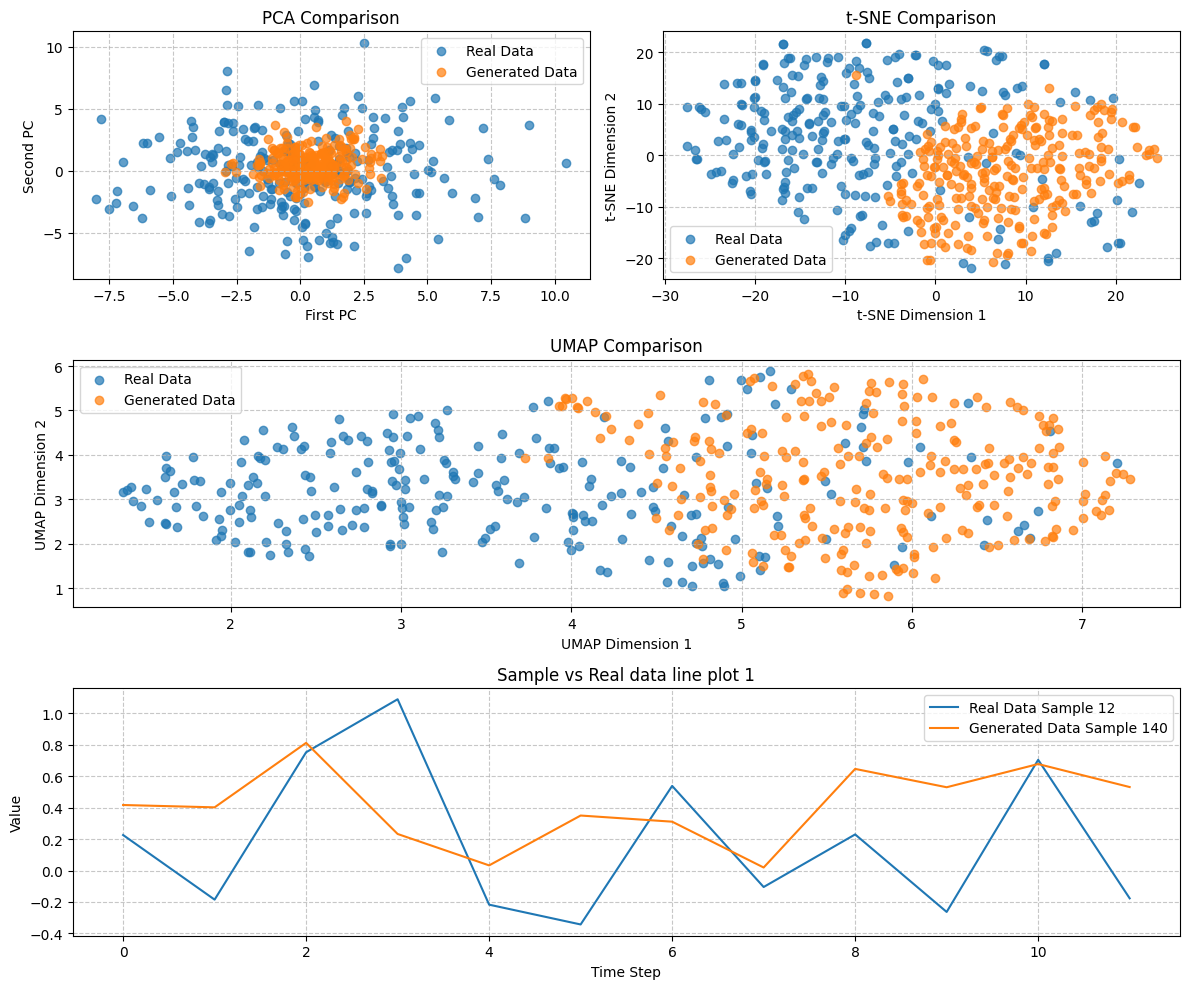

In [11]:
visual_evaluation(real_data_train, samples, log_file_name, False, "train")

### Test

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


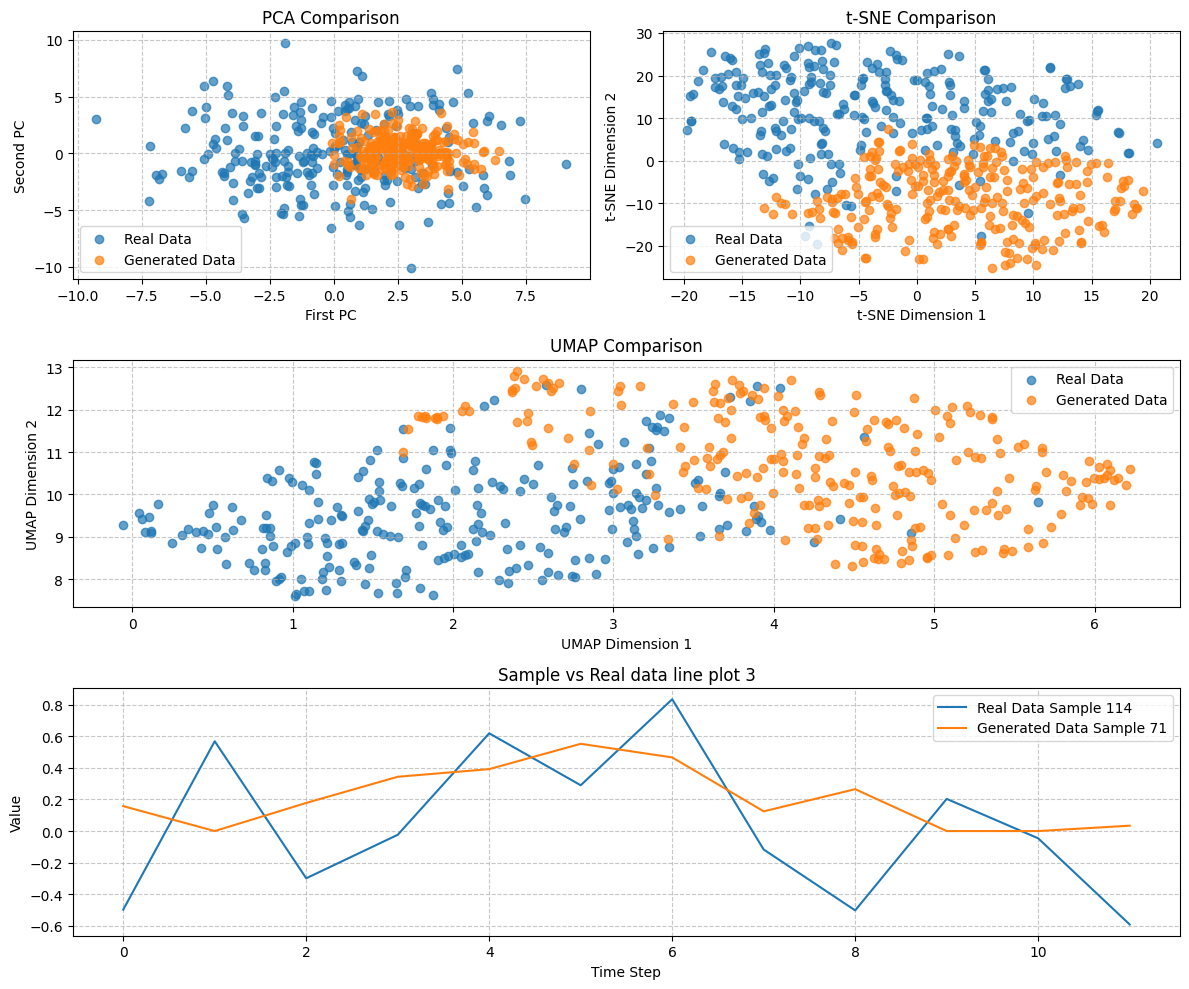

In [12]:
visual_evaluation(real_data_test, samples, log_file_name, False, "test")

### Jensen-Shannon Divergence

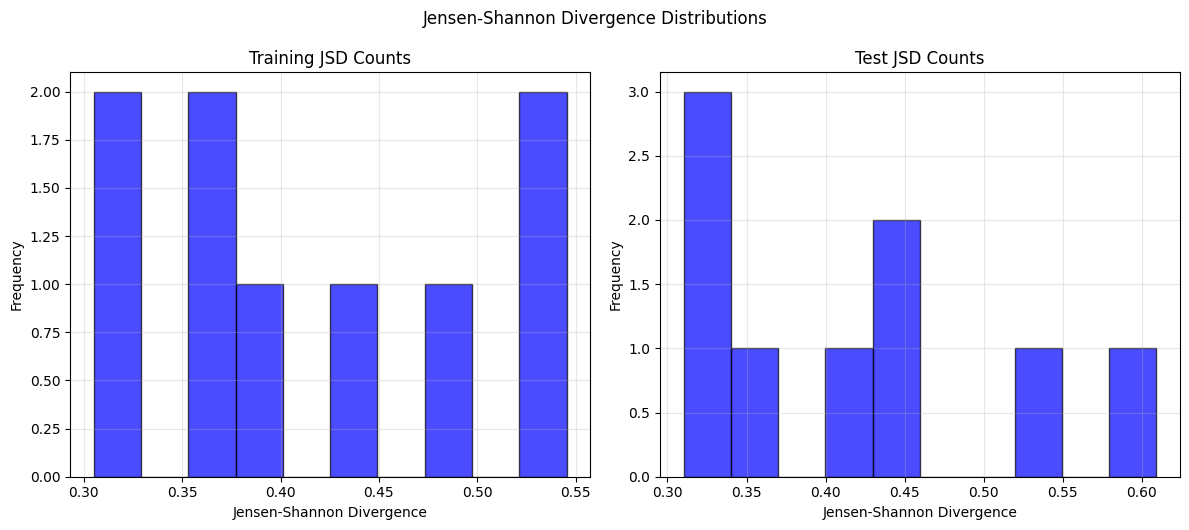

In [13]:
plot_jsd(real_data_train, real_data_test, samples.transpose(0,2,1), log_file_name)

### Plot Comparison

sampling loop time step: 100%|██████████| 1000/1000 [00:03<00:00, 312.03it/s]


Text(0.5, 1.0, 'Real Data')

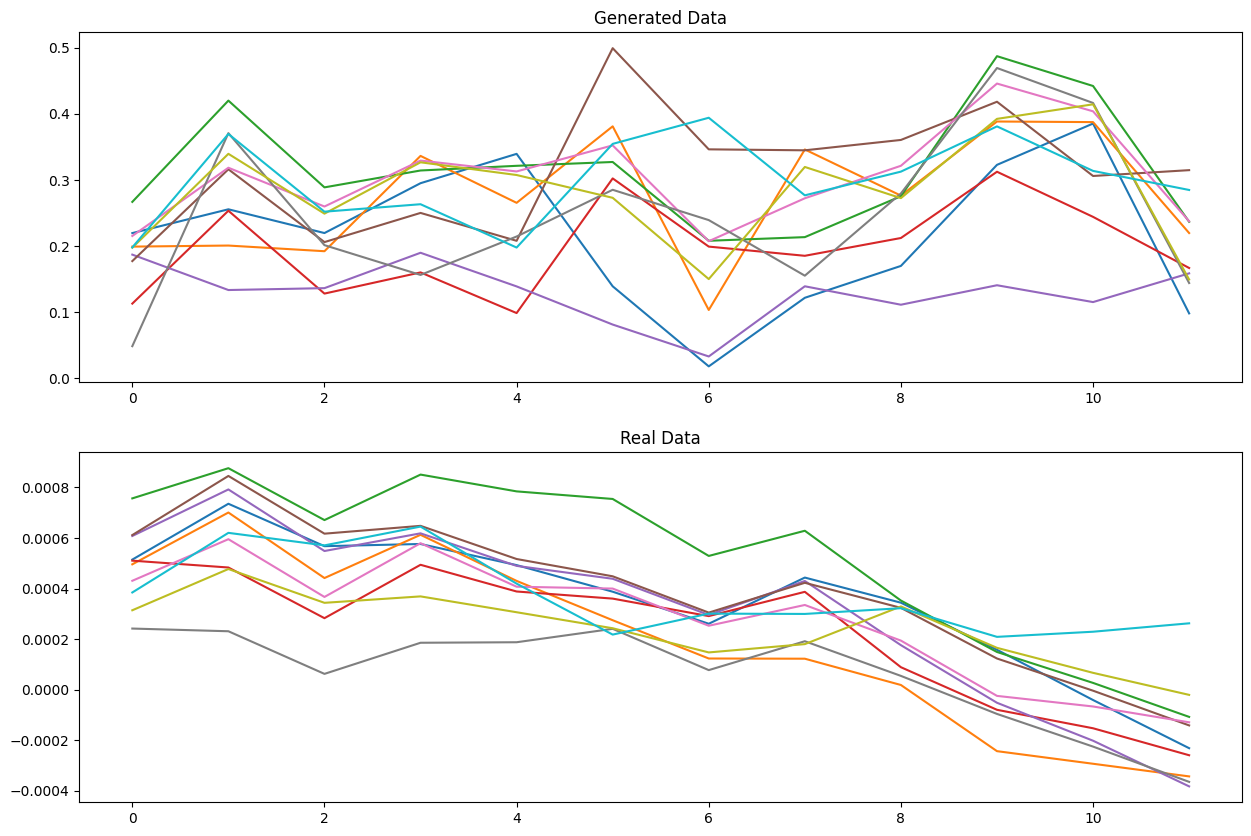

In [14]:
sample_list = []
for i in range(0, 10):
    with torch.no_grad():
        sample = ddpm.sample(1)
        sample = sample.cpu().numpy().squeeze()
    
    sample_list.append(sample)

sample_mean = np.mean(sample_list, axis=0)
gt_mean = test_data.mean(axis=0)

fig, axs = plt.subplots(2, 1, figsize=(15, 10))

for i in range(0, sample_mean.shape[0]):
    axs[0].plot(range(0, sample_mean.shape[1]), sample_mean[i])
    axs[1].plot(range(0, gt_mean.shape[1]), gt_mean[i])

axs[0].set_title("Generated Data")
axs[1].set_title("Real Data")


## With Conditioning

In [15]:
with torch.no_grad():
    cond_samples_train = ddpm.sample(real_cond_data_train.shape[0], real_cond_data_train.to(device))
    cond_samples_train = cond_samples_train.cpu().numpy()

print(f"Samples shape: {cond_samples_train.shape}")

sampling loop time step: 100%|██████████| 1000/1000 [00:05<00:00, 188.78it/s]


Samples shape: (256, 10, 12)


## Train

### T-SNE and PCA

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


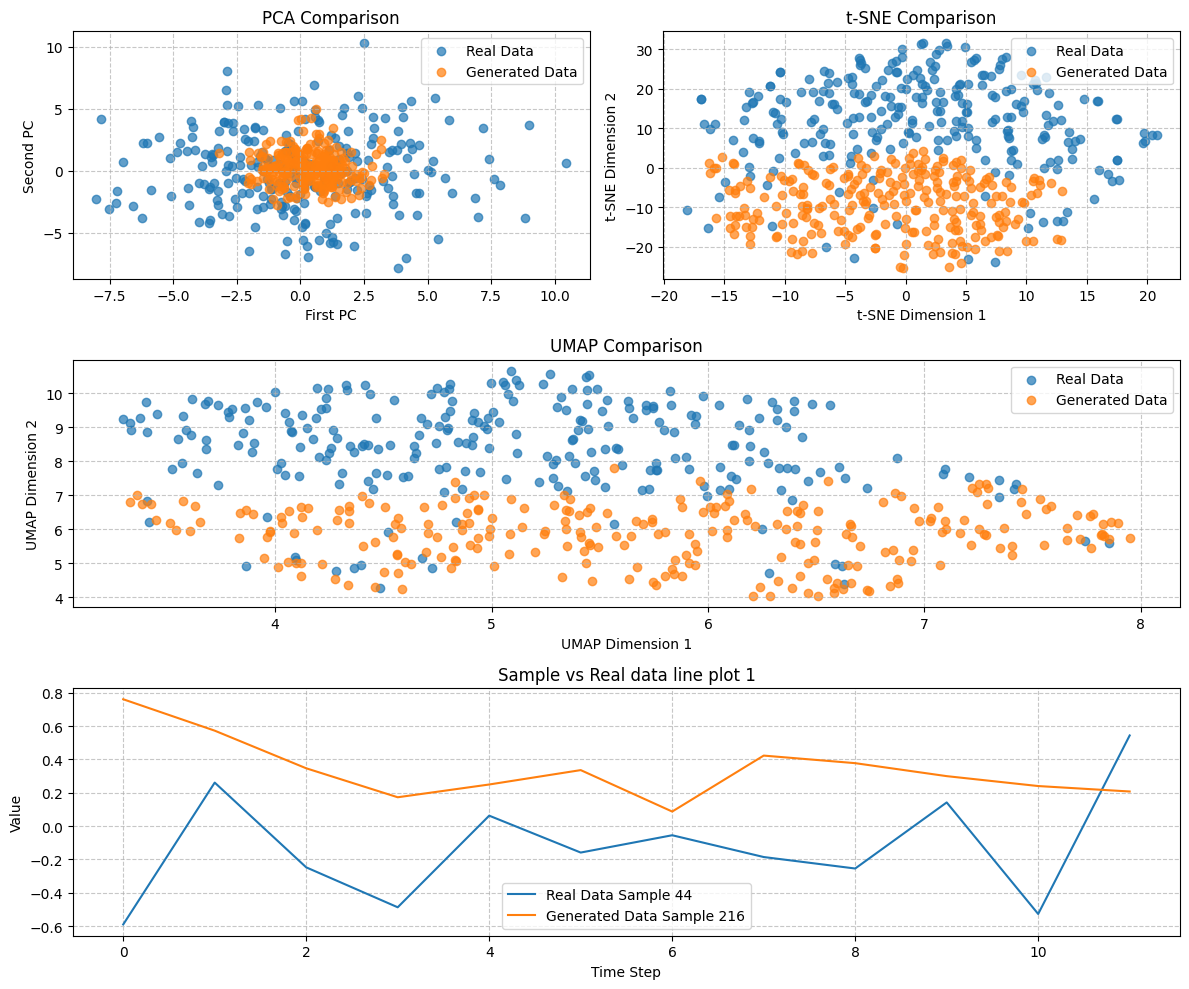

In [16]:
visual_evaluation(real_data_train, cond_samples_train, log_file_name, True, "train")

### Jensen-Shannon-Divergence

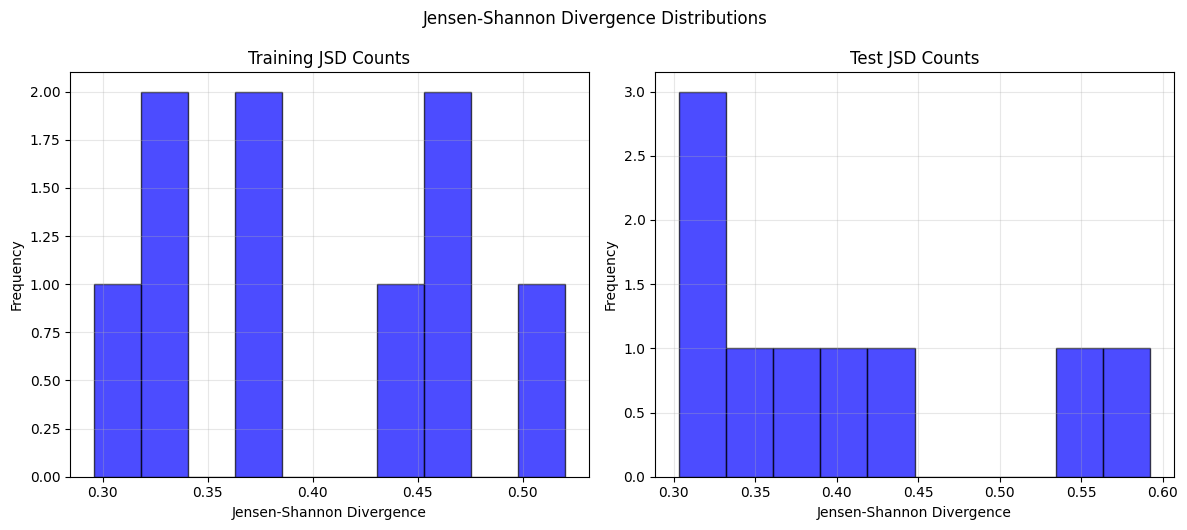

In [17]:
plot_jsd(real_data_train, real_data_test, cond_samples_train.transpose(0,2,1), log_file_name, cond=True)

## Test

In [18]:
with torch.no_grad():
    cond_samples_test = ddpm.sample(real_cond_data_test.shape[0], real_cond_data_test.to(device))
    cond_samples_test = cond_samples_test.cpu().numpy()

print(f"Samples shape: {cond_samples_test.shape}")

sampling loop time step: 100%|██████████| 1000/1000 [00:05<00:00, 184.54it/s]

Samples shape: (256, 10, 12)


c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


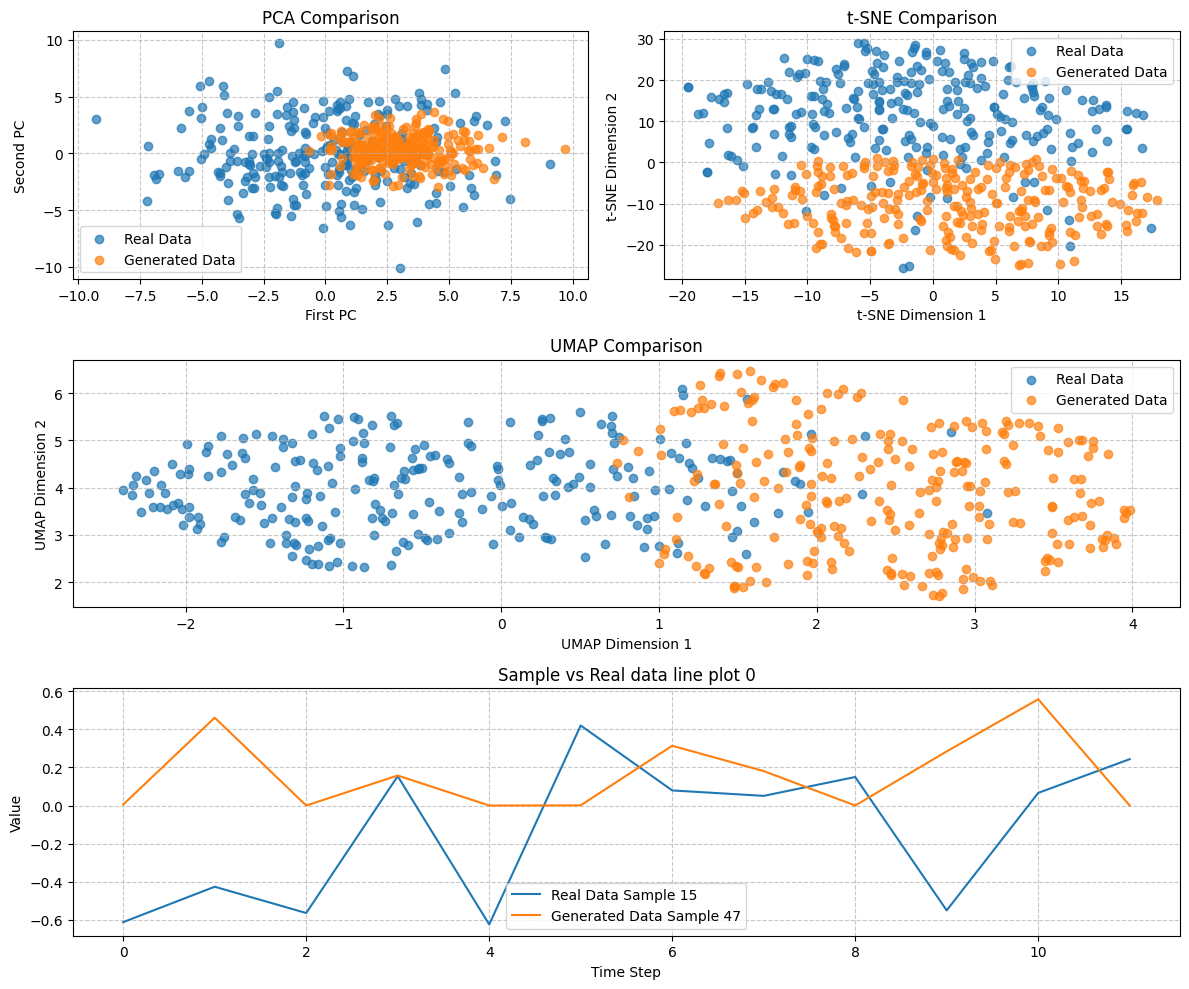

In [19]:
visual_evaluation(real_data_test, cond_samples_test, log_file_name, True, "test")

### Jensen-Shannon Divergence

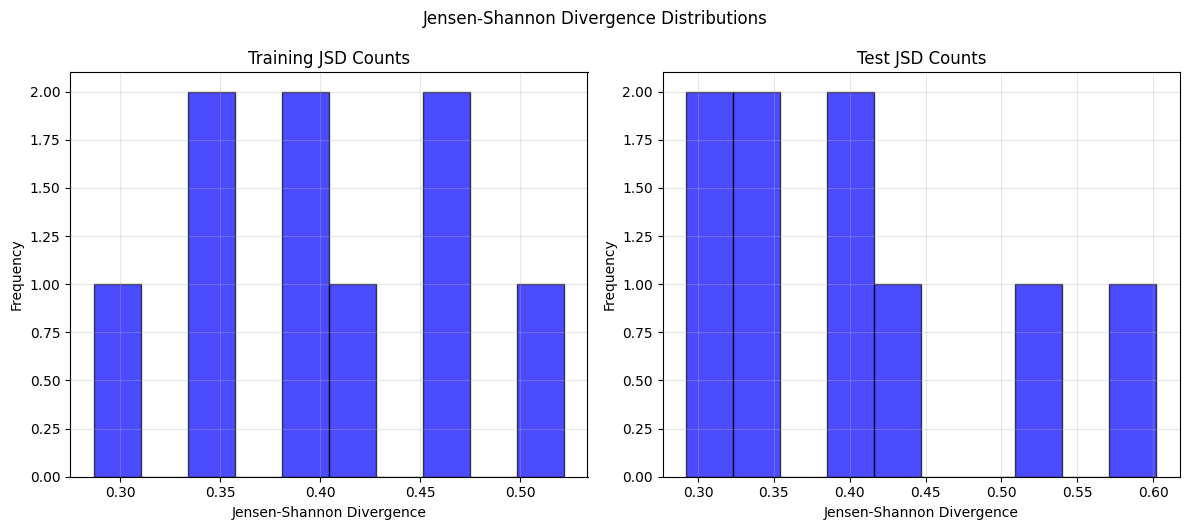

In [20]:
plot_jsd(real_data_train, real_data_test, cond_samples_test.transpose(0,2,1), log_file_name, cond=True)

# Logging

In [21]:
log_dir = "./logging/logs"
log_file_path = os.path.join(log_dir, log_file_name + ".txt")

with open(log_file_path, 'w') as log_file:
    log_file.write("Config:\n")
    for key, value in config.items():
        log_file.write(f"{key}: {value}\n")
    
    log_file.write("\n\nRMSE Values:\n")
    for rmse in rmse_list:
        log_file.write(f"{rmse}\n")

print(f"Log file created at: {log_file_path}")

Log file created at: ./logging/logs\TransEncoder_mlp_2025-03-28-12-54.txt
